In [1]:
import numpy as np
from numpy import random
import gensim
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
%matplotlib inline



In [2]:
df=pd.read_excel('final_210504_tous labels.xlsx',engine='openpyxl')
df = df[pd.notnull(df['catégorie'])]

In [3]:
df = df.drop(['Date de création',  'Date de modification','Nom du fichier'], axis=1)

In [4]:
df['Messages']=df['Messages'].astype(str)

In [5]:

print(df['Messages'].apply(lambda x: len(x.split(' '))).sum())
msg=df.head(2500)

510860


In [6]:
tab=[]

for i in msg.index:
    
    msg['Messages'][i]=re.sub('([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)', '', str(msg['Messages'][i]))#email
    #phone
    msg['Messages'][i]=re.sub(r"/\d{10}|\+33\d{9}|\+33\s\d{1}\s\d{2}\s\d{2}\s\d{2}\s\d{2}|\d{2}\s\d{2}\s\d{2}\s\d{2}\s\d{2}/g",' ',str(msg['Messages'][i]))#phone francais
    msg['Messages'][i]=re.sub(r'(^(\+33 |0)[1-6]{1}(([0-9]{2}){4})|((\s[0-9]{2}){4})|((-[0-9]{2}){4})$)','',str(msg['Messages'][i]))
    msg['Messages'][i]=re.sub("((?:\+\d{2}[-\.\s]??|\d{4}[-\.\s]??)?(?:\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4}))",'', str(msg['Messages'][i]))#phone
    msg['Messages'][i]=re.sub('\(?\d{2}\)?[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]?\d{2}','',str(msg['Messages'][i]))
    msg['Messages'][i]=re.sub('\(?\d{2}\)?[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]','',str(msg['Messages'][i]))
    msg['Messages'][i]=re.sub('\(?\d{1}\)?[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]','',str(msg['Messages'][i]))
    msg['Messages'][i]=re.sub('\(?\d{2}\)?[-.\s]?\d{5}[-.\s]?\d{3}','',str(msg['Messages'][i]))
    msg['Messages'][i]=re.sub('\(?\d{1}\)?[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]?\d{3}','',str(msg['Messages'][i]))
    msg['Messages'][i]=re.sub('\(?\d{2}\)?[-.\s]?\d{3}[-.\s]?\d{3}[-.\s]?\d{3}','',str(msg['Messages'][i]))
    #Emoji
    emoji= re.compile(u'['u'\U0001F300-\U0001F64F'u'\U0001F680-\U0001F6FF'u'\u2600-\u26FF\u2700-\u27BF]+', re.UNICODE)
    msg['Messages'][i]=re.sub(emoji,' ',str(msg['Messages'][i]))
    #text
    msg['Messages'][i]= msg['Messages'][i].replace("Avant d\'imprimer cet e-mail, réfléchissez à l\'impact sur l\'environnementBefore you print this mail, think about the impact on the environment",'')
    dele = ["Mail:","Email:","e-mail","Email : ","mail","Tél : +","Fax : +","tél.: + ()","port.: + () ","fax.: + ()"]
    #df['Text'][i]= df['Text'][i].replace(dele,'')
    msg['Messages'][i]= msg['Messages'][i].replace("Mail:",'')
    msg['Messages'][i]= msg['Messages'][i].replace("Email:",'')
    msg['Messages'][i]= msg['Messages'][i].replace("E-mail",'')
    msg['Messages'][i]= msg['Messages'][i].replace("Email : ",'')
    msg['Messages'][i]= msg['Messages'][i].replace("mail",'')
    msg['Messages'][i]=re.sub(r'\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4}','',str(msg['Messages'][i]))
    #df['Text'][i]=re.sub(r'\d+','',str(df['Text'][i]))#Tél : +      Fax : +, tél.: + ()       fax.: + ()      port.: + () 
    msg['Messages'][i]= re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",'',msg['Messages'][i])#url
    msg['Messages'][i]= re.sub('(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})',' ',str(msg['Messages'][i]))#url www
    msg['Messages'][i]= re.sub('Ce message et toutes les Pieces jointes (ci apres : le message) sont etablis a l\'intention exclusive de ses destinataires et sont confidentiels.Toute utilisation de ce message non conforme a sa destination, toute diffusion ou toute publication totale ou partielle est interdite sauf autorisation prealable.Si vous recevez ce message par erreur, merci de le detruire et d\' avertir immediatement l\'expediteur.Les communications sur Internet n\'etant pas securisees, le Groupe APRR decline toute responsabilite quant au contenu de ce message.This message and all attached documents (hereafter "the message") are intended for the exclusive attention of its recipients and are confidential. Any use of this message, for which it was not intended, any distribution or any total or partial publication is prohibited unless previously approved.If you receive this message in error, please destroy it and immediately notify the sender thereof.Since communication by Internet is not secure, Group APRR cannot accept any responsibility regarding the contents of this message.',' ',str(msg['Messages'][i]))
    #df['Text'][i]= re.sub('SCAN <>Cet  a été envoyé par "copieurRICOH" (MP C3004ex).Date de numérisation: 07.08.2020 17:17:25 (+0200)Contacter si besoin :  ','',str(df['Text'][i]))
    msg['Messages'][i]= re.sub('Ce message est généré automatiquement. Merci de ne pas y répondre.',' ',str(msg['Messages'][i]))
    msg['Messages'][i]= re.sub('Ce message et toutes les Pieces jointes (ci apres : le message) sont etablis a l\'intention exclusive de ses destinataires et sont confidentiels.Toute utilisation de ce message non conforme a sa destination, toute diffusion ou toute publication totale ou partielle est interdite sauf autorisation prealable.Si vous recevez ce message par erreur, merci de le detruire et d\' avertir immediatement l\'expediteur.Les communications sur Internet n\'etant pas securisees, le Groupe APRR decline toute responsabilite quant au contenu de ce message.This message and all attached documents (hereafter "the message") are intended for the exclusive attention of its recipients and are confidential. Any use of this message, for which it was not intended, any distribution or any total or partial publication is prohibited unless previously approved.If you receive this message in error, please destroy it and immediately notify the sender thereof.Since communication by Internet is not secure, Group APRR cannot accept any responsibility regarding the contents of this message.',' ',str(msg['Messages'][i]))
    msg['Messages'][i]= re.sub('This message and any attachments are confidential and intended for the named addressee(s) only.If you have received this message in error, please notify immediately the sender, then deletethe message. Any unauthorized modification, edition, use or dissemination is prohibited.The sender shall not be liable for this message if it has been modified, altered, falsified, infectedby a virus or even edited or disseminated without authorization.',' ',str(msg['Messages'][i]))
    msg['Messages'][i]= re.sub('This  transmission (message and any attached files) may contain information that is proprietary, privileged and/or confidential to Veolia Environnement and/or its affiliates and is intended exclusively for the person(s) to whom it is addressed. If you are not the intended recipient, please notify the sender by return  and delete all copies of this , including all attachments. Unless expressly authorized, any use, disclosure, publication, retransmission or dissemination of this  and/or of its attachments is strictly prohibited. Ce message electronique et ses fichiers attaches sont strictement confidentiels et peuvent contenir des elements dont Veolia Environnement et/ou l\'une de ses entites affiliees sont proprietaires. Ils sont donc destines a l\'usage de leurs seuls destinataires. Si vous avez recu ce message par erreur, merci de le retourner a son emetteur et de le detruire ainsi que toutes les pieces attachees. L\'utilisation, la divulgation, la publication, la distribution, ou la reproduction non expressement autorisees de ce message et de ses pieces attachees sont interdites.',' ',str(msg['Messages'][i]))
    msg['Messages'][i]= re.sub('This  transmission (message and any attached files) may contain information that is proprietary, privileged and/or confidential to Veolia Environnement and/or its affiliates and is intended exclusively for the person(s) to whom it is addressed. If you are not the intended recipient, please notify the sender by return  and delete all copies of this , including all attachments. Unless expressly authorized, any use, disclosure, publication, retransmission or dissemination of this  and/or of its attachments is strictly prohibited.  Ce message electronique et ses fichiers attaches sont strictement confidentiels et peuvent contenir des elements dont Veolia Environnement et/ou l\'une de ses entites affiliees sont proprietaires. Ils sont donc destines a l\'usage de leurs seuls destinataires. Si vous avez recu ce message par erreur, merci de le retourner a son emetteur et de le detruire ainsi que toutes les pieces attachees. L\'utilisation, la divulgation, la publication, la distribution, ou la reproduction non expressement autorisees de ce message et de ses pieces attachees sont interdites.',' ',str(msg['Messages'][i]))
    msg['Messages'][i]= re.sub('Le contenu de ce message est strictement réservé à l\'usage exclusif de son destinataire et contient de l\'information privilégiée et confidentielle. Toute lecture, divulgation, distribution ou copie non autorisée de cette communication est formellement interdite. Si vous avez reçu cette communication par erreur, veuillez la détruire immédiatement.','',str(msg['Messages'][i]))
    msg['Messages'][i]= re.sub('Ce message et toutes les Pieces jointes (ci apres : le message) sont etablis a l\'intention exclusive de ses destinataires et sont confidentiels.Toute utilisation de ce message non conforme a sa destination, toute diffusion ou toute publication totale ou partielle est interdite sauf autorisation prealable.Si vous recevez ce message par erreur, merci de le detruire et d\' avertir immediatement l\'expediteur.Les communications sur Internet n\'etant pas securisees, le Groupe APRR decline toute responsabilite quant au contenu de ce message.This message and all attached documents (hereafter "the message") are intended for the exclusive attention of its recipients and are confidential. Any use of this message, for which it was not intended, any distribution or any total or partial publication is prohibited unless previously approved.If you receive this message in error, please destroy it and immediately notify the sender thereof.Since communication by Internet is not secure, Group APRR cannot accept any responsibility regarding the contents of this message.',' ',str(msg['Messages'][i]))
    msg['Messages'][i]= re.sub('Ce message et les pièces jointes sont confidentiels et établis à l\'attention exclusive de ses destinataires. Toute utilisation ou diffusion, même partielle, non autorisée est interdite. Tout message électronique est susceptible d\'altération. Brink\'s décline toute responsabilité au titre de ce message s\'il a été altéré, déformé ou falsifié. Si vous n\'êtes pas le destinataire de ce message, merci de le détruire et d\'avertir l\'expéditeur. This message and any attachments are confidential and intended solely for the addressees. Any unauthorized use or disclosure, either whole or partial is prohibited. E-s are susceptible to alteration. Brink\'s shall not be liable for the message if altered, changed or falsified. If you are not the intended recipient of this message, please delete it and notify the sender.',' ',str(msg['Messages'][i]))
    msg['Messages'][i]= re.sub('Ce message et toutes les Pieces jointes (ci apres : le message) sont etablis a l\'intention exclusive de ses destinataires et sont confidentiels.Toute utilisation de ce message non conforme a sa destination, toute diffusion ou toute publication totale ou partielle est interdite sauf autorisation prealable.Si vous recevez ce message par erreur, merci de le detruire et d\' avertir immediatement l\'expediteur.Les communications sur Internet n\'etant pas securisees, le Groupe APRR decline toute responsabilite quant au contenu de ce message.','',str(msg['Messages'][i]))
    
    print(msg['Messages'][i])

Bonjour,Ci-joint le mandat sepa et le rib.CordialementBLACKSTONEBertrand STRAZELTel : 14
DANIEL   GUEGANSOCIETE DES TRANSPORTS GUEGANClient N° 14LIEU DIT FONTAINGUY 35290 ST ONEN LA CHAPELLE FRANCEBonjour,En mettant à jour nos badges pour équiper l'ensemble de notre flotte, nous constatons qu'une commande crée le n'est pas validée. Nous n'avons reçu aucune demande de votre part depuis le  du précisant que la commande avait bien été prise en compte.Nous avons passé 2 commandes le Vous trouverez, en pièce jointe, le détail de nos commandes en instance.Pour information, l'ensemble des cartes grises ont bien été fournies lors de la création des véhicules.Nous vous remercions de nous tenir informés de la suite que vous souhaitez y donner.Bien cordialement,Léone GUEGANSociété des Transports GUEGAN
 Bonjour, J’ai essayé de faire la modification du badge du EC 418 KS initialement en classe 4 que nous avons vendu et remplacé par une classe 3 immatriculé DW-641-BJ. Le badge est VIA AXXES SAT MAN

C:\Users\bertille.lekeufack\.conda\envs\stage1\lib\site-packages\IPython\core\interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


Bonjour, Afin de valider ma commande de badge, je vous adresse en annexe copie de la carte grise. Concernant ce véhicule, il est en CAT 3 compte tenu de son gabarit. Par ailleurs, vous trouverez également en pièce jointe un kbis afin de mettre votre fichier à jour. En effet, le nouveau représentant légal est gilles GAUCHEY Bien cordialement Gilles GAUCHEY
 Bonjour Nous vous remettons les justificatifs des virements émis par : Segovia Sa : 7 745.70 €Segovia Almacenaje SL : 4 469.26 € Cordialement Mercedes San PedroS.T.SLes Demeures de Beyris – Bât.B17 Avenue de l’Ursuya64100 Bayonne – FranceTél : 00 33 (0)5 Fax : 00 33 (0)5Mobile : 00 33 (0)6 
Bonjour,  Suite à notre commande N° 44, veuillez trouver ci-joint la CG. Vous souhaitant bonne réception. Bien cordialement. SAS STRUMIA8, rue Paul Langevin34500  
Bonjour Madame ABANE Nous sommes toujours dans l’impossibilité de passer des commandes de badges PL SDIS sur le site Axxès. Aussi, vous trouverez, en PJ, le fichier de commande (1ère do

Monsieur Rascol, Comme convenu, le tableau demandé. Restant à votre disposition. Faryel BELGACEMResponsable commerciale Sud-Est +33  15, Rue des cuirassiers       CS  LYON CEDEX 03           De : Gerald Rascol <> Envoyé : mercredi 5 août 2020 13:30À : Faryel BELGACEM <>; St-martin <>Objet : RE: Axxès : Changement de technologie de badges satellitaires en DSRC  Bonjour  J’ai besoin d’infos supplémentaire sur les autoroutes. Concernant les autoroutes SAPN SANEF APRR qi sont aussi des autoroute de France si je coche les 3 case pour dire de pouvoir couvrir la France entière avec ces badges y a-t-il un cout supplémentaires ??   Autre question ayant déjà notre dossier en cours chez vous vous devriez avoir déjà toutes nos carte grise ou faut-il quand même vous les faire parvenir car 47 cartes grise a vous faire parvenir cela fait un dossier trop lourd par    Cordialement   RASCOL GéraldResponsable de parcPort :  Direct : Fax :  Chemin du Midi – 84 300 CAVAILLON De : Faryel BELGACEM [to:] Envo

Bonjour Ci-joint la carte grise demander. Cordialement Htrans  De : Lyon <>Date : jeudi 6 août 2020 à 10:07À : contact Htrans <>Objet : Votre commande n°6 Cher client, Vous avez saisi une commande sur votre espace client et nous vous en remercions. Pouvez s’il vous plaît nous faire parvenir la carte grise du véhicule  ES-885-RK afin que nous puissions valider cette commande ? Ne considerez pas cet e si vous avez déjà envoyé les documents. Merci par avance. Cordialement.     Floriane PerezTeam Leader Centre de Contact Immeuble le Silex,15 rue des cuirassiers69487 LYON Tel  Fax +33   
Madamecompte client 1n° de contrat  concerne prélèvement facture n° 72 du 15 juillet 2020 de 217.65 ePIECES JOINTEVOTRE COURRIER ET REF CONTRATCOPIE DE NOTRE VIREMENT DE 217.65 E FAIT CE MATIN SUR VOTRE COMPTEveuillez trouver ci joints en copie votre courrier et une copie pour preuve de mon paiementce jour par virement de 217.65 e sur votre compte je vous demande de ne pas mettre opposition sur notre badge 

Bonjour, Je me permets de revenir vers vous afin de suivre l’évolution de vos besoins.Pour info, à date:Masques chir type 2R: 0,20€Masques chir type 1: 0,12€Nous proposons également gants, lingerie, gels, visières…Je vous joins de nouveau notre catalogue dans ce .Je restes à votre disposition pour toutes informations complémentairescdtYann AbezisJLB GROUP15 rue du Bois Moussay93240 StainsTel:  P:  
Bonjour, Pouvons-nous procéder à l’échange du badge ci-joint, car nous avons remarqué une anomalie de fonctionnement depuis plusieurs jours, Le véhicule est souvent invisible à la géolocalisation  Dans l’attente de votre retour   CordialementJohann DOMENECH  TRANSPORTS ZANUT Avenue Edouard Branly47 400 TONNEINST : P : F :  
                                              Bonjour Je vous remercie de m'envoyer un badge autoroute pour le nouveau véhicule en pièce jointe.   Cordialement     Valérie
Bonjour, Nous vous remercions de bien vouloir prendre en compte notre demande d’un badge supplémenta

Bonjour,Pouvez-vous me dire où en est cette commande passée le 15/07/2020, nous n’avons toujours rien reçu.Par avance je vous remercie.Bien cordialement,Marine Le Roux 7, Rue Charles Piot38320 Eybens 
Bonjour,Je suis absente du bureau jusqu'au 28/08/2020 inclus.Je prendrais connaissance de votre message à mon retour. En cas d'urgence, veuillez contacter notre agence d’Echirolles au 94.Cordialement.  Karen GIGANTEComptable Conseil12 rue de Lorraine 38130 ECHIROLLESTél. 65 - Fax 74  cerfrance-isere.fr               

Bonjour, vous trouverez ci-joint un bon de commande Carrefour qui est à reporter sur votre facture tel qu'il est inscrit en entête. En cas de problème, merci de contacter le site concerné indiqué dans l'encart du bon de commande : "Livrer à"
 
BonjourNotre mot de passe ne fonctionne plusComment devons nous faire ?MerciCordialementSARL ANCELLE27,chemin de la Terre au Cluseau71960 PRISSE  Facebook : Entreprise Ancelle Le : 07 août 2020 à 01:54 (GMT +02:00)De : "" <>À : "" <>Ob

Good afternoon DHL team !  Could you please provide us with more information regarding your request? This is the first time we are receiving this kind of query from you and we are unsure about how to proceed. Please advise. Regards, Virginie MOSNIERChef de produit digital / Digital Product manager03     De : Helpdesk CSC (DHL DE) <> Envoyé : vendredi 7 août 2020 14:00À : Cc : '' () <>; CHAFIYI ADJAI (DHL FR) <>; Carine Nsanda (DHL DE) <>; Mustafa Sahin (DHL FR) <>; Helpdesk CSC (DHL DE) <>;  : AW: REMINDER: Eskalation STC Transports; Ref: CRM: SARL STC - Client n° 51Importance : Haute Hello Lyon Axxes Company, please give us an update about our request. Your urgent support is required here in order to get the topic sorted.  Thank you very much.  Mit freundlichen Grüssen/Kind regards Filip ErcegovacSupervisor BMW Control Tower DHL Freight GmbH, Franz-Lehner-Str. 11, D-85716 UnterschleißheimPhone: +49 (0), Fax: +49 (0)  DHL Freight – Excellence. Simply Delivered. Von: Helpdesk CSC (DHL D

Good Afternoon Virginie,Thank you very much for response.We have received your contact from Bruno Cherqui from STC Transports (N° Client: 51).  DHL is implementing a track & trace platform to track the positions from their transport partner’s vehicles. We (Agheera) are the technology partner of DHL that implement the track & trace platform and need an API from your side to access vehicle positions of STC Transports.  STC Transports granted us access to the data of their vehicles. Please see attached authorization form document.  Would you be so kind to provide us short documentation to your API (application Programming Interface), the data structure as well as username and password for authentication against your system?Furthermore, please let us know the correct URL to your webservice. If you have any further questions, please don’t hesitate to contact me.  Mit freundlichen Grüßen / With best regards, Stephan WahlenOperations / IoT Hardware Agheera GmbH Junkersring 553844 Troisdorf La

Bonjour Pouvez vous appareiller ce badge avec cette nouvelle immatriculation ? merci De : Sebastian VLAICONI <> Envoyé : mardi 11 août 2020 12:14À : Sebastian VLAICONI <>Objet : Photo de Vlaiconi     Envoyé depuis mon smartphone Samsung Galaxy. 
Suite à message précèdent veuillez trouver la pièce jointe. Cordialement,   Sandrine Lecellier_______________________________________________________________Agence comptable | Département dépensesT + 33(0)1 ● 73, AVENUE DE PARIS, 94165 SAINT MANDE CEDEXign.fr - geoportail.gouv.fr     De : Sandrine Lecellier Envoyé : mardi 11 août 2020 13:05À :  : service.facturierObjet : Réf. client: 37- IGN Bonjour, Veuillez trouver ci-joint l’avoir n° FR du 23/07/20 d’un montant de 434,64€ TTC faisant référence à la facture n°FR du 26/12/2019. Or cette facture a déjà été annulée par l’avoir n°FR. Cet avoir doit-il faire référence à la facture FR ? Je vous remercie par avance de votre retour. Cordialement,  Sandrine Lecellier___________________________________

Bonjour,  Est-il possible d’attribuer un badge télépéage à un nouveau véhicule ?Vous trouverez en pièce jointe la carte grise. Je vous remercie pour votre réponse. Bien cordialement,  Cécile ChopinDGSER-DAF-CFCService administratif*99-6065 – 297 43 00: Avez-vous vraiment besoin d’imprimer cet e- ?  **************************************************************Ce courrier électronique, y compris les pièces jointes, est à l'attention exclusive des destinataires désignés et revêt un caractère confidentiel.Si vous recevez ce courrier électronique par erreur, merci d'en informer sans délai l'expéditeur et de supprimer son contenu et ses pièces jointes.Le contenu de ce courrier électronique ne pourrait engager la responsabilité de la Banque de France que s'il a été émis par une personne dûment habilitée agissant dans le strict cadre des fonctions auxquelles elle est employée et à des fins non étrangères à ses attributions. L'expéditeur de ce courrier électronique ne peut pas garantir la sécu

Bonjour, je vous joint par , le bon de commande pour un télépéage pour mon véhicule, le mandat et la demande d’abonnement. L’acompte, je l’envoi en cheque par voix postal.En plus je vous joint, un RIB de ma société, un extrait Kbis, la photocopie de la carte grise du vehicule et le carré barré. Merci d’avance  Mr TACCOEN LéoSARL TRANSPORTS TACCOEN 293 rue des petits moulins 62215 OYE-PLAGE 
Madame, Ci-joint la copie de la carte grise. Cordialement Rochanak DEHBASHIService Comptabilité Tél. :  De : Lyon [to:] Envoyé : lundi 10 août 2020 14:36À : Rochanak Dehbashi <>Objet : RE: demande de badge pour véhicule FR-398-NJ Bonjour,  Afin de traiter au mieux votre demande de badge, je vous prie de bien vouloir nous adresser la carte grise du véhicule FR-398-NJ.Dans l’attente,  Cordialement / Best regards/ Saludos cordiales/ Melhores cumprimentos. Marlène NTSAMEGestionnaire Clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03                 De : Rochanak Dehbashi <> Envo

Bonjour, Vous trouverez ci-dessous les éléments pour le traitement de la commande des Transports Garage Laval40 AFM PL + 10 AFM VL en offre Flex.C’est-à-dire le badge B’moov pour avoir la géoloc, et les pays standards inclus (France, Espagne, Portugal, Tunnels)(Donc pas l’offre complète internationale, ni de pays supplémentaires.) Je vous ai déjà transmis les éléments suivantsLa demande d’ouverture de compteLe bon de commandeLe mandat SEPAKbisRibLes conditions spéciales accordées Dans ce , vous trouverez en complément les éléments suivants :Le justificatif d’adhésion FNTRLa liste excel des véhicules (annexe du bon de commande)La fiche navette Il s’agit d’un ancien bon de commande sur ce client Le dossier est validé par Maud, pas besoin de garantie. enregistré dans le CRM. Je souhaiterais une livraison pour le mardi 25/08.Merci d’avance de votre confirmation que la livraison pourra se faire le mardi 25 (ou le mercredi 26) Les 10 VL qui sont présents dans la liste ne sont pas encore à tr

EN PIECE JOINTExpandlégua Transportes Unipessoal LdaRua da Relva nr 2 Mozelos PORTUGALTelf. Telf. 08De: Lyon <>Enviado: 4 de agosto de 2020 13:16Para: Manuel Silva <>Assunto: RE: 01 IMPAYE EXPANDLEGUA TRANSPORTES // REFERENCE CLIENT: 34  Bonjour, Nous accusons réception de votre preuve de virement.Je vous confirme que celui-ci a bien été pris en compte par notre service facturation. Cordialement. Marlène NTSAMEGestionnaire Clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03                 De : Manuel Silva <> Envoyé : mardi 4 août 2020 10:54À : Lyon <>Objet : RE: 01 IMPAYE EXPANDLEGUA TRANSPORTES // REFERENCE CLIENT: 34 Madame Marlene En piece joint:  comprovatif de virement de la derniere facture impayémandate SEPA et RIB pour alteration bancaireMerci d'avance   Expandlégua Transportes Unipessoal LdaRua da Relva nr 2 Mozelos PORTUGALTelf. Telf. 08  De: Lyon <>Enviado: 3 de agosto de 2020 10:57Para: Manuel Silva <>Assunto: RE: 01 IMPAYE EXPANDLEGUA TRANSPORTES 

 Buenos días, Necesitamos por favor cambiar la matricula del aparato de la referencia 00428, y adjudicarlo a la matricula 7997JVS, cuya documentación adjuntamos. Muchas gracias  Saludos Mireya García García Dpto. Administración  Nº Certificado: ES081331-1Este mensaje y los documentos que, en su caso, lleve anexos, se dirige exclusivamente a su(s) destinatario(s) y puede contener información privilegiada o confidencial. El acceso a esta información por otras personas distintas a las designadas no está autorizado. Si Vd. no es el destinatario indicado, queda notificado que la utilización, divulgación y/o copia sin autorización está prohibida en virtud de la legislación vigente. Si ha recibido este mensaje por error, por favor le rogamos que lo comunique inmediatamente al remitente vía e- y proceda a su destrucción. AVISO LEGAL Le informamos que, en cumplimiento de la Ley 15/1999, de 13 de Diciembre, de Protección de Datos de carácter personal, los datos personales de esta comunicación se

Bonjour, Suite à la résiliation du contrat entre DUCATIMO S.A. et AXXES et au renvoi des badges à vos services, je vous fais parvenir ci-joint notre RIB pour le remboursement de la caution de 600 EUR.Pouvez-vous svp me tenir informée lorsque le virement sera effectué ? Merci beaucoup.Bien à vous  Alexandra  DUCATIMO S.A.DumontshaffL.3841 SCHIFFLANGE tél : 00.3.fax : 00.3. De : Lyon <> Envoyé : mercredi 8 juillet 2020 14:11À : DUCATIMO S.A. <>Objet : RE: Confirmation de votre demande de résiliation/ DUCATIMO - Client n° 07Importance : Haute Bonjour, Je fais suite à votre demande. Je vous confirme que votre boitier a bien été récupéré à notre atelier. Votre dépôt de garantie sera reversé à la clôture définitive de votre contrat dès le 15/08/20. Je reste à disposition pour toute information complémentaire. Bien cordialement,  Cécilia LE PIERRESAssistance Utilisateurs/ Users Support  De : DUCATIMO S.A. <> Envoyé : mercredi 8 juillet 2020 12:19À : Lyon <>Objet : RE: Confirmation de votre de

Bonjour,  Cette demande concerne la facturation. Pouvez-vous vérifier svp ?  Cordialement / Regards / Atentamente / Distinti saluti / Cumprimentos Pablo de la FuenteChargée SAV/ Aftersales Representative Immeuble le Silex,15 rue des cuirassiers69487 LYON +33         De : Montse <> Envoyé : mercredi 19 août 2020 14:06À : SAV <>Objet : RE: CARGOS APLICADOS EN FACTURA Adjunto la factura y el detalle de la misma.Es al final  del detalle de los cargos por dispositivos donde está esta mención de cargos no adjudicados a ningún dispositivo.Saludos, Montse AlfonsoGeneral de Transportistes de Manresa S.C.C.L.Cotraman   93.En compliment del Reglament General  de Protecció de Dades (EU)  2016/678 de les dades de caracter personal,l'informem que pot veure la nostra política de protecció de dades en el nostre document.On s'explica detalladament quines dades recopilem, com les utilitzem i com pot exercir els seus drets. Per accedir al document:         De: SAV [to:] Enviado el: miércoles, 19 de agost

Bonjour, Je me permets de vous contacter pour l'offre de téléprospecteur en alternance. Ci-joint mon CV et ma lettre de motivation.Dans l'attente d'une réponse de votre part, je vous souhaite une agréable journée.Cordialement,Jérémy Duhon
COPIA  TRANSFERENCIA PROVISION  PAGO  INCIDENCIA IMPAGO.El mié., 19 ago. 2020 a las 15:31, Lyon (<>) escribió:REFERENCE CLIENT: 27BONJOUR,LE PRELEVEMENT SUR L IBAN-BIC FR        SOGEFRPPXXD'UN MONTANT DE              714,40 EUR EN DATE DU 17/08/2020A ETE REJETE LE  19/08/2020 POUR LE MOTIF SUIVANT:  -> Provision insuffisanteVous pouvez régulariser cet incident de paiement par virement aux coordonnées bancaires en pièce jointe avant le 02/09/20 date de suspension des badges.Attention : A défaut de régularisation de cet incident de paiement, nous ferons opposition à l’acceptation de vos badges sur tous les réseaux autoroutiers y compris le réseau taxé belge. Dans ce cas les poids lourds circulant sur ce réseau seront en non-conformité et encourront une 

Bonjour, Ci-joint le justificatif d’envoi des badges.Cordialement, Anne Verneret De : Lyon <> Envoyé : mardi 11 août 2020 09:51À :  : RE: résiliation contrat TRANSPORTS ET NEGOCE VERNERET - Client N° 74 Bonjour,  Je vous remercie, nous prenons bien compte de l’envoi de vos deux badges. Si vous l’avez, je vous invite à nous faire parvenir le justificatif d’envoi.  Concernant le dépôt de garantie, celle-ci vous sera rendu au terme de la résiliation définitive et après l’édition des dernières factures.  Je vous remercie et nous restons à votre disposition pour toute information complémentaire.  Cordialement,  Mylène LEONARDTeam Leader Assistance UtilisateursSilex CSRue des Cuirassiers 69487 LYON CEDEX 03                                                     De :  <> Envoyé : lundi 10 août 2020 17:25À : Lyon <>Objet : RE: résiliation contrat TRANSPORTS ET NEGOCE VERNERET - Client N° 74 Bonjour, J’ai renvoyé aujourd’hui en recommandé les deux badges à St Martin de Crau.Merci de me renseigner 

Bonjour Madame LEONARD,Merci de votre retour.Ci-joint le bon de commande dument rempli ainsi que la carte grise du véhicule. Dans l’attente de réception de la commande, Bonne journée,Cordialement, Thibault AZIDROUPH SPORTCoordination – LogistiqueGsm: +33 6Tél: +Fax: +33 325 877    De : Lyon <> Envoyé : jeudi 13 août 2020 16:09À : AZIDROU Thibault <>Objet : RE: PH SPORT | Axxès | Question + infos OBU Bonjour Monsieur AZIDROU,  Vous trouverez en pièce jointe le bon de commande à nous retourner complété, signé et accompagné de la copie de la carte grise du véhicule.  Comme indiqué par téléphone, le réseau allemand ne sera activité immédiatement mais uniquement lorsque le service sera disponible. Cependant nous pouvons pré-enregistrer votre badge pour l’ouverture du réseau.  Nous restons à votre disposition pour toute information complémentaire.  Cordialement,  Mylène LEONARDTeam Leader Assistance UtilisateursSilex CSRue des Cuirassiers 69487 LYON CEDEX 03                                  

Bonjour,Vous trouverez en PJ le récapitulatif de commande remplacement télébadge N° 37 ainsi que la carte grise du véhicule.merci de bien vouloir valider ma commande,Vous en souhaitant bonne réceptionCordialement,Laurence MonnierResponsable AdministrativeDR SARP Méditerranée45 impasse Louis Ferdinand HéroldLE MÉTROPOLE - 1er étage34070 MONTPELLIER0406« Dans le cadre du droit à la déconnexion (Loi n°2 du 8 août 2016, relative au travail, à la modernisation du dialogue social et à la sécurisation des parcours professionnels), les salariés du groupe SARP​ ne sont pas tenus de répondre au présent  en dehors des horaires habituels de travail »
Bonjour suite a notre conversation téléphonique il me faudrait 10 badges autoroute pour les véhicules suivant (toutes les cartes grises en doc joint): id client   Client N° 74,les vehicules sont sur notre site de venissieux VFD 17 Rue André Sentuc, 69200 Vénissieux,merci d envoyer les badges autoroutes au 14 rue du lac 38120 saint egreve,les numéros d

BONJOUR Veuillez trouver ci joint le RIB TF BANK de LINER.Veuillez également supprimer l'adresse  de LINEREXPRESS94  et de nous contacter uniquement sur  AYEB
Ets DUCREUXZA CLAPELOUP69280 Sainte Consorce Client : 46Contrat PL 9Contrat VL 14 Bonjour, Suite à notre conversation téléphonique, merci de mettre à jour la flotte des badges suivant : VLBadge VL a désactiver : 00531 DL 984 LXBadge VL Perdu à nous renvoyer :00564 EF 454 AK00580 EV 292 ZJBadge VL a commander (carte grise ci-jointe) : FJ 315 YBEV 211 HAFJ 275 EX PLBadge PL à désactiver :00341 DE 103 BE00796 DK 321 GA00812 DK 942 YE00838 EV 345 LC00820 BD 054 YKBadge PL à annuler et à passer en VL (erreur) :00739 FJ 275 EXBadge PL Perdu à nous renvoyer :00424 ET 775 ZBBadge PL à commander : AC 984 QY carte grise jointeCD 197 WS( carte grise en attente) Merci de me confirmer le traitement de ma demande par retour de . Cordialement, Mélanie CROZETAssistante Services Supports OpérationnelsGROUPE DUCREUX – LE SALOIRLigne directe      :

BonjourJe confirme ma demande de réclamation des frais de facturation papierCordialementMatthieu Adam SNTS Le jeu. 20 août 2020 à 15:49, Service Client KM-X <> a écrit :  Bonjour, Nous vous confirmons que votre facturation dématerialisée a bien été mise en place ce jour. Par ailleurs, selon nos CGS, les réclamations de service KM-X sont facturées 10€ HT : confirmez-vous votre demande de réclamation ? Cordialement.   Le Service client KM-XContact :  :    Axxès SAS au capital de 7 500 000 €15 rue des Cuirassiers - CS 53823 - 69487 LYON CEDEX 03Immatriculée sous le N° 482 930 385 RCS Lyon De : SNTS ADAM <> Envoyé : mercredi 19 août 2020 15:44À : Service Client KM-X <>Objet : Dématérialisation des factures et demande de remboursement frais Bonjour, Suite à la réception de la facture du 31/07/20 référence FR, nous avons constaté des frais de facture papier au montant de 10 € HT. Après contact téléphonique avec vos services, il a été convenu qu'à partir de ce jour, merci de m'envoyer les fac

Bonjour,Veuillez trouver ci-joint le bon de commande ainsi que la carte grise provisoire du véhicule FS-131-DXCordialementSylvie Fourneron - RCS SERVICES-------- Message transféré -------- Date : Fri, 21 Aug 2020 11:22:12 +0200De : Cartegrise Salaise Total Access <>Pour :   Salutations   -- Garanti sans virus.   
Bonjour, Merci de changer l’immatriculation du boitier : Cdt   Mathilde MORINExploitationFixe : +33 24 - Interne : 41008 Mail :  AROLOGLe moulin neuf72370 ARDENAY-SUR-MERIZE    
Bonjour, Merci de changer l’immatriculation du boitier : Cdt   Mathilde MORINExploitationFixe : +33 24 - Interne : 41008 Mail :  AROLOGLe moulin neuf72370 ARDENAY-SUR-MERIZE    
Bonjour, Merci de changer l’immatriculation du boitier: Cdt  Mathilde MORINExploitationFixe : +33 24 - Interne : 41008 Mail :  AROLOGLe moulin neuf72370 ARDENAY-SUR-MERIZE      
Bonjour, Merci de changer l’immatriculation du boitier : Cdt   Mathilde MORINExploitationFixe : +33 24 - Interne : 41008 Mail :  AROLOGLe moulin neuf72

Bonjour, Je vous remercie de prendre en compte la commande jointe.  Liste des contrats actifs : 94No tiersInfo RSLibellé état contrat / devisIdentifiant contrat / devisLibellé produit05BRINK'S BONNEVILLEActif92PL Client direct   Adresse d’expédition : Brink's Cash ManagementPascal ALIXParc d'activités économiques 99 Rue des Laquets74800 SAINT-PIERRE-EN-FAUCIGNY  Cordialement Sandrine AlleaumeAssistante de Direction RégionaleDirection des Opérations / de l'ExploitationBrink's Cash ManagementLe Grand Large 9 Bd de Dunkerque13002  : +33 (0)4 Sandrine AlleaumeAssistante de Direction RégionaleDirection des Opérations / de l'ExploitationBrink's Cash ManagementLe Grand Large - 9 Boulevard de Dunkerque13002  :  Mob : Fax :    Ce message et les pièces jointes sont confidentiels et établis à l'attention exclusive de ses destinataires. Toute utilisation ou diffusion, même partielle, non autorisée est interdite. Tout message électronique est susceptible d'altération. Brink's décline toute responsa

Bonjour  Vous trouverez en pièce jointe l’immatriculation définitive du Fiat Ducato  Serait –il possible de modifier l’immatriculation du badge pour le véhicule portant l’immatriculation provisoire WW-594-QA  par l’immatriculation qui est en pièce jointe ? (Châssis N°ZFA2M24306)  Merci d’avance pour votre retour  Cordialement  Transport STRO     De : Céline Thivolle [to:] Envoyé : lundi 24 août 2020 14:07À : '' <>Cc : Elodie Jaillot <>Objet : [REF/] STARTERRE - Votre immatriculation définitive - Châssis N°ZFA2M24306 STARTERRE - Votre immatriculation définitive  Immatriculation définitive de votre véhicule Bonjour M. ,Voici votre numéro d'immatriculation définitif.Le document en pièce jointe reste provisoire jusqu'à réception de votre carte grise originale, envoyée en lettre recommandée par l'ANTS. En cas de non réception, rendez vous à votre bureau de poste qui conserve durant 15 jours les envois. Passé ce délai, contactez l'ANTS via ce lien. Si vous avez opté pour l'envoi de vos plaqu

Monsieur, Nous nous sommes contacté ce matin au sujet de la mise en place du nouveau marché SEA. J’en profite pour vous adresser l’avenant pour la mise à jour des coordonnées bancaires. Je reste à votre disposition. Bonne réception. Respectueusement, Loic  : GIRARD Pascal (chef du bureau gestion) - DRIEA IF/DiRIF/SEER/DPR/BGPA <> Envoyé : mercredi 12 août 2020 15:14À : Loic RASSE <>; Lyon <>Cc : DUBUIS Jean-Luc (Chef de cellule gestion des matériels et engins) - DRIEA IF/DiRIF/SEER/AGER-N/BGAR <>; PASCALIS-MAITRE Cécile (Adjointe au Chef du département) - DRIEA IF/DiRIF/SEER/DPR <>; STREITH Claude (Chef du département) - DRIEA IF/DiRIF/SEER/DPR <>Objet : DiRIF - AGER Nord - AXXES - Re: Tr: mise à jour coordonnées bancaires marché  Bonjour Monsieur,Dans le cadre des paiements réalisés par l'Administration, il faut que le compte bancaire destiné au paiement soit :- celui figurant sur l'acte d'engagement du marché, (en cas de changement de compte pendant l'exécution du marché, il faut fai

Hi Julie Attached Bank Details as requested. Regards,  HelenLenehan Transport From: Derek | Lenehan Transport <> Sent: Tuesday 25 August 2020 12:51To: Helen | Lenehan Transport <>Subject: FW: REMBOURSEMENT DG : Client no 03   From: Lyon <> Sent: Tuesday 25 August 2020 10:05To: Derek | Lenehan Transport <>Subject: RE: REMBOURSEMENT DG : Client no 03 Derek, To refund directly to Lenehan Transport, please send us your official bank account details. Regards  Julie FUSTERGestionnaire de clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03                    De : Derek | Lenehan Transport <> Envoyé : mardi 25 août 2020 10:49À : Lyon <>Objet : Re: REMBOURSEMENT DG : Client no 03 Please do not send that account. Send to lenehan transport directly.Get Outlook for Android From: Lyon <>Sent: Tuesday, August 25, 2020 9:02:23 AMTo: Derek | Lenehan Transport <>Subject: TR: REMBOURSEMENT DG : Client no 03  Good morning, We confirm you that your deposit will be refunded on the f

Bonjour, Merci de changer l’immatriculation du boitier :  Cdt   Mathilde MORINExploitationFixe : +33 24 - Interne : 41008 Mail :  AROLOGLe moulin neuf72370 ARDENAY-SUR-MERIZE    
Buenos días, Solicitamos el cambio de matrícula del siguiente aparato AXXES. Adjunto envío documentación. ASTRASA 0 3-LJG Activarlo en Bélgica y Alemania. Cualquier cosa me comentas sin problema alguno.Muchas gracias de antemano. Un saludo,      Aitziber del RioAccounting DepartmentTefl. +34    
Buenos días, Solicitamos el cambio de matrícula del siguiente aparato AXXES. Adjunto envío documentación. ASTRASA 0 8-LJG Activarlo en Bélgica y Alemania. Cualquier cosa me comentas sin problema alguno.Muchas gracias de antemano. Un saludo,      Aitziber del RioAccounting DepartmentTefl. +34    
  Bonjour,suites à votre annonces de recherche d'un téléprospecteur, je me permet de vous envoyer ma candidature. Je suis actuellement étudiant à l'institut de commerce de lyon et je suis à la recherche d'une entreprise.Je vous

Annexée  les documents.Cordialement. Gabriella BarbonBarbon Trasporti srlVia Cesare Battisti 20  31027 Spresiano TVP.IVA  CF tel. 008  fax 053            Da: Lyon [to:] Inviato: mercoledì 26 agosto 2020 09:27A: Gabriella - Barbon TrasportiCc: Franco - Barbon TrasportiOggetto: RE: Demande certificats - URGENT Bonjour, Merci pour ce retour rapide. Dans la mesure où il a circulé sur el réseau Asfinag par le passé, nous sommes tenus de fournir les documents à Asfinag, auriez-vous conservé la documentation ? Merci par avance pour votre collaboration. Cordialement.   Floriane PerezTeam Leader Centre de Contact Immeuble le Silex,15 rue des cuirassiers69487 LYON Tel  Fax +33    De : Gabriella - Barbon Trasporti <> Envoyé : mercredi 26 août 2020 09:23À : Lyon <>Cc : Franco - Barbon Trasporti <>Objet : R: Demande certificats - URGENT Bonjour Le véhicule BN093BS à été  supprimée.Cordialement. AmministrazioneBarbon Trasporti s.r.l.Via Cesare Battisti, 20  31027 SPRESIANOP.IVA C.F. Tel 008   Fax 05


Bonjour, Veuillez trouver ci-joint l’état des badges que je réexpédie au service Atelier suite au déclaration de perte, ceux-ci partent au courrier du jour Cordialement,   Romuald MELLERINResponsable d’ExploitationOperating manager Transports TTM11, Bd du DeltaBP 90115 -94 550 Chevilly LarueTél :  Mob : Fax :  réponse à cet e n'est requise en dehors de votre temps de travail 
Bonjour,  Nous sommes en mesure de transmettre une réclamation auprès du réseau Asfinag pour demander un remboursement, mais avant cela nous avons besoin de vos factures Toll collect sur la période concernée (29 – 30/07), afin de nous assurer qu’il y a effectivement double règlement. Nous pourrons ainsi transmettre les preuves du double règlement lors de notre réclamation.  En vous remerciant par avance pour votre retour,  Nous restons à disposition, Cordialement,  Chloé MOSSERChargée de réclamation clients / Aftersales representative0033  De :  <> Envoyé : jeudi 6 août 2020 16:35À : Lyon <>Cc : 'SAN PEDRO Luis' 

Bonjour, Ci le badge retrouvé que nous retournons à l’atelier au courrier du jour Cordialement,   Romuald MELLERINResponsable d’ExploitationOperating manager Transports TTM11, Bd du DeltaBP 90115 -94 550 Chevilly LarueTél :  Mob : Fax :  réponse à cet e n'est requise en dehors de votre temps de travail 
Bonjour à vous,  Suite au message ce jour de Madame Vallery concernant un des nouveaux badges qui ne fonctionne pas, merci de procéder au changement de ce dernier. L’immatriculation concernée est : DZ-199-AW   Merci de votre prise en compte rapide et de votre confirmation. Bon Courage  Pierrick Pierrick LamaireResponsable Commercial Hauts de France / Ile de France+ 33 (0)   De : Florence Vallery <> Envoyé : vendredi 21 août 2020 17:40À : Lyon <>Cc : Pierrick LAMAIRE <>Objet : RE: AXXES RETOUR BADGES - SARL TRANSPORTS GUERIN - Client n° 71 et TRANSPORTS VALLERY - Client n° 48Importance : Haute URGENT   Bonsoir  Merci suite à mon entretien téléphonique avec vos services ce Mercredi concer

Bonjour,  Ci-joint les documents modifiés.  Cordialement, Claire BENOISTResponsable Financier d'agence | SIGNATURE - Agence Centre - OuestT   - P  SIGNATURE20 rue des Landelles35510 Cesson SevigneFrance - site internet   De : Lyon <> Envoyé : jeudi 27 août 2020 13:42À : BENOIST Claire <>; Lyon <>Cc : GRENIER Nordahl <>Objet : RE: Votre facture AxxesImportance : Haute Bonjour Madame BENOIST, Je vous remercie pour votre retour rapide. Cependant, les références indiquées sur les deux mandat SEPA dans la case « n° de contrat » ne sont pas correctes. Il s’agit de vos numéros de clients et sont à indiquer dans la case « numéro de client » pour chaque document. La référence indiquée dans « n° de client » correspondant à un autre compte client distinct qui est le 82640. Je vous remercie de nous indiquer si vous souhaitez également modifier les coordonnées bancaires pour ce compte. Afin de prendre en compte votre demande, pouvez-vous s’il vous plait me retourner les documents corrigés ? Restant

BonjourNous passons commande d'un badge pour le nouveau véhicule ci joint la carte grise.Merci de votre confirmation.CdtChristine Brunet-FauchetService comptabilité Fixe +33  rue de BéthencourtBP2075 - 17010 La Rochelle Cedex - FranceFax    Pensez à l’environnement. N’imprimez ce courriel que si vous en avez vraiment besoin
Bonjour, Merci de changer l’immatriculation du boitier :  Cdt   Mathilde MORINExploitationFixe : +33 24 - Interne : 41008 Mail :  AROLOGLe moulin neuf72370 ARDENAY-SUR-MERIZE    
Bonjour, Merci de changer l’immatriculation du boitier :  Cdt  Mathilde MORINExploitationFixe : +33 24 - Interne : 41008 Mail :  AROLOGLe moulin neuf72370 ARDENAY-SUR-MERIZE      
 Bonjour, Merci de changer l’immatriculation du boitier : Cdt   Mathilde MORINExploitationFixe : +33 24 - Interne : 41008 Mail :  AROLOGLe moulin neuf72370 ARDENAY-SUR-MERIZE       
Bonjour,CX-402-BVMERCI DE METTRE EN LIBELLE R60496ET EN PARC C00893CV-375-MBMERCI DE METTRE EN LIBELLE R60608ET EN PARC C00893AB-157-

Buenos días, Cambiar por favor la matricula del siguiente aparato PAN: 00055 Nº serie: 50  . Nueva matricula : 1799JWT, adjunto documentacion. Gracias   Saludos / Kind Regards  Razvan Pop tel: + fax:+ movil:+ e-:   Find us on Google:   AVISO LEGAL: La información contenida en este correo electrónico, y en su caso en los documentos adjuntos, es información privilegiada para uso exclusivo de la persona y/o personas a las que va dirigido. No está permitido el acceso a este mensaje a cualquier otra persona  distinta a los indicados. Si Usted no es uno de los destinatarios, cualquier duplicación, reproducción, distribución, así como cualquier uso de la información contenida en él o cualquiera otra acción u omisión tomada en relación con el mismo, está prohibida y puede ser ilegal. En dicho caso, por favor notifíquelo al remitente y proceda a la eliminación de este correo electrónico así como de sus adjuntos si los hubiere.  Asimismo y en cumplimiento de la legislación española vigente en ma

Buenas tardes  Sirva el presente como solicitud de 1  dispositivo nuevo asociado a la cuenta de  cliente IST 2007 – 49142Quedamos a la espera de vuestra confirmación y la recepción del mismo E9168JBL  Gracias, Saludos   Montse CalongeVentas ProducciónI.S.T. 2007,S.A.Apartado de correos 2106Ronda Ponent, nº  Sabadell (BCN)CIF: A0Tel: (+34) 69-Ext. 2   Fax: (+34) 98MOVIL 35HORARIO OFICINA DE LUNES A JUEVES DE 9H A 13H Y DE 15H A 19H – VIERNES DE 8H A 19H “La información contenida en este mensaje y/o archivo(s) adjunto(s), enviada desde IST 2007 SA, es confidencial/privilegiada y está destinada a ser leída sólo por la(s) persona(s) a la(s) que va dirigida. Le recordamos que sus datos han sido incorporados en el sistema de tratamiento de IST 2007 SA y que siempre y cuando se cumplan los requisitos exigidos por la normativa, usted podrá ejercer sus derechos de acceso, rectificación, limitación de tratamiento, supresión (“derecho al olvido”), portabilidad y oposición/revocación, en los térmi

Bonjour, Merci pour l’information. Pour faire suite à la demande de Sébastien Fonteneau à Karima du 31/07/2020, est-ce qu’il n’est pas possible de faire accélérer la date de livraison des cordons ? Ce serait vraiment super si vous pouviez faire quelque chose pour que ça arrive plus vite. Je vous remercie d’avance et vous souhaite une bonne journée. Cordialement. Sébastien GABORITComptableSAS EVN - SARL FINANCIERE ST AUBIN220 boulevard de Poitiers- BP0 BRESSUIRE Tél :  De : Sébastien FONTENEAU - SAS EVN Envoyé : lundi 3 août 2020 16:09À : Sébastien GABORIT - SAS EVN <>Objet : TR : Commande de 6 cordons   De : LyonEnvoyé : lundi 3 août 2020 16:09:18 (UTC+01:00) Bruxelles, Copenhague, Madrid, ParisÀ : Sébastien FONTENEAU - SAS EVNObjet : RE: Commande de 6 cordons Bonjour,  La commande est bien validée, la date prévisionnelle de livraison est prévue pour le 12 aout. Cordialement,     Monya LOUHICHIGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON

Madame MarleneEn piece joint: comprovatif de virement de la derniere facture impayémandate SEPA et RIB pour alteration bancaireMerci d'avance Expandlégua Transportes Unipessoal LdaRua da Relva nr 2 Mozelos PORTUGALTelf. Telf. 08De: Lyon <>Enviado: 3 de agosto de 2020 10:57Para: Manuel Silva <>Assunto: RE: 01 IMPAYE EXPANDLEGUA TRANSPORTES // REFERENCE CLIENT: 34  Madame, Monsieur, Il faudrait changer vos coordonnées bancaires.Afin de nous permettre de traiter votre dossier, nous vous remercions de bien vouloir nous retourner : => Le mandat SEPA complété, daté et signé (toutes les rubriques doivent être complétées) accompagné d'un RIB de votre banque. Dès réception de ce document, nous effectuerons la modification.D'ici là, il est indispensable que vous continuiez à approvisionner votre ancien compte afin d'éviter les rejets de prélèvement.Nous attirons votre attention sur le fait que les coordonnées bancaires sur lesquelles Axxès présente les prélèvements vous concernant sont indiquées

Bonjour, Suite à notre commande, veuillez trouver ci-joint la CG du FR599SP. Vous souhaitant bonne réception. Bien cordialement. SAS STRUMIA8, rue Paul Langevin34500  
Bonjour, Merci de commander un badge pour le véhicule immatriculé B-323-REG svp. Carte grise en pièce jointe. Cordialement  
Bonjour, Je vous prie de bien vouloir trouver en PJ, le fichier concernant notre demande de badge pour le centre pénitentiaire de Perpignan. Vous en souhaitant bonne réception, Bonne journée,Cordialement Béatrice NOLBERTService économat – CP PerpignanCh de Mailloles – CS  PERPIGNAN CedexTél : P Respectez l'environnement : n'imprimez que si nécessaire 
Bonjour, Nous venons d’acquérir 2 véhicules immatriculés DL-856-CH et DM-138-RA Merci de nous faire parvenir les badges. CordialementI. LUTHRINGERTRANSPORTS STELI23, route de BollwillerF- 68360 SOULTZTel : +33 09DEPOT :Tel : +33 36Fax : +33 25e- :  Garanti sans virus.   
Avec la CG, et mes excuses pour cet oubli Béatrice NOLBERTService économat – CP P

Hola buenas tardes soy Eneko de Transportes VTH SL, solicito un cambio de matrículas para un dispositivo AXXES.Les adjunto la documentación del nuevo camión. Camión antiguo :Matrícula : 5651JYHIssuer/Client :  0 7ViaT numero : 7 4 Nueva matrícula : 9387LHV Muchas gracias y les solicito me avisen cuando hayan procedido al cambio de las matrículas.El lunes va a salir para Bélgica para estar allí el martes 4 , a ver si se puede conseguir activarlo para que podamos estar allí sin problemas el martes. Un saludo Eneko Valencia, Transportes VTH SL.    
Bonjour Serait-il possible de recevoir 5 câbles d’alimentation, branchement allume cigare pour mes telebadges ?En vous remerciant Cordialement ENVIE 2E FRANCHE COMTEClient N° 49         Facebook.com/ensemblier.defi     Mustapha HANNACHI  RESPONSABLE LOGISTIQUE   Téléphone : 59        Fax:                                                                                       Exploitation : 16 Route de Beaulieu - 25700 Valentigney Siège social : 4

Buenos días,        Necesitamos una respuesta urgente a este caso por favor.   Emilio ParraAdministración8   * ía A7-E15 Salida 0 Huércal Overa (Almería) - ) (0 · 7 (0 P  Antes de imprimir este mensaje, asegúrese de que es necesario hacerlo. AVISO DE CONFIDENCIALIDAD.Este mensaje contiene información reservada y confidencial destinada exclusivamente al destinatario. Si usted no es el destinatario, no está autorizado a copiar, reproducir o distribuir este mensaje ni su contenido. Si ha recibido este mensaje por error, le rogamos que nos lo notifique inmediatamente. Conforme a la normativa de protección de datos le informamos de que los datos de carácter personal de los que es responsable TRANSPORTES MATURANA, S.L., se encuentran incorporados a ficheros debidamente inscritos en el Registro General de la Agencia Española de Protección de Datos, pudiendo los titulares ejercer sus derechos de acceso, rectificación, cancelación y oposición, dirigiendo su petición junto con una copia de su DN

Bonjour,Merci de ne plus envoyer les messages ci-dessous sur ma boite  mais à l'adresse suivante:  Forwarded message ---------De : OBU MONITORING <>Date: jeu. 31 déc. 2020 à 11:23Subject: ALERTE : véhicule FB-112-RY débranché de sa source d'alimentation - risque d'amendes sur le réseau Viapass en Belgique (41100/15/ClientAXXES/Axxes)To:  <>Cher Client,   Nous avons noté que le badge n° 01 / PAN : 19879 du véhicule FB-112-RY a été débranché de sa source d’alimentation.  Lorsque le badge est débranché, il fonctionne sur sa batterie interne permettant une autonomie limitée de quelques heures. Dès que la batterie interne est vide, le badge s’éteint et n’est donc plus opérationnel sur le réseau Viapass en Belgique.  Si le chauffeur circule sur le réseau Viapass en Belgique avec le badge éteint, il s’expose à fort risque d’amendes.   Pour éviter que le badge ne s’éteigne, nous vous recommandons de le brancher en permanence.     Ce message de prévention vous est envoyé car : -              le

Bonjour Morgan et Carole,J'ai eu en ligne le fournisseur AXXES ce jour, il faudrait remettre les documents suivants : 1) La carte grise des véhicules suivants :196-FLG-92BW-901-FNBV-825-SC2) Du RIB correspondant pour le prélèvement SEPA.Si vous avez des questions concernant les documents, n'hésitez pas à me contacter ou contacter AXXES.Bonne journée.Cordialement.MANGEOT AurélienComptabilité Fournisseurs - TAIS7 Rue Eugène et Armand Peugeot92563 RUEIL-MALMAISON CEDEXTél.Le mer. 23 déc. 2020 à 09:49, DURIVAULT, Morgan <> a écrit :Le badge n'est pas associé à une plaque d'immat en particulier et je n'ai pas le numéro client sinon .  Bien cordialement,Morgan DURIVAULT - 77Attaché d'exploitationVeolia Propreté - Tais - Agence de Carrières sur seine  Le mer. 23 déc. 2020 à 09:32, Lyon <> a écrit :Bonjour, Pouvez-vous nous indiquer le N° d’un badge, son immatriculation ou encore votre N° de client ? Merci par avance.   Floriane PerezTeam Leader Centre de Contact Immeuble le Silex,15 rue des c

Bonjour Madame, Ma collègue qui gère les factures Axxes est actuellement indisponible, et j’ai besoin des mot de passe + identifiants pour avoir accès à celles-ci,  Lorsque je note le code client 20 j’ai un message qui me dit que nous sommes inconnus Notre contrat est le n° 22 Pouvez vous m’aider SVP ? Vous remerciant par avance  Cordialement, Bénédicte GIROUXResp. Administrative  Unité de Gestion Lyonplast – Clermontplast – Toulouseplast - Nantesplasttél :  - fax :     De : Lyon [to:] Envoyé : mardi 6 août 2019 10:34À : Sandra Tissot/LyonPlast <>Objet : RE: Comptes Bonjour,  Je vous informe que nous vous avons renvoyé mot de passe et identifiant à nouveau ce jour pour le compte ce jour.Nous vous invitons à vous connecter à nouveau sur votre espace personnel AXXES , compte RICHARDSON - Client n° 58 . Restant à votre disposition, Cordialement. Marlène NTSAMEGestionnaire Clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03                 De : Sandra Tissot/LyonPla

Bonjour ,  Veuillez trouver ci-joint 1 transfert de badge.  Cordialement, Candy MauboussinAssistante de Gestion ( en alternance )Service Technique Véhicule  STEF Transport Le Mans16 Rue Michael Faraday 72025 Le Mans   NOTICE: This e- (including any attachments) may contain information that is private, confidential or legally privileged information or material and is intended solely for the use of the addressee(s). If you receive this e- in error, please delete it from your system without copying it and immediately notify the sender(s) by reply e-. Any unauthorized use or disclosure of this message is strictly prohibited. STEF does not guarantee the integrity of this transmission and may therefore never be liable if the message is altered or falsified nor for any virus, interception or damage to your system.AVIS : Ce message (y compris toutes pièces jointes) peut contenir des informations privées, confidentielles et est pour l'usage du(es) seul(s) destinataire(s). Si vous avez reçu ce m

Bonjour, Merci de bien prendre en compte lors de la facturation que nous vous avons renvoyé le badge 00276. Ci joint la preuve de réception du badge. Cordialement, Mme Céline OLSZEWSKI DACHSER France Cargoplus Nord Maghreb / Turquie / CEI Parc d'Activité des Portes de Vémars Bâtiment 4 - CS 400 VEMARS Tél :   Fax :  Mail :        De :        "Lyon" <> A :        "" <> Date :        20/11/2020 13:51 Objet :        RE: ANNULATION BADGE / DACHSER FRANCE CARGOPLUS NORD - Client n° 09 Bonjour, Le badge n°00276 de votre véhicule FA-721-GL a bien été résilié ce jour. Je vous prie de bien vouloir nous le renvoyer, sous pli, en Accusé de Réception, à l'adresse suivante:ASF Atelier CGAS - AxxèsGare de péage autoroutier ASFRN 0 Saint Martin de Crau. Notre équipe reste à votre disposition pour toute demande. Cordialement. Marlène NTSAMEGestionnaire Clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03                 De :  <> Envoyé : vendredi 20 novembre 2020 12:35À : Lyon <

Bonjour,Suite à notre entretien téléphonique de ce jour,veuillez trouver ci-joint le courrier reçu de votre part.Je voudrais changer ce badge n° 00167, Immatriculation : EE-315-YL par un badge Profil CCP : National, comme la majorité de mes badges autoroutes.Ci-joint également la carte grise du véhicule EE-315-YL.Bonne réception.Cordialement.Christian POIROUDC&M TRANSPORTS               POIROUD Christian  14, allée de la Lande - Aubigny85430 AUBIGNY-LES CLOUZEAUX        Port: 86        Fax : 67  Mail : 
Bonjour,Vous pouvez procéder à l'échange du Badge, dès réception du nouveau, nous vous renvoyons l'ancien. Cordialement,Brigitte VIXAssistante de directionCombustibles VIX11 Rue Georges Cuvier67610 La  : 15 décembre 2020 à 14:02 (GMT +01:00)De : "Lyon" <>À : "- VIX" <>Objet : RE: activation reseau allemandBonjour,  Le réseau allemand ne peut être activé sur le badge n°00221 - CQ-922-PH car celui-ci n’est pas compatible pour la circulation sur ce territoire.Il conviendrait de remplacer l

Bonjour,Nous avons effectué le changement de mon PC et je n'ai pas pu récupérer notre identifiant et notre mot de passe qui était enregistré sur mon ancien PC.Merci de me transmettre l'identifiant et un nouveau mot de passe.Cordialement.FROMAGERIE ARNAUDService comptabilité.Emmanuel GRAPPE  TEL 23Le : 24 décembre 2020 à 03:01 (GMT +01:00)De : "" <>À : "" <>Objet : Votre facture Axxes Ref client : 18, Raison sociale : FROMAGERIES ARNAUDCher client, chère cliente,Nous vous informons que vos factures électroniques du sont mises à disposition sur votre espace client. Pour y accéder, veuillez cliquer ici.Pour la bonne réception de cette notification, nous vous remercions de nous tenir informés de tout changement d’adresse e.Cordialement,Le service relation clients 
Madame, Suite à notre ET merci de bien vouloir supprimer le nom de Jennifer GRATIA, cette personne ne fait plus partie de notre entreprise. Mme chantal LOISEAU est par contre à conserver. Nous vous remercions. Cordialement. Nadin

 Bonjour,Vous nous avez récemment envoyé un e- à CREATION VERTE, et nous vous en remercions.Si vous souhaitez que nous le recevions, cliquez simplement ci-dessous et suivez les instructions (quelques secondes suffisent) :  Cliquez ici   Nous recevrons alors votre  (qui est actuellement bloqué par le service anti-spam que nous utilisons désormais pour faire face aux nombreux courriers indésirables).Vous n’aurez ensuite plus besoin de faire cette action lors de vos prochains envois.Merci d'avanceCREATION VERTE 
Bonjour  Veuillez trouver ci-joint le bon de commande pour les deux camion  Cordialement EMIR TRANSPORTZi Lyon Nord224, Impasse Jacquard - 69730 GENAYTél. + 33(0)4 - Fax + 33(0)4Mail :   De : Lyon <> Envoyé : mardi 1 décembre 2020 17:21À : Contact Emir Transport <>Objet : RE: demande de badge / EMIR TRANSPORT - Client n° 85  Bonjour, Je vous confirme que votre commande de badges pour les véhicules ED 289 XA et DT 206 LG a bien été enregistrée ce jour.Pour vos commandes futures, vo

BonjourEn retour l annexe tarifaire signéeCordialementDAVID NOELLe : 30 novembre 2020 à 13:53 (GMT +01:00)De : "Lyon" <>À : "Noel David" <>Objet : RE: RE : Axxès- ND TRANS - Client n° 22Bonjour, Je vous remercie pour votre retour. En complément, pouvez-vous s’il vous plait nous retourner également l’annexe tarifaire ci-joint signée ? Je reste à disposition pour toute demande complémentaire, Bien cordialement, Cécilia LE PIERRESAssistance utilisateurs / Users support 0033   De : Noel David <> Envoyé : samedi 28 novembre 2020 17:23À : Lyon <>Objet : RE : Axxès- ND TRANS - Client n° 22Importance : Haute Bonjour Voici en retour ,le bon de commande complété et signé Cordialement DAVID NOEL Le : 25 novembre 2020 à 15:20 (GMT +01:00)De : "Lyon" <>À : "" <>Objet : Axxès- ND TRANS - Client n° 22Bonjour, Nous revenons vers vous à la suite de notre conversation téléphone concernant l’activation du réseau Allemand sur vos badges. Après vérifications il s’avère que l’activation n’est pas possible s

Bonjour, Je souhaiterai commander un nouveau badge ; je saisis les informations sur mon compte client 74012, je joins une copie de carte grise, j’appuie sur « commander des badges » ; le système tourne indéfiniment sans aboutir. J’ai essayé avec GOOGLE CHROME et avec MICROSOFT EDGE. Pouvez-vous m’aider à résoudre ce problème ? D’avance merci. Bonne journée. Cordialement Sylvie MIGNARD ATTENTION : Nouvelle adresse  :   De : Service Client KM-X <> Envoyé : mercredi 8 janvier 2020 11:29À : DISTILLERIE DU BEAUJOLAIS <>Objet : RE: Demande de badges / Client : Bonjour, Toutes nos excuses pour ce délai de livraison un peu plus long du aux congés de fin d’année. Votre badge vous est livré ce jour. Cordialement.   Le Service client KM-XContact :  :    Axxès SAS au capital de 7 500 000 €15 rue des Cuirassiers - CS 53823 - 69487 LYON CEDEX 03Immatriculée sous le N° 482 930 385 RCS Lyon    De : DISTILLERIE DU BEAUJOLAIS <> Envoyé : mercredi 8 janvier 2020 06:18À : Service Client KM-X <>Objet : TR:

Claudie, Lysiane CI-JOINT les fichiers  Attention vous avez sur certains mois des personnes à temps partiels donc à saisir à la main à la semaine dans le fichier d’import si besoin on s’appelle à ce moment la si vous etes bloquées Cordialement Emilie DUMONTControleuse de Gestion Région Ouest E   : 57    
Bonjour,Merci de commander un badge pour le véhicule ci-joint. Emily SANZARI  ​​ ● 10 rue des Métiers - 39700 Rochefort sur Nenon ● 59  ●   ● 
Bonjour, Voici le fichier. Bien cordialement. Emmanuel SOUBLINResponsable parc automobileEIFFAGE GENIE CIVIL Chez TINEL173 Route de MIRVILLE – 76210 BOLBECM.  / T.  De : SOUBLIN Emmanuel [EIFFAGE INFRASTRUCTURES] Envoyé : jeudi 10 décembre 2020 10:08À :  : RE: Rappel - regroupement de facturesImportance : Haute A l’attention de Marine, Bonjour, Suite à notre CT de ce jour, je vous transmets la liste de l’ensemble des entités Eiffage Génie Civil avec adresse, BU, SIREN et SIRET.En retour, je souhaite connaitre les sites qui ont un compte client c

Bonjour, J’avais oublié de joindre la CG Cordialement  Patrice BERTHELOT Tél. :    De : Lyon [to:] Envoyé : lundi 21 décembre 2020 13:30À : BDL TRANSPORTS <>Objet : RE: BDL TRANSPORTS Bonjour, Toutes nos excuses pour ce retour tardif. Pouvez-vous sil vous plait nous adresser la copie de la carte grise du véhicule FV-426-DR ? Merci par avance.   Floriane PerezTeam Leader Centre de Contact Immeuble le Silex,15 rue des cuirassiers69487 LYON Tel  Fax +33    De : BDL TRANSPORTS <> Envoyé : jeudi 17 décembre 2020 11:20À : Lyon <>Objet : BDL TRANSPORTS Bonjour, Je voudrais modifier le tracteur affilié au numéro de badge ci-dessous (compte client : 75) 00119 Actuellement DA-717-QQ pour modifier en FV-426-DR (CG ci-jointe) Merci de votre retour Cordialement  Patrice BERTHELOT Tél. :    
Bonjour, Nous avons besoin de commander un badge d’autoroute pour un nouveau véhicule en classe 3. Immatriculation :  -          DS-674-LH Carte grise en pièce-jointe. Merci d’avance. Bonne journée Cordialement 

Bonjour, Effectivement, le  date du 23/11 mais n’avait pas été lu Serait-il possible de nous renvoyer un nouveau code d’accès Merci de votre compréhension  Cordialement, Angélica LEGESecrétaire Comptable    De : Lyon <> Envoyé : mardi 8 décembre 2020 16:06À : Facture CHOLET POIDS LOURDS <>Objet : RE: Votre facture Axxes - CHOLET POIDS LOURDS (CPL) - Client n° 59 Madame, Nous accusons bonne réception de votre demande et nous vous en remercions. Nous vous confirmons que votre identifiant ainsi qu’un mot de passe provisoire viennent de vous être envoyé à l’adresse suivante :  Il est valable 24 heures, au-delà de ce délais, nous vous invitons à revenir vers nous afin de générer un nouveau code d’accès. Nous restons à votre disposition pour tout complément d’information. Cordialement  Julie FUSTERGestionnaire de clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03    d'imprimer cet e-, réfléchissez à l'impact sur l'environnementBefore you print this , think about the 

Bonjour,Ci-joint la carte grise pour la commande du badgeCordialement,François Corbet Service ExploitationE exploitation : éléphone : +33(0)241.640.297 (Prix d'un appel local) 
Merci de l’info mais je trouve incroyable ces boites de transports qui ne téléphonent pas pour un souci d’adresse.Je vais chercher le colis au dépôt de ROUEN immédiatement car je ne peux repousser mes livraisons tous les jours. Merci de me donner l’adresse et les coordonnées du site par retour de   Francois POUSSET854011 ATX SEINOResponsable Pépinière969, route de MUCHEDENT 76950 Les Grandes Ventes -            De : Lyon [to:] Envoyé : mardi 8 décembre 2020 14:19À : TONDEUR Herve <>Cc : POUSSET Francois <>; BIGLIONE Fabien <>; Loic RASSE <>Objet : RE: URGENT. TELEPEAGE Victor Laffillé Pépiniére Bonjour,  Pour faire suite à notre échange, une livraison est de nouveau programmé par UPS pour demain le 09/12, il ne retrouvait pas votre agence, j’ai transmis les coordonnés de Mr Pousset  afin de le contacter dans le 

Buenos días ,Num de cliente BGE tenemos un vehículo en  Belgica  , con dispositivo  numero -18-9Esta a 30km  de la  frontera francesa  i el dispositivo esta como apagado , no sale ninguna luz , no sale nada en la pantalla .Me puede decir  , como se puede proceder en este caso ,para desplazar se hasta la frontera ¿ Gracias Saludos    Básica de Protección de Datos. Responsable: LOGIVIT AT SL; Finalidad: prestarle los servicios que nos ha solicitado, atender sus solicitudes de información y enviarle comunicaciones comerciales; Legitimación: Ejecución de contrato, Interés legítimo del responsable o Consentimiento del Interesado. Cesiones: No se cederán sus datos a terceros salvo obligación legal.Derechos: Tiene derecho a acceder, rectificar y suprimir los datos, así como otros derechos, indicados en la información adicional, que puede ejercer en la dirección del responsable.Información adicional: Puede consultar información adicional y detallada sobre Protección de Datos en   mensaje y sus

Monsieur,Concernant la facture FR, vous avez déposé en même temps un avoir qui l'annule (voir P.J.).C'est pour cela qu'on vous réclame cette facture sur le bon EJ.Cordialement,Pour une administration exemplaire, préservons l'environnement. N'imprimons que si nécessaire. -------- Message original --------Sujet : [INTERNET] RE: RE: FACTURE AXXES JANVIER 2020De : Lyon <>Pour : BEDDAR Hocine SGAMI SUD DEL PAF <>Copie à : DUDZIAK Stephanie SGAMI SUD DEL PAF <>Date : 15/12/2020 15:22Monsieur, La facture est bien disponible sur le portail Chorus  Son statut est en mise en paiement. Si toute fois quelques choses vous semble incohérent merci de recycler la facture j’apporterai les modifications. Comme vous pouvez le constater ci-dessous la facture initiale a bien été annulée :  Je reste à votre disposition. Respectueusement Loic  : BEDDAR Hocine SGAMI SUD DEL PAF <> Envoyé : mardi 15 décembre 2020 15:16À : Loic RASSE <>Cc : DUDZIAK Stephanie SGAMI SUD DEL PAF <>Objet : Re: RE: FACTURE AXXES JAN

Bonjour, Je ne pense pas qu'un accès soit déjà créé pour cette entité...Je vous ai joint une facture pour laquelle j'attends les identifiants de cette entité.Avez-vous la possibilité de vérifier s'il existe un accès ou d'en créer ?Merci de votre retour,Cordialement,Ismehen ATHMANI Comptable Fournisseurs Rhône Alpes Auvergne          E.A.P.TSA 21101 - 69641 CALUIRE ET CUIRE Cedex -     De : Lyon <>Envoyé : vendredi 4 décembre 2020 13:54À : ATHMANI, Ismehen <>Objet : RE: SU06802 - AXXES - TRANSDEV ETS SAVOIES - VTRAI ETS DES SAVOIES THONON - Client n° 20  Madame, Nous accusons bonne réception de votre courriel. Cependant afin de traiter votre demande, nous vous remercions de bien vouloir nous préciser le numéro d’identifiant ou le nom d’utilisateur pour lequel vous souhaitez obtenir les identifiants de connexion. Nous restons à votre disposition pour tout complément d’information. Cordialement  Julie FUSTERGestionnaire de clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON

Merci Madame Perez. Bon week-end. Jean-François ClaverieResponsable Administratif et FinancierJCDecaux France – Région Sud-Ouest111 chemin Virebent – 31075 Toulouse Cedex 2Tél. : 66 – Portable : 73      De : Lyon <> Envoyé : vendredi 4 décembre 2020 15:39À : Claverie Jean-François <>Cc : Lacote Gourdon Catherine <>; Freret-Lefevre Caroline <>; Mouysset Claire <>; Bernhard Benjamin <>; Bucher Cécile <>; Ines Zoghlami <>Objet : RE: JC DECAUX FRANCE SAS - Client n° 30     This e has been received from an external source – please review carefully before clicking on any links or opening attachments. Bonjour, Les factures seront bien libellées à l’adresse indiquée à Paris, avec la mention NAN099925C, et une notification sera faite à Mme Mouysset. Cordialement.   Floriane PerezTeam Leader Centre de Contact Immeuble le Silex,15 rue des cuirassiers69487 LYON Tel  Fax +33    De : Claverie Jean-François <> Envoyé : vendredi 4 décembre 2020 11:18À : Lyon <>Cc : Lacote Gourdon Catherine <>; Freret-

Ok c'est bien celui là qui est identifié.Nous verrons donc aux premiers ordres de transport si la transmission des positions se fait bienBien cordialement,---Julie TrouilletCarrier Account Manager+33 (0)  mar. 8 déc. 2020 à 11:49, Lyon <> a écrit :Bonjour, Il s’agit du PAN 00878, ce numéro est-il bien identifié vous ? Cordialement.   Floriane PerezTeam Leader Centre de Contact Immeuble le Silex,15 rue des cuirassiers69487 LYON Tel  Fax +33    De : Julie Trouillet <> Envoyé : mardi 8 décembre 2020 09:12À : Lyon <>; Pierrick LAMAIRE <>Cc : QUIL VRAC - DEMET Margaux <>Objet : Re: Docs a remplir --> accès compte SHIPPEO Bonjour, Sauf erreur de ma part, je n'ai pas eu de retour, pouvez vous me confirmer quelle est la référence télématique du boitier du véhicule ER 557 EX?Merci d'avance pour votre aide,Bien cordialement---Julie TrouilletCarrier Account Manager+33 (0)    Le ven. 4 déc. 2020 à 16:03, Julie Trouillet <> a écrit :Pouvez vous me confirmer quelle est la référence télématique du bo

Buenas tardes,  Por favor necesitamos que nos reviséis el dispositivo del vehículo 0823-KLD.  Este dispositivo no aparece con la red de Austria. Por favor revisarnos y enviarnos la declaración del vehículo. Gracias, un saludo.    Luis Jiménez LópezC/  Matabueyes, 7 Pol. Ind. La Quinta R-219171 Cabanillas del Campo (Guadalajara)Tel. 98 – Fax. 49Movil:   P  Piense en el medio ambiente, si no es necesario, no imprima este correo.Le informamos de que sus datos serán tratados, conforme a lo previsto en la Ley Orgánica 3/2018 de Protección de Datos Personales y garantía de los derechos digitales y Reglamento UE 2016/679, y serán incluidos en un registro de actividades de tratamiento, cuyo responsable es TRANSPORTES HERMANOS CHINCHON LOPEZ SL Estos datos serán almacenados en dicho registro durante el período de tiempo que la empresa se dedique a su actividad y la finalidad de la recogida será la gestión comercial y administrativa de su pedido o solicitud de transporte, además de para informar

  Bien à vous, ZEGHIB LydiaDirectrice GénéraleLT TRANSPORT  De : Lydia ZeghibEnvoyé le :mardi 8 décembre 2020 16:50À : Lydia ZeghibObjet :RE : RE : KMX / Modification informations client // LT TRANSPORT - Client N° 80  Bonjour  Notre badge en photo ci-dessous ne fonctionne pas depuis 48h pourriez-vous me dire ce qu’il en est ??   Bien à vous, ZEGHIB LydiaDirectrice GénéraleLT TRANSPORT  De : Lydia ZeghibEnvoyé le :vendredi 3 juillet 2020 13:22À : Service Client KM-XObjet :RE: RE : KMX / Modification informations client // LT TRANSPORT - Client N° 80  Bonjour  ce jour nous effectuons une commande pour un PL immat EL260BK le virement part ce jour,  merci de bien vouloir valider notre commande et livraison mode habituel, ci-joint CG    Bien à vous,​ ZEGHIB LYDIA.Responsable des transports.LT TRANSPORTNouvelle adresse / 29 rue ampere 69680   Vos transports en toute sécurité.   De : Service Client KM-X <>Envoyé : mercredi 20 mai 2020 13:57À : Lydia Zeghib <>Objet : RE: RE : KMX / Modificati

GROUPE DUCREUXCLIENT : 46CONTRAT PL: 9 Bonjour , Il semblerait que les badges suivants ne fonctionnent plus :  CL-053 NDBV 385 JPES 992 SC Merci de faire les tests nécessaires de votre côté. Cordialement, Mélanie CROZETAssistante Services Supports OpérationnelsGROUPE DUCREUX – LE SALOIRLigne directe      : Standard              : web :     Mélanie CROZETAssistante Services Supports OpérationnelsGROUPE DUCREUX – LE SALOIRLigne directe      : Standard              : web :     De : Mélanie CROZET Envoyé : lundi 14 décembre 2020 11:36À : 'Lyon' <>Objet : VERIFICATIONImportance : Haute Bonjour , Il semblerait que les badges suivants ne fonctionnent plus :  CL-053 NDBV 385 JPES 992 SC Merci de faire les tests nécessaires de votre côté. Cordialement, Mélanie CROZETAssistante Services Supports OpérationnelsGROUPE DUCREUX – LE SALOIRLigne directe      : Standard              : web :     
THEVENIN DUCROT DIST. R-ALPES Client n° 20  Bonjour, Merci de supprimer le badge du camion AV-822-BN à parti

            TRANSPORTESMª CORTES AUÑON SLU   Buenos dias Desde hace meses llevo mandando correos y llamando indicandoles que no podemos descargar las facturas, por lo que rogariamos nos pasen las de todo el año por correo electronico Gracias,un saludo.  TRANSPORTES Mª CORTES AUÑON SLUCalle Agustina de Aragón 20       Albacete 02006 España9/       RESPETEMOS EL MEDIO AMBIENTE: ¿Necesita realmente imprimir este e? CONFIDENCIALIDAD: Este e es confidencial y para uso exclusivo de su destinatario.  De:  <> Enviado el: domingo, 6 de diciembre de 2020 3:44Para: : Su factura Axxes Ref. cliente : 65, Razón social: TRANSP M CORTESAUNON,SLUEstimado cliente,Le informamos que sus facturas electrónicas del están disponibles en su espacio cliente. Para acceder a las facturas, por favor haga clic aquí. Para la buena recepción de esta notificación, le agradecemos nos mantenga informados de cualquier cambio de dirección de correo electrónico.Atentamente,El servicio relación clientes 
Bonjour, Merci! Bon

 Bonjour, veuillez trouver ci-joint les copies des cartes grises, Cordialement. De :  [to:] Envoyé : jeudi 3 décembre 2020 08:58À : DEROO MichaelObjet : Message from KM_C287 Bonjour Mr DEROO,  Pouvez vous me joindre les cartes grises des véhicules ci-dessous :- BC 938 VZ- CP 759 EB- CP 796 EB, Vous en remerciant par avance,  Cordialement,  Monya LOUHICHIGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03  
Recibido notificación adjunta.ABOFERVI, S.LPOLIG. IND. LA PAZ TERUEL---------- Forwarded message ---------De: <>Date: mié, 30 dic 2020 a las 11:27Subject: Message from "RNPC5AE3"To: MICHEL <>Este e- ha sido enviado desde "RNPC5AE3" (MP C2003).Datos escaneo: :49:17 (+0100)Preguntas a:    MIGUEL ÁNGEL GARCÍA LOZANO            Departamento de Logística    P. I. La Paz, c/ Berlín, Parc. 185-188                  44195 – Teruel -      Telf.: 74 / 18                 Fax.: 50                             Este correo electrónico y, en su caso,

En accord avec Mr JEUDY, nous souhaitons commander un badge pour le camion FT 319 ED (ci-joint le bon de commande). Nous souhaitons arrêter le badge du camion immatriculé 196VN03 n°00046. Merci de nous indiquer la procédure à suivre. Cordialement Marjorie QUICHON Service comptabilitéEts Jeudy35 Route Nationale 03240 Le Montet Bureau 44     De : Lyon <> Envoyé : mercredi 30 décembre 2020 11:43À :  : RE: Commande badge - client 75663 / JEUDY TRANSPORTS SARL - Client n° 63  Bonjour,  Après vérification, je vous informe que votre demande de réaffectation du badge n°00046 sur le véhicule immatriculé FT 319 ED n’est pas réalisable. La technologie du badge ne permet pas la réaffectation du badge à distance. Nous vous invitons à faire la commande d’un nouveau badge pour ce véhicule. Veuillez nous confirmer si cela est votre souhait. Cordialement. Marlène NTSAMEGestionnaire Clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03                 De :  <> Envoyé : mercredi 30 

Bonjour, Vous trouverez en PJ les pièces justificatives pour cette somme.J'ai déjà transmis ces informations à quelqu'un  de chez vous par téléphone en août.Merci de bien vouloir régulariser.Cordialement. Nadège BRILLON Contrôleur Service Recettes non Fiscales DRFIP des Hauts de France tel: 54 Adoptez l'éco-attitude. N'imprimez ce courriel que si c'est vraiment nécessaire-------- Message original --------Sujet : Fwd: besoin de justificatifDe : Recpd <>Pour : Nadeg >> Brillon Nadege (59) <>Date : Lundi 07 Décembre 2020, 07:24-------- Message transféré -------- Bonjour, Suite à la réception de ce titre de perception, pouvez-vous m'adresser la facture en liaison avec la somme que vous nous réclamez. Merci . Cordialement, Loic  
Bonjour, Reprenant le compte du 3°RIMa n°64, voici les modifications a apporté : -           Au lieu de JEROME BARNACHE lire Fabrice CHABRIER,-           Au lieu de GSBDD VANNES COËTQUIDAN 56381 GUER CEDEX FRANCE lire GSBdD RENNES VANNES COËTQUIDAN Quartier LYAUTEY

JE VOUS REMERCIE  CordialementNoëlle CEROITService Administratif  Tél : 07    :    655, Route de Curciat - 01560 Courtes   Site web :     De : Lyon <> Envoyé : mercredi 9 décembre 2020 16:32À : CEROIT Noëlle <>Objet : RE: Message from "TDSCOUIMPADMINISTRATIF" // TRANSPORTS DE SAVOIE - Client n° 48  Bonjour, Je vous confirme que votre commande de badge VL pour le véhicule EV 959 HA a bien été enregistrée ce jour.Vous en souhaitant bonne réception,  Je vous invite à renvoyer le n°09921 sous pli , en accusé de réception, à l’adresse suivante :CGASASF Atelier CGAS – AxxesGare de péage autoroutier ASFRN 0 SAINT MARTIN DE CRAU. Cordialement. Marlène NTSAMEGestionnaire Clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03                 De : CEROIT Noëlle <> Envoyé : mercredi 9 décembre 2020 10:10À : Lyon <>Objet : RE: Message from "TDSCOUIMPADMINISTRATIF" // TRANSPORTS DE SAVOIE - Client n° 48  BonjourMerci pour votre réponse Il faut me renvoyer de toute urgence un nou

Bonjour, J’aimerai rouvrir cette demande de création d’un compte axxes pour Thibaud YILDIZ car j’ai mal renseigné l’adresse .  Il faudrait rectifier celle-ci. Ce n’est pas  MAIS =>  En vous remerciant d’avance. Désolé pour cette erreur de ma part !  Vous pouvez prendre exemple sur : Nom : Amar SAIDOUN Mail :  Mon numéro client : 96   Orfej JUSUF - DERET LogistiqueSupport Informatique (Bât M1) 580 rue du Champ Rouge - 45770 SARAN° de tel :  (interne : 33.33) De : Lyon <> Envoyé : lundi 9 novembre 2020 15:24À : Orfej JUSUF <>Objet : RE: AXXES - Création compte utilisateur Bonjour, Je vous informe que votre demande a été traitée ce jour. Cordialement,  Karima ABANEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fax : +33        De : Orfej JUSUF <> Envoyé : lundi 9 novembre 2020 12:29À : Lyon <>Cc : Helpdesk <>Objet : RE: AXXES - Création compte utilisateur Bonjour, Merci de créer un compte utilisateur AXXES :  1-       Nom Thi

Bonjour, Ce sont mes coordonnées habituelles. Cordialement, De : Lyon [to:] Envoyé : lundi 21 décembre 2020 11:52À : DE SAINT JEAN Patricia <>Cc : David DOS SANTOS <>Objet : RE: FICHIERS FACTURATION - DARTY GRAND EST - Client n° 91  Bonjour, Pouvez-vous s’il vous plait nous donner es coordonnées suivantes du contact à créer :NOM et PrénomAdresse postaleAdresse N° de téléphone Merci par avance.   Floriane PerezTeam Leader Centre de Contact Immeuble le Silex,15 rue des cuirassiers69487 LYON Tel  Fax +33    De : David DOS SANTOS <> Envoyé : jeudi 17 décembre 2020 11:12À : Lyon <>Cc : DE SAINT JEAN Patricia <>Objet : TR: FICHIERS FACTURATION - DARTY GRAND EST - Client n° 91  Bonjour, Pouvez vous accompagner notre client Darty dans la création d’un compte pour leur partenaire informatique. Vous en remerciant par avance Bien cordialement David DOS SANTOSResponsable Commercial Auvergne Rhone Alpes / Sales Manager : DE SAINT JEAN Patricia <> Envoyé : jeudi 17 décembre 2020 10:40À : David DOS S

Ref client : 26, Raison sociale : PHILIPP ET FILSBonjour Toutes les données de géolocalisation de nos véhicules sont bloquées depuis ce matin, un souci serveur ou autre ? Cordialement CITERNE PULVÉFRIGO 16, rue du Stade57415 MONTBRONNTél. : 50 (lignes groupées)Fax :  APE 4941ARCS Sarreguemines B 316 265 388 TVA FR 8 
Bonjour, Nous souhaitons vous commander un boiter à mettre sur le compte ANJOU BOIS ENERGIE CONTRAT N° 04 N° CLIENT AXXES 49 04 Pour un camion gaz SCANIA FJ-399-KZ carte grise ci-jointe. Cordialement   
I dont know how To log into 24. jouluk. 2020 klo 4.22  <> kirjoitti: Ref client : 83, Raison sociale : KULJETUS PUUTIO OYDear customer, We notify you that your electronic invoices, related to the Belgian kilometer charge, of are available on your customer area. To download your invoices, please click here. For the good reception of this communication, please inform us of any change of e- address. Best regards,Customer Service Center 
Bonjour Mme Fuster, Suite à notre dernie

A l'attention de AXXES.Dossier suivi par Monsieur RASSE Loïc.Référence : 35  1568 (DEFE 20 ) - date limite de paiement=15/10/20 suite à avis retransmis le 24/08/20.Bonjour,Mon service n'est chargé que du recouvrement du titre de perception cité en objet et n'a qu'une copie de ce titre de perception.Je transmets donc votre demande à la PFC Ouest service qui a émis ce titre de perception à votre encontre et seul habilité à répondre à votre demande.Je vous invite à les contacter directement si besoin et vous informe maintenir le recouvrement et les poursuites éventuelles.Je reste à votre disposition pour tout renseignement complémentaire qui vous serait utile et je vous prie de recevoir, Monsieur, mes salutations distinguées.Le Gall Ronan.--  Ronan LE GALL Pôle Gestion Publique Service RNF - Produits Divers DDFIP du Finistère Tel :  Fax :  Adoptez l'éco-attitude. N'imprimez ce  que si c'est vraiment nécessaire-------- Message transféré --------Sujet : Besoin de justificatifDe : Lyon <>Pou

Bonjour,Pour faire suite à mon appel téléphonique à l’instant, trouvez ci-joint une demande de 3 badges péage autoroute.2 sont en remplacement de 2 badges que nous avons actuellement (EE-814-DT et le DY-670-JE), et 1 (FV-157-KJ) à ajouter à la flotte.Dès que nous aurons reçu les nouveaux 3 badges, nous vous renverrons les 2 anciens qui seront à résilier.Si vous avez besoin d’informations complémentaires, n’hésitez pas.Bonne journée. Nous louons, vendons, installons, assurons la maintenance, contrôlons et vérifions des  instruments de  pesage de différentes portées et apportons des solutions dans le domaine du contrôle d’accès. Nous assurons également la formation sur ces équipements.Sliman SIBAH Directeur d'exploitationPortable : Tél : Mail :  Pesage agroalimentaire Adémi Pesage bascules Adémi Pesageôle d'accès Adémi Pesage bascule et fosse préfabriquée béton Adémi Pesage pont bascule métallique    
  Bonjour, CI-joint notre bilan 2019 Merci Cordialement  De :  <> Envoyé : lundi 7 déce

Bonjour, Je me suis trompé de véhicule, il s'agit bien d'un Tracteur Scania en PL. Voici la carte grise en PJ.CordialementEdouard NourryLe : 08 décembre 2020 à 16:42 (GMT +01:00)De : "Lyon" <>À : "SARL NOURRY" <>Objet : RE: nouveau badge PL // SARL NOURRY - Client n° 71Bonjour,  Afin d’obtenir un badge VL, je vous invite à nous retourner ce bon de commande rempli et signé.Nous vous demandons ceci car nous dissocions le contrat PL et VL et vous n’en avez pas encore dans votre compte. Dans l’attente de votre retour, Cordialement. Marlène NTSAMEGestionnaire Clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03              De : SARL NOURRY <> Envoyé : mardi 8 décembre 2020 09:09À : Lyon <>Objet : nouveau badge PL Sarl Nourry  Bonjour, Je souhaite commander un nouveau badge télépéage Axxès pour notre nouveau véhicule (CG EN PJ) Cdt Edouard Nourry
Bonjour Madame,Suite à notre conversation téléphonique,Nous vous prions de faire le prélèvement de vos factures entre le 5 

Bonjour,Merci de nous faire parvenir 1 badge supplémentaire pour notre véhicule immatriculé  DD-960-RM (ci-jointe carte grise) et les s concernant ma commande car je n'ai pas pu télécharger le récapitulatif de la commande (souci informatique). CordialementMarie-Hélène GOUJACSecrétaire de Direction TRANSPORTS BOUCHEIX SIMON - TBSZAC Des Ronzières20 Avenue Henri Pourrat63510 AULNATTél. : 43Direction :  :  :  :  :  au capital de 100 000 €RCS Clermont-Ferrand : 437 8APE : 4941A - Transports routiers de fret interurbainsN° TVA Intracommunautaire : FR 
Bonjour, La Société AVICOLLO ENERGIES est fermée du mercredi 23 décembre 2020 au soir, au 3 janvier 2021 inclus. Je serai joignable à partir du lundi 4 janvier 2021. Toute l’équipe vous souhaite de Joyeuses Fêtes.   Cordialement.  Chantal CINIERI Assistante de Direction AVICOLLO Energies364 Rue des Frères LumièreB.P. 40545 – Z.I. La Garde83042 Toulon Cedex 9 – France––––––––––––––––––––TEL :  –––––––––––––––––––– *Protection des donnéesVotre a

OkMerci de votre retourOui il faut la Belgique s’il vous plait   Sophie Boquet Assistante administrative Transports Bailly Courouble Tel : 03.20.149.149 Fax : 03.20.149.148  Site Web :    De : Lyon <> Envoyé : mercredi 23 décembre 2020 14:37À : Sophie Boquet <>Cc : Grands Comptes <>Objet : RE: changement offre compte  Bonjour, Nous devons remplacer les badges actuels. Pour cela pouvez-vous nous faire suivre les cartes grises, celles-ci n’étant pas intégrées dans les véhicules.D’autre part, souhaitez-vous activer des réseaux supplémentaires, à savoir :Belgique Autriche Allemagne  Dans l’attente de votre retour et vous en remerciant.Cordialement Nathalie LOUGEGestionnaire polyvalente centre de contact / Sales assistant0033  : Sophie Boquet <> Envoyé : mercredi 23 décembre 2020 09:27À : Grands Comptes <>Objet : changement offre compte  Bonjour Marine, Pour les 8 véhicules ci-dessous sur le compte de Ghestem Nantes, pouvons-nous changer d’offre et les passer en VIAXXET SAT  EV-263-CRFC-790

Bonjour, Veuillez trouver ci-joint nouvelle affectation de badge. Cordialement, Stéphanie HonoréResponsable Technique Véhicules  STEF Transport Le Mans 16 rue Michael Faraday  72025 Le Mans   Tel : 52      AVIS : Ce message (y compris toutes pièces jointes) peut contenir des informations privées, confidentielles et est pour l'usage du(es) seul(s) destinataire(s). Si vous avez reçu ce message par erreur, merci d'en avertir l'expéditeur par retour d'e immédiatement et de procéder à la destruction de l'ensemble des éléments reçus, dont vous ne devez garder aucune copie. Toute diffusion, utilisation ou copie de ce message ou des renseignements qu'il contient par une personne autre que le(les) destinataire(s) désigné(s) est interdite. STEF ne garantit pas l'intégrité de cette transmission et ne saurait être tenu responsable du message, de son contenu, de toute modification ou falsification, d’une interception ou de dégâts à votre système. NOTICE: This e- (including any attachments) may cont

  Cordialement  Tayfur ERSOYAssistant d’exploitation Tél : 71Mobile : 19 E :  Rhône  De : Axxes <> Envoyé : jeudi 3 décembre 2020 17:45À : Tayfur Ersoy <>Objet : Confirmation commande n° 84  Madame, MonsieurNous vous confirmons la bonne prise en compte le 03/12/2020 à 17h44 de votre commande n°84 de 1 badge(s) relative à votre contrat ViAxxès n° 09.Nous vous souhaitons une bonne route !   ***********************************************************************************************This message and any attachments are confidential and intended for the named addressee(s) only.If you have received this message in error, please notify immediately the sender, then deletethe message. Any unauthorized modification, edition, use or dissemination is prohibited.The sender shall not be liable for this message if it has been modified, altered, falsified, infectedby a virus or even edited or disseminated without authorization.************************************************************************

Bonjour,Le badge est renvoyé par lettre A/R N° 1A.Cordialement,Tiffany ReyAssistante de direction Secteur Loire-AllierVEOLIA RECYCLAGE & VALORISATION DES DÉCHETSEn raison du virus Covid-19, et pour respecter la décision du gouvernement de limiter au maximum les risques de propagation, je vous informe que je suis en télétravail mardi et jeudi. Absente le vendredi après-midi.tél.:   / mob.:   /fax.:  Z.I. Molina - La Chazotte - 255 rue Jean Perrin - CS 40400 - 42350 La Talaudière  FranceLe mar. 15 déc. 2020 à 09:27, Lyon <> a écrit :Bonjour, Le badge n° 00699 de votre véhicule CW 844 FC a bien été résilié ce jour. Je vous prie de bien vouloir nous le renvoyer, sous pli, en Accusé de Réception, à l'adresse suivante:ASF Atelier CGAS - AxxèsGare de péage autoroutier ASFRN 0 Saint Martin de Crau. Notre équipe reste à votre disposition pour toute demande. Cordialement. Marlène NTSAMEGestionnaire Clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03                 De : R

BonjourVous trouverez en pièce jointe la commande pour un badge pour le véhicule immatriculé DF 748 YJBien cordialementLecornu IsabelleLECORNU TRANSPORTS SASLASSAY LES CHATEAUX02
Bonjour, Suite à notre échange téléphonique de la semaine dernière, veuillez prendre note de notre demande de badge autoroutes pour notre nouveau véhicule.Vous trouverez en pièce jointe copie de la carte grise du véhicule pour info. N° client : 51N° contrat : 94 Je reste joignable au  ou au  Comptant sur votre collaboration, CordialementRodolphe Loiseau
Bonjour,Compte 074651Nous venons de recevoir une alerte de DV220YRMerci de me faire parvenir le détail de l’alerteCordialement   NSAathalie FREDERIC         Secré         Transports Rabeau    Route d'Épinard    49100  ANGERSTél : Fax :  
Bonjour,Vous trouverez ci-joint des photos du badge de notre véhicule FS-200-ZJ.Y a t-il qq chose à faire pour effacer le code défaut ?Dans l'attente de votre retour.Cordialement,Jérôme BENOITSARL TRANSPORTS BENOITExploitation 

Bonjour Mme LE PIERRES   j’ai bien eu votre message téléphonique d’hier 14/12  suite ma demande de remboursement de notre caution d’un montant de 250.00 €qui vous avait été versée à l’ouverture du compte client cité en référence  vous trouverez ci-joint notre RIB sur la BNP pour le compte N° 105590 au nom DE VISION SYSTEMS sur lequel vous voudrez bien faire le virement  vous en remerciant par avance   Cordialement,  VISION SYSTEMS CORPORATE Véronique BRONZETTIAssistante Administrative & Technique Services Généraux Absente le vendredi après midi  Tel: + 33 (0) 4 Fax :+33 (0 )4 Siège Social  - 54 Route d’Irigny  69530 Brignais     A noter : je serais en congés à partir du  mercredi 23 Décembre et de retour le 4 janvier 2021  De : Lyon <> Envoyé : mardi 20 octobre 2020 16:28À : Emmanuelle GUYOT <>Cc : Veronique BRONZETTI <>Objet : RE: Votre facture Axxes/ SMART LITE - Client n° 32Importance : Haute Bonjour, Je vous confirme que la demande a bien été faite ce jour auprès de notre service c

Bonjour,Vous trouverez en pièce jointe la licence communautaire du tracteur immatriculée FM-161-LF.Je m'excuse de la qualité du document, mais je n'ai pas pu faire autrement.Vous en souhaitant bonne réception.﻿Sincères salutations / مع احلى التحيات / Best regards/ Freundliche GrüBe.Wandy WEINHARDmob.envoyé : 23 décembre 2020 à 15:11de : Lyon <>à : "" <>cc : Faryel BELGACEM <>objet : votre dossier d’adhésion au consorzio T2S..Cher client , Nous accusons réception de votre dossier d’adhésion au consorzio T2S. Nous vous informons ce jour que nous sommes dans l’attente des éléments suivants afin que votre dossier soit complet : Licence communautaire Votre badge est toutefois bien reçu et peut être utilisé sur le réseau Italie (en complément de votre badge BMOOV actuel pour le véhicule FM 161 LF). Nos équipes restent à votre disposition pour toute question. Nous vous remercions pour votre collaboration. Cordialement.   Floriane PerezTeam Leader Centre de Contact Immeuble le Silex,15 rue des

Bonjour,Vous trouverez ci-joint les documents demandés afin de modifier le nom du Gérant.En vous remerciant,‍Cordialement,Anaïs‍‍‍‍‍‍‍ ‍‍Le : 22 juillet 2020 à 09:21 (GMT +02:00)De : "Lyon" <>À : "" <>Objet : Axxès - Mise à jour de votre compte LOISIRS 2000 - Client n° 35Bonjour, Je fais suite à notre conversation de ce jour. Pouvez-vous s’il vous plait nous retourner le document joint complété, signé et accompagné d’un Kbis récent (< 3 mois ) ? Pour le badge que vous souhaitez résilier, merci de bien vouloir nous retourner le badge défectueux dans sa pochette aluminisée en Lettre Recommandée avec Avis de Réception à l’adresse suivante :                                ASF Atelier CGAS – AxxèsGare de péage autoroutier ASF - RN 0 Saint Martin de Crau - France  Je reste à disposition pour toute information complémentaire. Bien cordialement,  Cécilia LE PIERRESAssistance Utilisateurs/ Users Support  
Bonjour, Merci de lancer en fabrication un télébadge poids lourd Viaxxes pour le véhicule 

Bonjour,A la suite de nos échanges, je vous prie de bien vouloir trouver ci-joint les références d'engagement des contrats liés au Cerema. La première ligne correspond à un nouveau contrat dont je viens d'envoyer la demande de création.Ce tableau comporte une première ligne sans référence client car c'est un nouveau compte, dont je viens de faire la demande ce jour.J'avais demandé à M. Bouvart, d'obtenir si possible les informations de facturation prévues par l'accord-cadre à l'échelle de l'établissement, c'est-à-dire un seul fichier mensuel pour les 9 entités du Cerema. M. Bouvart, en copie de ce message, devait revenir vers moi sur ce point, et sauf erreur je suis toujours sans réponse. Je vous prie de bien vouloir me confirmer la prise compte des nouvelles références d'engagement juridique.En vous remerciant d'avance pour vos différents retours, recevez mes sincères salutations.Françoise DUPRAZChef du Service Patrimoine et Moyens GénérauxDirection de l'Administration Générale et des

Cordialement, Myriam NEMERContrôleuse FacturationImmeuble le Silex,15 rue des cuirassiers69487 LYON 0033                                                                                                                                                          De : Lyon <> Envoyé : mercredi 22 juillet 2020 14:42À : Service Facturation <>Cc : Myriam NEMER <>Objet : TR: URGENT : Duplicatas LENEHAN TRANSPORT SK S.R.O. - Client N° 03Importance : Haute Bonjour, Le client me relance, la demande initiale date du 12/06/20. Pouvez-vous s’il vous plait nous envoyer les documents ? Merci d’avance, Bien cordialementCécilia LE PIERRESAssistance Utilisateurs/ Users Support  De : Lyon Envoyé : mercredi 15 juillet 2020 10:18À : '' <>Objet : URGENT : Duplicatas LENEHAN TRANSPORT SK S.R.O. - Client N° 03Importance : Haute Bonjour, Je reviens vers vous au sujet des duplicatas que j’aurai besoin d’obtenir rapidement s’il vous plait : Relevé de factures N° 68 du 15/04/2020Relevé de factures N° 48 du 15/05/202

Bonjour,  Concernant le boitier expédié, relié au véhicule immatriculé EG 347 GL, notre concessionnaire nous a échangé le véhicule, nous avons donc un autre véhicule de location que ce qui était prévu au début,  serait – il possible de réaliser le transfert d’immatriculation du véhicule prévu de base (RG 347 VL) vers le nouveau véhicule de location (DJ 642 ZS) le 23/07/2020 (jour à partir duquel le boitier sera branché sur le véhicule)  Je vous mets en PJ la carte grise du véhicule  Merci d’avance,  Cordialement,   HEIM Tanguy Assistant de Direction Tél :  SARL HEIM Fils Travaux agricoles de grandes cultures  Transport routier et T.P.Location de matériels Lauréat du prix de la Dynamique Agricole 2017Décerné par la B.P.A.L.C.Catégorie « Innovations et savoir-faire technique » Lieu-dit « Gartfeld »67600 HILSENHEIM Téléphone : (+33) 64Fax : (+33) 68 :421 4N° TVA intracommunautaire : FR   De : Lyon <> Envoyé : vendredi 17 juillet 2020 11:29À : HEIM FILS <>Objet : RE: Client : 46 - Demandes

buenos días,por favor cambien el budget  003491 a la matricula 5179LHNgracias Cristina López - -  e-:  Telef. 9 - Fax    9     web:          Aviso legal: Este mensaje y sus archivos adjuntos puede contener información confidencial, no estando permitida su comunicación, reproducción o distribución.Si usted no es el destinatario final, le rogamos nos lo comunique y borre el mismo. De conformidad con el que dispone la normativa vigente en protección de datos RPGPD y LOPDDD, le informamos que los datos personales serán tratados bajo la responsabilidad de ILTRALIA LOGISTICA SL.Puede ejercer los derechos de acceso, rectificación, portabilidad, supresión, limitación y oposición enviando un mensaje a  considera que el tratamiento no se ajusta a la normativa vigente, podrá presentar una reclamación ante la autoridad de control a agpd.esPara más información puede consultar nuestra política de privacidad en la web:  ResponderReenviar
Bonjour,Voici la 2eme partieBien a vousLudivine Guissard Joe-Ed

Bonjour Désolé pour le retard mais je viens seulement d'avoir les informations. Cependant le n° de marché est  et non le  comme indiqué dans le premier message. Service exécutant :   Nom …Direction Générale de la Gendarmerie Nationale……………………… ……………..Code service exécutant ……MI0PTF1075……………………   Service bénéficiaire : N° Engagement juridique ……………………………….  SIRET……… 461 ……………………………………..  Bien cordialement De : OUADI Yasmina AAP2 (SBF PSA GSA ISSY-LES-MOULINEAUX) [to:] De la part de SBF PSA GSA ISSY-LES-MOULINEAUXEnvoyé : jeudi 23 juillet 2020 13:32À : ESCANDE Sébastien ADC (SR PT GSA ISSY-LES-MOULINEAUX); GUILLEMETTE Éric ADJ (SR PT GSA ISSY-LES-MOULINEAUX)Cc : 'SBF PSA GSA ISSY-LES-MOULINEAUX'Objet : Re: TR: [Internet] Marché N°  Bonjour,Le n° de l'Engagement juridique est le suivant: ; les autres informations restent les mêmes.Cependant le n° de marché est  et non le  comme indiqué dans le premier message.Cordialement,-- La Section Budget Finances du Groupement de Sécurité et d'Appui 

 Bonjour, Merci de changer l’immatriculation du boitier : Cdt  Mathilde MORINExploitationFixe : +33 24 - Interne : 41008 Mail :  AROLOGLe moulin neuf72370 ARDENAY-SUR-MERIZE      
Bonjour Je me permets de vous relancer sur cette demande.Je n’ai pas de retour ?Merci Bien cordialement Véronique GROSSET EUROVIA MANAGEMENT84a rue de l’Oberharth68027 COLMAR CEDEXTél :   De : GROSSET Véronique Envoyé : mardi 7 juillet 2020 15:12À : Lyon <>Objet : BADGE POUR COMPTE 104190 - ALLEMAGNE Bonjour, Nous avons besoin d’un nouveau badge sur le compte EUROVIA FORBACH avec accès en AllemagneNous avons vu votre offre d’abonnement 3 mois gratuits.Pouvons-nous en bénéficier.Vous trouverez ci-joint la carte griseMerci Bien cordialement Véronique GROSSET EUROVIA MANAGEMENT84a rue de l’Oberharth68027 COLMAR CEDEXTél :   
Bonjour Madame ABANE Je vous remercie de votre réponse : les badges partent au courrier (par LRAR) ce jour à l’adresse communiquée. Sauf erreur de ma part, je n’ai pas eu de retour sur le tr

Bonjour, Merci de changer l’immatriculation du boitier :  Cdt  Mathilde MORINExploitationFixe : +33 24 - Interne : 41008 Mail :  AROLOGLe moulin neuf72370 ARDENAY-SUR-MERIZE      
Buenos días: La tractora CM7993AT está en Münich con el OBU según la imagen. ¿ que me recomiendan hacer?. Si es posible llamarme al teléfono, pues no se cuando podré leer vuestro e. Saludos, Roberto Estrada OrozcoCoordinador de Flota y  S.A. /  QUERLOG S.L.C/ Vega del Badiel 5.  19209. Quer (Guadalajara) España(  +34 9ext: 2014Movil: 23           


Bonjour, 
 
Vous trouverez, ci-joint, la liste des s vides et/ou des s en erreurs pour les badges qui auraient dû remonter une alerte pour les clients directs aujourd’hui.

 
Merci de faire corriger rapidement par le centre de gestion les informations.
 
OBU monitoring


Bonjour, Nous vous remercions de bien vouloir prendre note de la mise en place de la nouvelle procédure d’envoi des factures dématérialisées à mettre en place dès le 01 août 2020.La /Les factures(

Bonjour,Ci-joint les factures,Cordialement, Myriam NEMERContrôleuse FacturationImmeuble le Silex,15 rue des cuirassiers69487 LYON 0033                                                                                                                                                          De : Lyon <> Envoyé : lundi 20 juillet 2020 15:20À : Service Facturation <>Cc : Myriam NEMER <>Objet : TR: DEMANDE DE FACTURES - MILLAU CARS - Client N° 78 Bonjour, Pouvez-vous svp éditer les factures ci-dessous ?  Le contrat est résilié. Merci d’avance    Karima ABANEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fax : +33       De : Noélie COUDERC <> Envoyé : lundi 20 juillet 2020 14:32À : Lyon <>Objet : DEMANDE DE FACTURES  Bonjour Suite à la résiliation de notre compte MILLAU CARS (client 78), nous n’accédons plus à nos factures sur l’espace client. Ainsi pourriez vous m’envoyer les dernières factures à savoir :Celle prélevée le 15/05/2

Bonjour, Je vous transmets un des derniers relevés, qui indique le compte client 57. A vous lire, Cordialement. Relances et détails de virements à envoyer à  pour traitement dans les meilleurs délais Valérie BLANCComptabilité FournisseursTel  Fax  5 Allée Marcel Leclerc – CS 60017Immeuble Le Virage - Bâtiment B13417 Marseille cedex 08 De : Lyon [to:] Envoyé : mercredi 22 juillet 2020 16:48À : Valerie BlancObjet : RE: AXXES S4 - 063 - factures manquantes CAUTION: This e originated from outside of the organization. Do not click links or open attachments unless you recognize the sender and know the content is safe. Madame, Nous accusons bonne réception de votre demande et nous vous en remercions. Afin de pouvoir vous répondre, nous vous remercions de bien vouloir nous transmettre votre numéro de client Axxes. En vous remerciant par avance, nous restons à votre disposition pour tout complément d’information. Cordialement  Julie FUSTERGestionnaire de clientèle / Sales assistant Silex CSRue 

 De :  <> Envoyé : mercredi 29 juillet 2020 16:11À :  : 'SIM TRANSPORTS' <>Objet : TR: Votre offre de télépéage Axxès Bonjour, J’ai cherché à vous joindre cet après-midi afin de m’assurer que vous aviez tous les éléments que nous vous avons envoyé. Merci de votre retour,  Cordialement, Sandrine PHILEASAssistante de DirectionTel : (+33). @simtransports.fr     De : Sandrine PHILEAS <> Envoyé : jeudi 23 juillet 2020 14:10À : Ines Zoghlami <>Cc : 'SIM TRANSPORTS' <>Objet : Re: Votre offre de télépéage Axxès Bonjour, Veuillez trouver, ci-joint, nos documents signés. Bonne réception,   Cordialement, Sandrine PHILEASAssistante de DirectionTel : (+33). @simtransports.fr  14 rue du Port – 92000 Nanterre   De : Ines Zoghlami <>Date : jeudi 23 juillet 2020 11:10À : "" <>Objet : Votre offre de télépéage Axxès    Lyon, le 23 JUILLET 2020    DEVIS TELEPEAGE POIDS LOURDS AXXESBonjour, Pour faire suite à votre demande de devis, j'ai le plaisir de vous soumettre notre offre. Elle est composée de : ·   

Bonjour monsieur,  Nous confirmons que cette réclamation a bien été prise en charge par le BAG. Pour obtenir le remboursement le client doit répondre comme indiqué dans le courrier en pièce jointe (par e, à l’adresse ) en joignant le formulaire complété ainsi que les coordonnées bancaires.  En effet 20€ seront directement déduits du montant qui sera remboursé par le BAG. Exceptionnellement dans le cadre de la phase pilote nous prenons en charge ces frais administratifs, nous avons donc fait un avoir sur le compte du client.  Nous restons à votre disposition,  Cordialement,Chloé MOSSERChargée de réclamation clients / Aftersales representative0033  De : SAN PEDRO Luis <> Envoyé : mardi 7 juillet 2020 09:40À : Lyon <>; Alexandre BALTAZAR <>Objet : TR: RETOUR D'INFORMATION : ARRET TEMPORAIRE POUR L'ALLEMAGNE Bonjour Nous vous transmettons le  reçu de Euro LefesaCe client attend le remboursement d’une double facturation en Allemagne (Axxes + Toll Collect)Le courrier qu’il reçoit indique qu’

Bonjour,  ci-dessous le n° de SIRET de notre agence de St Ouen : 522 693 . En pièce jointe, vous trouverez le K.bis.   Bien cordialement,   Vanessa BROSSETAssistante technique/achats Fixe: Portable: E :   AGEDISS 85 1 rue du Champ RenardZI La Belle Entrée – BP  LES ESSARTS EN BOCAGE     De : Lyon <> Envoyé : mardi 28 juillet 2020 14:45À : Vanessa BROSSET <>Objet : RE: MANDAT SEPA AXXES ouverture de compte AGEDISS 95Importance : Haute Bonjour, Je vous remercie de votre retour et je vous confirme la bonne réception des documents.  Cependant, afin de compléter votre dossier d’ouverture de compte, je vous remercie de bien vouloir nous envoyer les éléments manquants suivants : Un extrait Kbis daté de moins de 3 moisLa demande d’abonnement où figure le numéro de SIRET complet (siren+ chiffres correspondant à l’adresse de l’entité située dans le 95) Je vous remercie et nous restons à votre disposition pour toute information complémentaire.  Cordialement,   Cécilia LE PIERRÈSAttachée commercia

BonjourMerci de bien vouloir prendre en compte ma commande pour un nouveau boitier géoloc Veuillez également rajouter ce véhicule au reporting, CordialementCoralie Hennequin________________________________________________________________________________________________________________________________________        60 Avenue de la Gare       10130 ERVY LE CHATEL       Tél : 50        Fax : 94       Mail :        
Bonjour, Je vous prie de trouver ci-joint la carte grise relative à la commande 584894. Vous en souhaitant bonne réception, Cordialement, Emilie DuvalAssistante de directionTel :   De : Axxes <> Envoyé : lundi 27 juillet 2020 14:48À : Emilie Duval <>Objet : Confirmation commande n° 94  Madame, MonsieurNous vous confirmons la bonne prise en compte le 27/07/2020 à 14h48 de votre commande n°94 de 1 badge(s) relative à votre contrat TIS-VL n° 42.Nous vous souhaitons une bonne route !   ***********************************************************************************************T

N° de client :11361    N° de contrat :28541    Correspondant livraison :LE GAL THIERRY Bonjour, Je vous commande un badge VIAXXES SAT supplémentaire pour le TR NEUF suivant, avec option B+ à la carte : FR 912 JKCarte grise et COC en pièces jointes. Libellé du véhiculeImmatriculation du véhiculePays de l'immatriculationDate de première immatriculationNombre d'essieux du tracteurNombre d'essieux de la remorqueClasse Euro PollutionMasse en charge  maximale de l'ensemble (kg) - PTACMasse maximale autorisée de l'ensemble (kg) - PTRA/MMATCatégorie du véhicule (CE)Genre nationalCatégorie UNECE (J3)Norme EEVService B + (prélèvement kilométrique belge)Service géolocalisation (A) (B)(L) (V.9)(F.2)(F.3)(J)(J.1)(J.3)    ObligatoireObligatoireObligatoireObligatoireObligatoireObligatoireObligatoireObligatoireObligatoireObligatoireObligatoireObligatoireObligatoireObligatoire                FR 912 JKFrance15/07 0N3TRRPR SREMNonA LA CARTENON  CordialementThierry LE GALDGavenue Gontran BienvenuCS  Vanne

Bonjour, Pourrais-t-on avoir un plus de détail concernant le message en PJ ? Identifiant :  CordialementAlain FAUSSAT Responsable Interface Opérateurs de SoutienDGA/DT/EM/SL/DVGSL DGA Essais de Missiles - Site Landes, 40115 BISCARROSSE AIRTél. : +33 (0)5Tél. : +33 (0)6PNIA : Courriel :  De : Axxes <> Envoyé : lundi 23 novembre 2020 08:01À : FAUSSAT Alain TSO T.7 <>Objet : Réception de votre règlement Madame, Monsieur Nous avons bien enregistré votre règlement de 692,20 Eur le 20 novembre 2020 et nous vous en remercions.Toutefois, nous vous informons que la somme de 2 004,47 Eur reste en attente de règlement.Nous vous prions d'agréer Madame, Monsieur, nos sincères salutations. La direction financière.  ***********************************************************************************************This message and any attachments are confidential and intended for the named addressee(s) only.If you have received this message in error, please notify immediately the sender, then deletethe me

Bonjour, Nous avons le boitier du véhicule immatriculé FP-675-VD qui nous affiche l’erreur numéro 12001.Notre n° Client : 87. Pouvez-vous faire le nécessaire pour résoudre ce problème s’il vous plaît. Je vous en remercie par avance. Cordialement. Capucine DERYCKEAssistante AdministrativeZ.A Des Marlières 59710 AVELIN Tel : Ensemble adoptons des gestes responsables : N′imprimez ce  que si nécessaire. 
Bonjour,N° Client AXXES : 44 Veuillez trouver ci jointe les cartes grises correspondantes aux commandes 86 et 89 Cordialement       Amandine GERBETDirectrice d'exploitation 81   1 rue François Arago- 01000 BOURG-EN-BRESSE    
Madame Monsieur bonjour, Je vous contact car nous sommes prélevé par Axxes mais nous ne recevons pas vos factures. Votre compte présente donc un solde débiteur important. Serait il possible de nous transmettre dans un 1er temps l’ensemble de vos factures 2020 ? Ou me dire si nous pouvons les récupérer via un espace client ? N° de client : 34N° de contrat : 91 En vous 

Bonjour, Le mois dernier nous avons reçu un  commercial comme quoi vous mettez en place de badge pour l’Italie. Une de nos agence serait intéressant car il utilise actuellement le Viacard. Est-ce que vous pouvez me donner les démarches à faire ou si c’est juste au moment de la commande du badge qu’il faut le spécifié. Comme les badges satellite pour la Belgique ?  Merci d’avance de votre réponse. Cordialement. Aurélie Before printing a copy of this e, please consider the environment. This e and any attachments are confidential and intended for the named recipient or entity to which it is addressed only. If you are not the intended recipient, you are hereby notified that any review, re-transmission, or conversion to hard copy, copying, circulation or other use of this message and any attachments is strictly prohibited. Whilst all efforts are made to safeguard their content, es are not secure and SUEZ cannot guarantee that attachments are virus free or compatible with your systems and do

Bonjour, Veuillez trouver en pièce jointe, la réponse à votre demande. Cordialement  Brigitte Desbordes  SATRChemin des Sellières39160 Saint Amour - FranceTél   :Fax : to: Avant d'imprimer cet e, réfléchissez à l'impact sur l'environnement, merci     De : Lydie PATUREL <> Envoyé : jeudi 19 novembre 2020 14:11À : Brigitte DESBORDES <>Objet : RE: Axxès - Votre compte SATR - Client n° 86 Bonjour, Vous pouvez envoyé à AXXES cet extrait de liasse fiscale 19. Sincères salutations Lydie PATURELTél : /Fax :  VERDANNET28 Avenue du ParmelanBP 7 Annecy cedex De : Brigitte DESBORDES <> Envoyé : jeudi 19 novembre 2020 11:43À : Lydie PATUREL <>Objet : TR: Axxès - Votre compte SATR - Client n° 86Importance : Haute Bonjour, Ci-dessous la demande d’Axxes. Cordialement. Brigitte. De : Jerome ROUX <> Envoyé : jeudi 19 novembre 2020 08:28À : Michel POULIN <>; Brigitte DESBORDES <>Objet : TR: Axxès - Votre compte SATR - Client n° 86Importance : Haute Bonjour, CordialementJérôme él : +33 (0)09Fax : +33 (0)3

Bonjour,Client N° : 29Merci de modifier le badge 00370 suite au renouvellement d'un tracteur, avec l'immatriculation FV-609-GJ en euro 6.Merci de modifier le badge 00396 suite au renouvellement d'un tracteur, avec l'immatriculation FV-868-GL en euro 6.CordialementGuillaume Grandjean TRANSPORTS GL21000 DIJON Le : 20 novembre 2020 à 11:33 (GMT +01:00)De : "Lyon" <>À : "Bruno GRANDJEAN" <>Objet : RE: RE : RE: RE : RE: commande de nouveaux badges  Bonjour, Je vous confirme que votre commande a bien été enregistrée ce jour. Il vous sera livré sous 8 jours ouvrés.  Cordialement.   Karima ABANEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fax : +33          De : Bruno GRANDJEAN <> Envoyé : jeudi 19 novembre 2020 16:17À : Lyon <>Objet : RE : RE: RE : RE: commande de nouveaux badges Bonjour, Suite à notre conversation téléphonique, veuillez me commander 3 câbles allume cigare pour branchement telepeage. Cdlt Guillaume Grandjean TR

Buenas tardes, Por favor pásame la factura de octubre para proceder al pago de las facturas pendientes y cerrar la cuenta. Muchas gracias. Saludos. De: Lyon <> Enviado el: miércoles, 14 de octubre de 2020 14:05Para: : RE: Baja Cuenta // CLOTURE DU COMPTE TRACTORES Y VEHICULOS S.A. - Client N° 10 Buenos días, Acusamos recibo de su correo y gracias por el justificante. Hoy, el dispositivo 00874 no fue registrado como recibido en nuestro taller, pero el tiquete 318750 fue abierto con su justificante para pedir el reembolso del abono de octubre. En su factura de octubre tendrá la facturación del abono y la nota de crédito que corresponde. Encontrara adjunta su factura de servicio de septiembre. Quedamos a su disposición para cualquier duda o pregunta. Saludos cordiales.  Julie FUSTERGestionnaire de clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03    d'imprimer cet e-, réfléchissez à l'impact sur l'environnementBefore you print this , think about the impact on the

Bonjour, Je vous remercie de bien vouloir opposer les derniers badges restants sur le compte MILLON, établir la dernière facture et clôturer le compte. Merci d’avance, Cordialement,  Clémentine CHAUDATContrôle de GestionTel : 57Fax : 10Mail :    De : Lyon [to:] Envoyé : jeudi 8 octobre 2020 11:35À : Clémentine CHAUDAT <>Cc : David DOS SANTOS <>Objet : RE: FUSION MILLON / GROUPE CAYON Bonjour Madame CHAUDAT,  Conformément à notre conversation téléphonique, je vous confirme que nous prenons bien en compte votre souhait de nous retourner les badges.  Je vous invite à revenir vers nous en temps voulu pour nous confirmer la résiliation de votre compte.  Je vous remercie et nous restons à votre disposition pour toute information complémentaire.  Cordialement,  Mylène LEONARDTeam Leader Assistance UtilisateursSilex CSRue des Cuirassiers 69487 LYON CEDEX 03                                      De : Clémentine CHAUDAT <> Envoyé : lundi 5 octobre 2020 08:48À : Lyon <>Cc : Marie ROUSSEAU <>; HEIS

Bonjour,  Je suis la comptable de la société TRANSPORT DIAZ (Votre client n°68).Pour les besoins de sa comptabilité pourriez-vous me faire parvenir un grand livre client faisant apparaitre la totalité des écritures lettrées et non lettrées du 01/01/2020 à aujourd’hui.  En vous remerciant par avance                
Bonjour, Est-ce que je dois vous le retourner malgré tout ? vu la date de résiliation. Cordialement, Christelle ABDENAssistante Administrative et GestionE :  BERTO IDF SUD8, rue de la Borne BlancheZAC Parisud 677380 COMBS-LA-VILLEStandard Fax :  P Sauvez un arbre ! N'imprimez ce  que si c'est nécessaire   De : Lyon <> Envoyé : mercredi 25 novembre 2020 15:51À : Christelle Abden <>Cc : Grands Comptes <>Objet : RE: BERTO IDF SUD : badge n° 4 5 / 431-DCZ-92 à supprimer Bonjour, Je vous confirme que ce badge est résilié depuis le 18/02/19. cordialement   Nathalie LOUGEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fa

j'aurais besoin des immatriculations correspondantes svp CordialementDe : Lyon <>Envoyé : vendredi 6 novembre 2020 10:36À : virginie loglisci <>Objet : RE: COB 21 // N° CLT 25 // modification du contrat ( suppression service géoloc pour cob21)  Bonjour, Quand vous avez demandé la suppression du service géolocalisation, j’ai pensé que vous parliez des badges PL. Pour cela je vous ai bien confirmé la migration vers l’offre VIAXXES SAT. Concernant les badges VL, il ne s’agit pas de la suppression d’un service mais de la résiliation des badges. Vous pouvez donc nous retourner également ces 8 badges :  Restant à votre disposition,Cordialement  Nathalie LOUGEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fax : +33   De : virginie loglisci <> Envoyé : vendredi 6 novembre 2020 10:30À : Lyon <>Objet : RE: COB 21 // N° CLT 25 // modification du contrat ( suppression service géoloc pour cob21) sauf si je me trompe on a un certain nom

KarimaFaut-il l'envoyer en courrier simple ou en recommandé ?Le lun. 16 nov. 2020 à 11:49, Lyon <> a écrit :  Bonjour, Le badge 00058 de votre véhicule DF-800-YY a bien été résilié ce jour. Vous pourrez nous le renvoyer à l'adresse suivante: ASF Atelier CGAS - AxxèsGare de péage autoroutier ASFRN 0 Saint Martin de Crau Notre équipe reste à votre disposition pour toute demande.   Karima ABANEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fax : +33    De : Alain NOILLET <> Envoyé : lundi 16 novembre 2020 11:45À : Lyon <>Cc : Nadège RIVA <>Objet : TR: RESILIATION BADGE DF-800-YY Bonjour à vous Merci de bien vouloir prendre en compte la résiliation ci-après. Bonne journée  Alain Alain NOILLETResponsable commercial zone Ouest-EstSales manager West-East France : Nadège RIVA <> Envoyé : lundi 16 novembre 2020 11:25À : Alain NOILLET <>Objet : RESILIATION BADGE DF-800-YY Bonjour Suite à notre C/T de ce jour, merci de bien vouloir r

En cette période...Si vous ne voyez pas ce message correctement, consultez-le en ligne.Bonjour,En cette période de crise sanitaire, prendre soin de ses clients, partenaires et salariés fait partie des priorités de toute entreprise. Avez-vous besoin de masques jetables pour protéger vos clients & collaborateurs ?Nous vous proposons des Masques certifés:- Type 1, 2R et enfantsÀ partir de  0.09 € HT pièce(pour les grandes quantités)livrables  immédiatementPas d’acomptePaiement intégral après la livraison.Demandez un devis : cliquez-iciOu  répondez simplement à ce À votre disposition.Très cordialement,DOMINIQUE DRUON+33 ’Ourson Blanc  Livraison partoutEurope et Domtom59 bis rue des Poutrains 59200 TourcoingSiret : Si vous ne souhaitez plus recevoir nos messages, suivez ce lien :Veuillez me retirer de votre liste de diffusion 
Bonjour Quels sont nos identifiants et mots de passe pour notre compte client ?Merci Cordialement Entreprise RIVA6 rue Droulier25 770 Serre Les SapinsTel. – Fax. MACO

Bonjour, Notre numéro de client est le 95 et le numéro d’identifiant est le .  Cordialement,Cyril METZLERResponsable d’exploitation06 VALVERT Rhône AuvergneZAC du Petit Clos19 rue du Petit Clos63100 CLERMONT FERRANDTél. : 06Fax : 01Société certifiée MASE (certificat n° RA 2019-067)Nos différentes activités : nous sommes en mesure de répondre ou d'étudier tous vos besoins en terme d'environnementASSAINISSEMENT :    - Curage, Débouchage de réseau,...    - Pompage nettoyage Bacs à graisses, Séparateurs Hydrocarbures, Bassin d'orage,...COLLECTE, TRANSPORT et DESTRUCTION de DÉCHETS DANGEREUX :    - Hydrocarbures, Acides, Bases,...NETTOYAGE INDUSTRIEL :    - Nettoyage, Dégazage, Découpe de tous types de cuves (Chimiques, Bitumes,...)    - Aspiration Poussières,    - Nettoyage Très Haute Pression,    - Véhicules Très Haute Aspiration,  - Aspiration et refoulement de gravillons... De : Lyon <> Envoyé : mardi 3 novembre 2020 15:42À : Cyril M <>Objet : RE: DemandeImportance : Haute Bonjour, Je f

Bonjour, La société SN DEM PICARDIE est en redressement judiciaire depuis le de ce fait nous avons l'interdiction de payer les factures avant cette date, vous trouverez en pièce jointe le jugement. Nous procédons ce jour au changement de coordonnés bancaires pour les nouvelles factures ainsi qu'une caution de 3 500 €. Salutations Caroline JULIENSN DEM PICARDIE  -------Message original------- De : LyonDate : 16/11/2020 15:46:08A :  : RE: 01 IMPAYE SN DEM PICARDIE SARL REFERENCE CLIENT: 44 BONJOUR, LE PRELEVEMENT SUR L IBAN-BIC FR        BNPAFRPPXXD'UN MONTANT DE            3 194,92 EUR EN DATE DU 16/11/2020A ETE REJETE LE  16/11/2020 POUR LE MOTIF SUIVANT:  -> Compte soldé viré clôturé Vous pouvez régulariser cet incident de paiement par virement aux coordonnées bancaires en pièce jointe avant le 18/11/2020.  Attention : A défaut de régularisation de cet incident de paiement, nous ferons opposition à l’acceptation de vos badges sur tous les réseaux autoroutiers y compris le réseau taxé 

Bonjour ,Je vous confirme notre souhait de ne plus utiliser vos supports.Nous vous faisons parvenir ces derniers d’ici fin novembre.Bonne journée. Cordialement, De : Lyon [to:] Envoyé : jeudi 5 novembre 2020 11:45À : Eric Mathault <>Objet : RE: résiliation - AROME AUTOCARS FAYARD - Client n° 52 Monsieur, Si vous souhaitez résilier votre contrat, nous vous remercions de bien vouloir nous confirmer votre souhait par retour de . A réception de votre demande, la résiliation sera enregistrée, vous aurez deux mois au-delà de la prise en charge de votre demande pour continuer d’utiliser vos badges et nous les retourner. Nous vous transmettrons également les modalités de retour de votre matériel. Nous restons à disposition pour tout complément d’information. Cordialement   Julie FUSTERGestionnaire de clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03    d'imprimer cet e-, réfléchissez à l'impact sur l'environnementBefore you print this , think about the impact on the e

Bonjour,Merci de nous faire parvenir 1 badge supplémentaire pour notre véhicule immatriculé  BY-294-XV (ci-jointe carte grise) et le récapitulatif de la commande bonne journée,cordialementVanessa CHARRADE       Agent d'exploitationTél fixe : 43Tél. : 41 
BonjourMa référence client est 76295Merci de m’envoyer un badge de remplacement pour le tracteur ES443RM Cordialement, Nadine  TRANSPORTS FARCY FILS 03 
Bonjour, Je viens de recevoir une deuxième alerte pour ce badge, mais hier soir après la première alerte, j’ai eu le chauffeur au téléphone (il revenait de Belgique) et il m’a dit que son badge était bien branché et qu’il avait toujours de l’affichage. Je le crois car son badge est plombé donc il ne peut pas le décrocher de son support donc il ne peut pas enlever l’alimentation. Pouvez-vous vérifier le bon fonctionnement de ce badge afin d’éviter tout problème ? Cordialement. Freddy  Freddy NOUVEAUService LogistiqueRoute de DhuizonBP  NEUVYTél: +33 (0) Notre site:    ü Pensez à l’envir

Bonjour Julie, Je te remercie. Bonne journée Faryel BELGACEMResponsable commerciale Sud-Est +33  15, Rue des cuirassiers       CS  LYON CEDEX 03           De : Lyon <> Envoyé : jeudi 5 novembre 2020 11:12À : Faryel BELGACEM <>Objet : RE: Client BARBERO : PROBLEME BADGE ACCES - BARBERO TRANSPORTS SAS - Client n° 83 Bonjour Faryel, Je te confirme que la commande 02 contenant le badge 04422 pour l’immat EM-045-DQ a bien été livrée à St LAURENT DU VAR  le 01 septembre. Tu trouveras ci-dessous la preuve de livraison UPS.  Je reste à dispo si besoin. Cordialement   Julie FUSTERGestionnaire de clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03    d'imprimer cet e-, réfléchissez à l'impact sur l'environnementBefore you print this , think about the impact on the environment De : Faryel BELGACEM <> Envoyé : mercredi 4 novembre 2020 12:44À : Logistique <>; St-martin <>Objet : Client BARBERO : PROBLEME BADGE ACCES Bonjour l’atelier, Pouvez-vous me dire sir le badge 04422 a

Bonjour,j'ai un problème: il m'est impossible de me connecter pour regarder mes factures.Pouvez vous m'aider?Cordialement.RémiLe sam. 21 nov. 2020 à 02:55,  <> a écrit : Ref client : 74, Raison sociale : REMI FUTELINCher client, chère cliente,Nous vous informons que vos factures électroniques du sont mises à disposition sur votre espace client. Pour y accéder, veuillez cliquer ici.Pour la bonne réception de cette notification, nous vous remercions de nous tenir informés de tout changement d’adresse e.Cordialement,Le service relation clients 
Bonjour,Pouvez-vous effectuer le changement de véhicule suivant : Véhicule FR662DE sur le boîtier 00037.Merci,Cordialement,Guillaume. Guillaume BOUCLYService TransportFixe : Mail :   
Client n°83// Contrat n°10 Bonjour,  Merci de bien vouloir commander 1 badge d’autoroute pour chaque véhicule suivant immatriculé :FP-822-WQFR-571-THFR-798-JKFT-142-GQFT-026-XSFT-123-GQFS-955-YPFT-053-EF Ci-joint les copies des cartes grises. Vous en souhaitant bonne 

Bonjour Monsieur,Veuillez trouver les éléments pour commander un télépéage pour le compte client 86906.Sincères salutations.-- Pour une administration exemplaire, préservons l'environnement. N'imprimons que si nécessaire. 
Bonjour, Nous avons reçu ce relevé 53 Les 2 factures mentionnées ne sont pas (encore ?) enregistrées Merci de les renvoyer à Arras pour traitement. Bien cordialement Gilles PETITJEANS A.D.A. BRH - BUDILLON RABATEL - CONCASS’ALPES - BRCMEiffage Route Centre Est100 rue René Rambaud38516 VOIRON CedexTEL 06  Cet e- et ses éventuelles pièces jointes peuvent contenir des informations confidentielles et sont exclusivement adressés au(x) destinataire(s) mentionné(s) ci-dessus. Toute diffusion, exploitation ou copie sans autorisation de cet e- et de ses pièces jointes est strictement interdite. Si vous recevez ce message par erreur, merci de le détruire et d' avertir immédiatement l'expéditeur. EIFFAGE décline toute responsabilité si ce message a été modifié ou falsifié. This

Bonjour, Non, surtout pas du fait que la personne a quitté le service.Merci de bien vouloir prendre en compte mon adresse  : En vous remerciant  Restant à votre disposition et vous souhaitant bonne réceptionRespectueusement, cordialementGuy LEMAIRE   De : Lyon <> Envoyé : lundi 9 novembre 2020 16:15À : LEMAIRE Guy OUVR CHEF EQU HORS <>Objet : RE: acces au compte internet/GSBDD SSC SPE DFATIFBRV126RIBR - Client n° 95Importance : Haute Bonjour Monsieur LEMAIRE, Je fais suite à votre demande. L’adresse de contact enregistrée sur votre compte est la suivante :   Souhaitez-vous que le  automatique pour réinitialisation des accès soit envoyé à cette adresse ? Le cas échéant, je vous remercie de nous indiquer quel adresse  utiliser et à quel nom. Vous remerciant par avance, je reste à disposition pour toute demande complémentaire, Bien cordialement Cécilia LE PIERRÈSAssistance utilisateursSilex CSRue des Cuirassiers 69487 LYON CEDEX 03                   De : LEMAIRE Guy <> Envoyé : lundi 9 no

N° Client : 78495 Bonjour, Voici le numéro de deux badges car l’étiquette du troisième badge est illisible : 3 5 et 3 (après ce n’est pas lisible) Cordialement Isabelle CARRAS * 784 Chemin de la déchèterie 38510 PASSINS(  / 2 8       De : Lyon <> Envoyé : mercredi 25 novembre 2020 08:19À : Isabelle Carras <>Objet : RE: changer 2 badges camions Bonjour, Pouvez-vous s’il vous plait nous indiquer les N° PAN des badges à remplacer afin que nous puissions vous en commander de nouveaux ? Merci par avance. Cordialement.   Floriane PerezTeam Leader Centre de Contact Immeuble le Silex,15 rue des cuirassiers69487 LYON Tel  Fax +33    De : David DOS SANTOS <> Envoyé : mercredi 18 novembre 2020 11:09À : Isabelle Carras <>Cc : Lyon <>Objet : RE: changer 2 badges camions Bonjour Mme Carras, Vous pouvez nous les retourner avec la procédure habituelle à notre atelier de Saint Martin de CrauJe vous invite à poursuivre avec votre service client de Lyon pour la suite de la procédure de changement de badg

Boa noite,Em anexo os documentos assinados e carimbados.Agradecemos que nos informem se alguma coisa não estiver conforme.O que pretendemos é acrescentar  a Alemanha aos países já contratados: Espanha, França, Bélgica e Áustria.Em relação a descontos concedidos pelas concessionárias dos diversos países, pedimos que nos informem como proceder, de forma a podermos usufruir dos mesmos.Aguardamos resposta. Lyon <> escreveu no dia quinta, 29/10/2020 à(s) 12:54:Bom dia,  Confirmamos o recebimento do seu pedido e agradecemos o interesse. Para subscrever ao serviço, necessitamos que retornam os documentos em anexo preenchidos e assinados.  Agradecemos e ficamos a sua disposição caso tenha perguntas complementares.  Melhores cumprimentos,   Julie FUSTERGestionnaire de clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03    d'imprimer cet e-, réfléchissez à l'impact sur l'environnementBefore you print this , think about the impact on the environment  De : Jorge Melo <> Env

  Laurent CaudrelierResponsable exploitation plateauxTel :  142 route de bascharageL4513 NIEDERKORNTel : 0.23.20   De : Lyon <> Envoyé : jeudi 5 novembre 2020 09:25À : Laurent CAUDRELIER <>Objet : T2LC - Client n° 18 // TRANSFERT DE BADGE Bonjour,  Il nous est impossible d’ouvrir le document joint (carte grise EL-746-WY).Pourriez-vous je vous prie nous le renvoyer afin d’effectuer au plus vite le transfert de badge ? Dans l’attente, Cordialement. Marlène NTSAMEGestionnaire Clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03                -----Message d'origine-----De : Laurent CAUDRELIER <> Envoyé : jeudi 5 novembre 2020 08:55À : Lyon <>Objet : TR: Scan from a Xerox WorkCentre  Bonjour, J'ai le boitier n°0800 attribué au tracteur ER739DG il faut changer ce jour l'immatriculation. Il va être attribué au tracteur EL-746-WY Pouvez-vous faire le changement de suite ? Dans l'attente de votre retour. Cdt, Laurent CaudrelierResponsable exploitation plateauxTel :   142

Bonjour, Pourriez-vous m’envoyer par  un KBIS de moins d’un an afin que l’on puisse refaire un création de votre compte avec un site ouvert Merci à vous  Cordialement,Lisa MahuComptable Fournisseurs RéférentPlateforme Comptabilité Fournisseurs - MetzRecyclage et valorisation France Télétravail en raison de l’épidémie de COVID 19 : Disponible uniquement par Téléphone : 14 SUEZ RV NORD EST – 5 rue des Drapiers57075 Metz  - France  Before printing a copy of this e, please consider the environment. This e and any attachments are confidential and intended for the named recipient or entity to which it is addressed only. If you are not the intended recipient, you are hereby notified that any review, re-transmission, or conversion to hard copy, copying, circulation or other use of this message and any attachments is strictly prohibited. Whilst all efforts are made to safeguard their content, es are not secure and SUEZ cannot guarantee that attachments are virus free or compatible with your sys

Ok merci bien à vous,LT TRANSPORT Zeghib LydiaLe 5 nov. 2020 à 11:16, Service Client KM-X <> a écrit :﻿ Bonjour, Vous serez remboursé pour cette somme en début de semaine prochaine. Cordialement.     <image002.jpg>Le Service client KM-XContact :  :    Axxès SAS au capital de 7 500 000 €15 rue des Cuirassiers - CS 53823 - 69487 LYON CEDEX 03Immatriculée sous le N° 482 930 385 RCS Lyon De : Lydia Zeghib <> Envoyé : mercredi 4 novembre 2020 14:30À : Service Client KM-X <>Objet : Re: LT TRANSPORT - Client n° 80 Bonjour  Ce même montant a été ré prélevé le 4-11 donc en doublons !  Cela concerne le paiement des passages autoroute Axxes.  bien à vous, LT TRANSPORT Zeghib LydiaLe 4 nov. 2020 à 14:27, Service Client KM-X <> a écrit :﻿ Bonjour,Nous avons reçu votre virement 808.81€, mais aucune dette de ce montant n’est enregistrée dans votre compte.Pouvez-vous nous donner des précisions sur le motif de votre paiement ?Dans l’attente de ces éléments, nous restons à votre disposition.Merci et bon

Ref. : 102145Madame, Monsieur, Nous prenons contact ponctuellement avec tous nos fournisseurs, afin d’établir les impayés et de réconcilier les comptes. Par conséquent, nous souhaiterions obtenir, de votre service comptabilité, un extrait de compte de tous les postes ouverts que vous avez dans vos livres actuellement et cela, pour les comptes ouverts de toutes les entités du groupe Faurecia. L’extrait de compte peut être arrêté à la date la plus récente qui vous conviendrait mais il doit reprendre toutes les transactions encore en suspens (débit/crédit), même si c’est une «vieille» transaction, incluant :·         Factures impayés et avoirs ·         Montants non alloués ou trop-perçus·         Notes de débits·         Acomptes ou cautions payés ·         Remises, Ristournes , rabais (rebates)                                          Ces informations peuvent être envoyées par voie électronique à l’adresse e- suivante  Veuillez répondre à cet e- d’origine. En cas de solde nul, veuillez 

Bonjour,Merci pour votre retour, sur la tableau il s’affiche sous : EP-203-MP ! Bien cordialement Hakim MEDJEKANE Responsable d'exploitation TRANS AXE81, Rue du Rhin Napoléon 67100 Strasbourg Mobile: Bureau :  De : LyonEnvoyé le :vendredi 13 novembre 2020 09:36À : Hakim MedjekaneObjet :RE: Correction - BS TRANSPORTS - Client n° 52  Bonjour, Je vous confirme que le badge ci-dessous est déjà affecté à la bonne immatriculation :  Restant à votre dispositionCordialement   Nathalie LOUGEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fax : +33   De : Hakim Medjekane <> Envoyé : jeudi 12 novembre 2020 17:37À : Lyon <>Objet : Correction Bonsoir,Par la présente nous vous demandons de bien vouloir attribué la bonne immatriculation : EP-023-MP au badge péage ci-joint copie de la carte grise.L’immatriculation à corrigé est : EP-203-MP. Vous souhaitant bonne réception et vous remerciant par avance. Bien cordialement Hakim MEDJEKANE Res

CoucouFait !Bonne journée Myriam MABOURDÉComptable polyvalente / Accountant0033  De : Lyon <> Envoyé : jeudi 5 novembre 2020 16:49À : Myriam MABOURDE <>Objet : TR: Certification de nos comptesCOURILLEAU TRANSPORTS - Client n° 68 Coucou, Une demande pour toi  Bonne fin de journée  Karima ABANEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fax : +33         De : Transports Courilleau <> Envoyé : jeudi 5 novembre 2020 16:41À : Lyon <>Objet : Certification de nos comptes Madame, Monsieur, Merci de prendre note du courrier ci-joint . Dans l'attente de votre retour, Bonne réception. Aurélie Transports COURILLEAULa GalinièreRORTHAIS79700 MAULEON Tél : 73Fax : 34
Bonjour,La facturation du marché sea est disponible,Dans l’attente de la fin de vos contrôles.Cordialement, Myriam NEMERContrôleur de facturation / Invoicing controler0033 
Bonjour, Merci de bien vouloir nous faire livrer un Passango pour nos PL immatriculés :ER-129-VNFB-

Bonjour,Vous trouverez ci-joints les documents complétés et signés afin que vous puissiez ouvrir notre contrat pour véhicules légers.Dant l'attente,Cordialement.     Magali KNAUSS 31, rue de Foljuif                                                                      77140 SAINT PIERRE LES NEMOURS                                     :  : 26 novembre 2020 à 16:56 (GMT +01:00)De : "Lyon" <>À : "NEMOURS LOCATIONS" <>Objet : RE: demande télépéage VL / NEMOURS LOCATIONS - Client n° 97Bonjour, Je fais suite à votre , nous vous remercions de votre confiance. Je vous remercie de nous retourner les documents ci-joints complétés et signés afin que l’on puisse ouvrir un contrat pour véhicules légers. Je reste à disposition pour toute demande complémentaire, Bien cordialement Cécilia LE PIERRESAssistance utilisateurs / Users support 0033   De : NEMOURS LOCATIONS <> Envoyé : mardi 24 novembre 2020 16:49À : Lyon <>Objet : demande télépéage VL Bonjour, Nous avons un contrat télépéage PL (client n°97)

Bonjour , nous avons acheter camión inmatriculé  3180-LKV , nous vous demandons le teletac pour lui. Merci beacoup.  Núria Oliveras : (+34)  938 869 381 C/. Rupit, 38  08500 – VIC (Spain)  — NOTA LEGAL —Este mensaje se dirige exclusivamente a su destinatario y puede contener información privilegiada o confidencial. Si no es Vd. el destinatario indicado, queda notificado de que la utilización, divulgación y/o copia sin autorización está prohibida en virtud de la legislación vigente. Si ha recibido este mensaje por error, le rogamos que nos lo comunique inmediatamente por esta misma vía y proceda a su destrucción. Los datos personales que en esta comunicación aparecen, así como los que TRANSPORTES FRIGORÍFICOS JUAN FLORES SL mantiene de Vd. y de su empresa quedan sujetos a la legislación vigente en materia de protección de  datos  personales.     


Bonjour, 
 
Vous trouverez, ci-joint, la liste des s vides et/ou des s en erreurs pour les badges qui auraient dû remonter une alerte pour l

Rebonjour CéciliaVous voudrez bien effectué le changement de véhicule pour le badge 00128L'affectation est le véhicule DM-601-JP dont je vous joint la carte griseMerciPhilippe IGELenvoyé : 10 novembre 2020 à 16:26de : Lyon <>à : "" <>objet : Axxès - VILLEMANDEUR TRANSPORTS - Client n° 22Bonjour, Je fais suite à notre conversation de ce jour. Dans un premier temps, je vous remercie de nous confirmer la résiliation de votre badge dont vous n’avez plus l’utilité par retour à ce . Je vous remercie de bien vouloir nous retourner le badge défectueux dans sa pochette aluminisée en Lettre Recommandée avec Avis de Réception à l’adresse suivante :                                                              ASF Atelier CGAS – AxxèsGare de péage autoroutier ASF - RN 0 Saint Martin de Crau – France En complément, pour la commande d’un nouveau boitier, vous pouvez également nous adresser la demande par  en nous joignant la carte grise du nouveau véhicule.Si vous souhaitez conserver le suivi GEFCO p

Bonsoir ,  Je vous confirme l’exactitude des informations . Bonne soirée Cordialement  Robin FERTIERDirecteur /     De : Lyon <> Envoyé : vendredi 13 novembre 2020 14:53À :  : RE: SOUSCRIPTION RESEAU BELGE / STE DES TRANSPORTS FERTIER - Client n° 38 - VALIDATION Madame, Monsieur, Nous avons bien reçu votre demande de souscription au service B+ et nous vous remercions pour votre confiance.  Pour sécuriser votre enregistrement, vous devez maintenant valider par retour de  ou fax que les informations du redevable et des véhicules (récapitulatif ci-dessous) ont été correctement saisies par nos services.  Si vous constatez une erreur, il convient de nous en faire part sans délai. (Nous vous rappelons que la masse maximale autorisée correspond au F3 de la carte grise si le camion peut tracter une remorque ou F2 s’il n’est pas équipé pour tracter une remorque). Raison sociale tiersSTE DES TRANSPORTS FERTIERNuméro SIRET tiersTVA intracommunautaire tiersFRAdresseZONE ARTISANALE DE CAINTIN42150 

Bonjour Oui svp   De : Lyon <> Envoyé : lundi 2 novembre 2020 09:12À : Sebastian VLAICONI <>Objet : RE: badge 00909-TL92RZV Bonjour, Sauf erreur de notre part, nous n’avons pas eu de retour de votre part concernant notre demande ci-dessous. Veuillez nous informer si nous procéder au changement d’immatriculation sur le badge. Cordialement,  Karima ABANEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fax : +33         De : Lyon Envoyé : mercredi 21 octobre 2020 15:33À : Sebastian VLAICONI <>Objet : RE: badge 00909-TL92RZV Bonjour, Afin de procéder au changement d’immatriculation sur le badge 00909, celui-ci doit impérativement rester branché et circuler pendant au moins 20 minutes. Veuillez s’il vous plait me tenir informée lorsque le badge sera prêt. Cordialement,  Karima ABANEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fax : +33         De : Sebastian VLAICO

Bonjour  Le camion ET 880 QV    00740 viens de passer la frontière allemande Son boitier est en rouge et lui dit pas de contrat.Que dois-je faire ?  Meilleures salutations     Sébastien HISSociété Transports & Convoyage2 route de Rouen27670 SAINT OUEN DU TILLEULTel : 86Fax :      De : Lyon <> Envoyé : jeudi 29 octobre 2020 12:25À : Maryline CHAPUIS <>Cc : David DOS SANTOS <>; Sébastien HIS <>Objet : RE: POUR MONYA : SUIVI ACTIVATION POUR ALLEMAGNE STC  Bonjour, Nous vous confirmons l’enregistrement du badge du véhicule ci-dessous au réseau LKW MAUT (Allemagne), le badge a été remplacé par un badge B’MOOV compatible avec l’Allemagne.  EL 063 QM   00633EL 643 QL     00641ET 880 QV    00740EV 913 GX    00732 Afin que l’activation soit prise en compte par le boitier, il est nécessaire de circuler badge branché et allumé hors réseau LKW.  Par ailleurs, afin d’éviter une double facturation, veillez bien à désinstaller vos badges TOLL COLLECT avant de circuler en Allemagne avec vos badges Axx

Bonjour Nous vous prions de trouver en annexe vos documents dûment signéscordialement  De : Lyon [to:] Envoyé : lundi 9 novembre 2020 12:03À :  : Axxès - Votre bon de commande SOMATRA - Client n° 37Importance : Haute Bonjour,  Nous revenons vers vous à la suite de notre conversation téléphone concernant l’activation du réseau Allemand sur vos badges. Après vérifications il s’avère que l’activation n’est pas possible sur les badges actuels et qu’il faut procéder au remplacement.  Pour l’activation, vous devez nous retourner le bon de commande Excel en pièce jointe complété et signé.  Nous sommes ravi de vous présenter notre nouvelle offre Europe qui vous permettra d’accéder à ce réseau ainsi qu’à l’ensemble de tous nos réseaux. L’offre Europe est une offre tout inclus qui vous permettra d’avoir accès au plus grand nombre de service sans supplément. Vous trouverez le détail de l’offre ci-joint. Nous vous remercions et nous restons à votre disposition pour toute information complémentaire

Bonjour,Suite à votre  je n'ai pas reçu mon identifiant ni mot de passecordialementSTLOM. LALLEMENT OlivierTel : Mail :  De : "Lyon"A : ""Envoyé: mardi 10 novembre 2020 15:00Objet : RE: Demande mot de passe - STLO - Client n° 68  Monsieur, Nous accusons bonne réception de votre demande et nous vous en remercions. Nous vous confirmons que votre identifiant ainsi qu’un mot de passe provisoire viennent de vous être envoyés à l’adresse suivante :  Il est valable 24 heures, au-delà de ce délais, nous vous invitons à revenir vers nous afin de générer un nouveau code d’accès. Nous restons à votre disposition pour tout complément d’information. Cordialement  Julie FUSTERGestionnaire de clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03     d'imprimer cet e-, réfléchissez à l'impact sur l'environnementBefore you print this , think about the impact on the environment   De : stlo58 <>Envoyé : mardi 10 novembre 2020 10:51À : Lyon <>Objet : Demande mot de passe ‌Bonjour,Pou

Entendu , merci !! Thierry MERRE De : Lyon [to:] Envoyé : vendredi 27 novembre 2020 13:45À : MERRE Thierry <>Cc : Benjamin BOUVART <>Objet : RE: ERREUR COMMANDE Bonjour, Je vous informe que le nécessaire a été fait le 27/11/20 concernant le remplacement du badge défectueux  00038, la commande a été traitée. Il n’est donc pas nécessaire d’envoyer ce document. Cordialement,  Karima ABANEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fax : +33         De :  <> Envoyé : vendredi 27 novembre 2020 09:25À : Benjamin BOUVART <>Objet : ERREUR COMMANDEBonjour Mr BOUVART , je viens de commander un badge défectueux qui a été remplacé par le N° 00152Et j’ai été trop vite , je n’ai pas imprimé la feuille de déclaration d’incident à signer et envoyer pour l’ancien badge portant le N° 00038 ; Merci de me dire comment procéder.Bien cordialementThierry MERRERESPONSABLE MATERIEL AGENCESVIAFRANCE NORMANDIE
Bonjour, Merci de nous confirmer la 

Bonjour Karima, Ci-joint, la carte grise. Cordialement,Anne Transport GLD Département Transport Grenoble Logistique Distribution ZI de la Plaine - Route de Saint Georges de Commiers 38560 Champ sur Drac Tél : +33 (0)4 | Fax : +33 (0)4 Mail :  | Website :     De : Lyon <> Envoyé : lundi 16 novembre 2020 12:05À : Transport GLD <>Objet : RE: Client N° 39 / COMMANDE DE BADGE Bonjour, Afin de traiter votre commande, veuillez s’il vous plait nous faire parvenir la carte grise du véhicule. Cordialement,  Karima ABANEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fax : +33         De : Transport GLD <> Envoyé : lundi 16 novembre 2020 11:12À : Lyon <>Objet : Client N° 39 / COMMANDE DE BADGE Bonjour, Merci e bien vouloir mettre en commande un badge pour le tracteur routier immatriculé ER-246-NY. Dans l’attente de votre confirmation,Bien cordialement, Anne Transport GLD Département Transport Grenoble Logistique Distribution ZI de la 

Bonjour,Sauf erreur de ma part, les factures 200701 et 200702 ne sont pas réglées, merci de faire le nécessaire.CordialementCatherine BRICE-------- Message transféré -------- Sujet : Factures 200701 + 200702Date : Fri, 24 Jul 2020 16:02:21 +0200De : TRANSPORTS BRICE <>Pour : , Lyon <>, ,Veuillez trouver ci-joint 2 factures 200701 + 200702 avec les justificatifs ainsi qu'un RIB.CordialementCatherine BRICE
Bonjour, Veuillez trouver en copie le bordereau du virement fait ce jour de 4438.64 €, concernant le rejet du 05/11/2020.Nous vous prions de bien vouloir le transmettre au service concerné et nous confirmer la bonne réception du .CordialementMATHILDE CLASSTRANSPORTS CH. KLEIN & FILS54B ROUTE DE ROTHBACH67340 INGWILLER 
Bonjour Oui excusez- moi je me suis trompée d’immatriculation.C’est le badge 00251 qui doit être attribué au EM-443-EJBonne réceptionCdtCUILLERIER ClaudieSARL FRANCHETDe : Lyon [to:] Envoyé : jeudi 19 novembre 2020 11:33À : trsfranchet <>Objet : RE: AN568QV - TRANSPORTS 

Bonjour,Mon collègue Mr Berthe Gaëtan ne faisant plus parti de l’entreprise, je m’occuperai donc du suivi des suivis boitiers AXXES ainsi que des relevés de factures.Pouvez-vous me fournir les codes d’accès pour moi pouvoir accéder à ces informations .Mes coordonnées sont ci-dessous merci.Cordialement. BREBION WilfriedFormateur, Moniteur25, rue du Pont d'Ardennes - 62570 WIZERNES - FRANCETél : +33 (0)6E :   Si vous imprimez ce , pensez à le recycler. C’est cela le bon geste pour la planète " Ce courrier électronique et toutes les piéces jointes sont strictement confidentiels et destinés exclusivement au(x) destinataire(s) mentionné(s) ci-dessus. Si vous avez reçu ce message par erreur, ou s'il ne vous est pas destiné, veuillez le signaler immédiatement à l'expéditeur et effacer ce courrier électronique. DEROO décline toute responsabilité en cas d'altération, de falsification ou d'attaque virale du présent e."" This e- message and any attachments are strictly confidential and intended o

BONJOUR,   POUR FAIRE SUITE A MA COMMANDE D’UN BADGE AUTOROUTE, VEUILLEZ TROUVER CI-JOINT LA CARTE GRISE DU VEHICULE. BONNE JOURNEE,    Bonne réception, Cordialement, Yann BERNARD, RUE DES GIRAUMERIES53940 SAINT BERTHEVIN          
Bonjour Ci-joint les documents demandés  Cordialement  Provenance : Courrier pour Windows 10 De : LyonEnvoyé le :lundi 30 novembre 2020 11:42À : Jordan ZammitObjet :RE: ZAMMIT TRANSPORTS - Client n° 91 Bonjour, Nous accusons bonne réception de votre courriel et nous vous en remercions. Afin de lancer la commande pour vos véhicules, nous vous remercions de bien vouloir nous retourner les documents en pièce jointe complétés et signé. Nous restons à votre disposition pour tout complément d’information. Cordialement  Julie FUSTERGestionnaire de clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03    d'imprimer cet e-, réfléchissez à l'impact sur l'environnementBefore you print this , think about the impact on the environment  De : Jordan Z

le  est parti sans que je le veuille.Je disais donc qu'à défaut, je me chargerai de le créer moi-même.Merci pour votre retour.---------- Forwarded message ---------De : L. BENOIT <>Date: jeu. 1 oct. 2020 à 11:07Subject: COMMANDE BADGE - client 5896To: <>BonjourJe fais suite à notre échange téléphonique et vous fais parvenir la capture d'écran et la CPI du véhicule à enregistrer.Avant toute saisie de votre part, je voudrais m'assurer que ce service est gratuit ou nous sera facturé. A défaut, je me chargerai de saisir l-- Cordialement,Laurence BENOIT 00-- Cordialement,Laurence BENOIT 00
Voici le document, merciCordialement STELLA ROJASService ParcDécouvrez notre nouveau site   PHILIBERT 24 av B Thimonnier - BP 16 - 69641 CALUIRE CEDEX Tél. Fax: Merci de penser à l'environnement avant d'imprimer cet e-Le jeu. 1 oct. 2020 à 10:02, Lyon <> a écrit :Bonjour, Afin de commander un nouveau badge pour le véhicule EP-245-NV, Veuillez s’il vous plait nous faire parvenir la carte grise. Le badge n°

Bonjour Madame ABANE Je vous remercie de la prise en compte de cette commande complémentaire de 177 badge PL à enregistrer sur le compte SDIS 74 . Cordialement Béatrice DEGOIXResponsable Recette et RéglementationTél. +33 (0)3  APRRDirection Clientèle – Département Péage36 rue Docteur SchmittF-21850 SAINT APOLLINAIRE    De : Karima ABANE <> De la part de LyonEnvoyé : jeudi 25 juin 2020 11:18À : DEGOIX Béatrice <>Objet : RE: ACCES SDIS   Bonjour Madame DEGOIX, J’ai fait un ticket réclamation pour signaler le problème au service technique. Le problème vient certainement de l’espace client. Je vous tiendrai informée dès qu’ils me feront un retour. Vous pouvez m’envoyer toutes vos demandes pour traitement. Nous restons à votre disposition pour toute demande complémentaire. Cordialement,  Karima ABANEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fax : +33        De : DEGOIX Béatrice <> Envoyé : jeudi 25 juin 2020 10:15À : Lyon 

 Bonjour,  Vous trouverez ci-joint deux mandats SEPA, suite à une modification de RIB.  Bonne réception.Cordialement, Claire BENOISTResponsable Financier d'agence | SIGNATURE - Agence Centre - OuestT   - P  SIGNATURE20 rue des Landelles35510 Cesson SevigneFrance - site internet   De : BENOIST Claire Envoyé : jeudi 27 août 2020 12:06À : Lyon <>Cc : GRENIER Nordahl <>Objet : RE: Votre facture Axxes  Bonjour,  Vous trouverez ci-joint les documents demandés.  Bonne réception.Cordialement,   Claire BENOISTResponsable Financier d'agence | SIGNATURE - Agence Centre - OuestT   - P  SIGNATURE20 rue des Landelles35510 Cesson SevigneFrance - site internet   De : Lyon <> Envoyé : mardi 25 août 2020 16:28À : BENOIST Claire <>Cc : GRENIER Nordahl <>Objet : RE: Votre facture AxxesImportance : Haute Bonjour, Je fais suite à votre . Vous trouverez ci-joint le mandat SEPA à nous retourner complété et signé pour chacune des entités en mentionnant sur chaque document les références clients correspondantes

  Bonjour, Badge n° 69Actuellement lié à l’immatriculation 4500-NH-70 Suite à la vente de ce véhicule, merci d’affecter ce badge au nouveau véhicule suivant : WW-445-ZD(Flotte Transports Barbier et non B2E, car le véhicule initial 4500NH70 faisait partie de la flotte B2E))  Ci-joint la carte grise correspondante. Dans l’attente de votre confirmation, Bonne réception, Cordialement, Marine AGNELOT  
  Bonjour, Badge n° 2 1Actuellement lié à l’immatriculation DX-090-QH Suite à la vente de ce véhicule, merci d’affecter ce badge au nouveau véhicule suivant : WW-464-ZD Ci-joint la carte grise correspondante. Dans l’attente de votre confirmation, Bonne réception, Cordialement, Marine AGNELOT  
Bonjour Lyon!!En pj nouveau  contrat Europe  avec  AFM en plus...Bonne journée À très bientôt Alain Téléchargez Outlook pour AndroidFrom: Caroline Bardot TRANSPORTS PENSIER <>Sent: Friday, October 2, 2020 9:09:07 AMTo: Alain NOILLET <>Subject: RE: Contrat AXXES  Bonjour M. NOILLET Ci-joint l’offre signé

Madame, Monsieur, Ci-joint les cartes grises de notre cde ci-dessus.Bonne réception,  De : Axxes <> Envoyé : vendredi 2 octobre 2020 12:11À : Stephane MAZOYER <>Objet : Confirmation commande n° 40  Madame, MonsieurNous vous confirmons la bonne prise en compte le 02/10/2020 à 12h10 de votre commande n°40 de 2 badge(s) relative à votre contrat ViAxxès n° 45.Nous vous souhaitons une bonne route !   ***********************************************************************************************This message and any attachments are confidential and intended for the named addressee(s) only.If you have received this message in error, please notify immediately the sender, then deletethe message. Any unauthorized modification, edition, use or dissemination is prohibited.The sender shall not be liable for this message if it has been modified, altered, falsified, infectedby a virus or even edited or disseminated without authorization.*****************************************************************

  Buenos días,  Por favor necesitamos un cambio de matrícula: Dispositivo:  Cambiar matrícula por la IS02ZUR  , euro 5 , adjunto documentación. Gracias Un saludo Beatriz Ruíz de Azua Assistant Manager – Insurance  BION LOGISTICA Y TRANSPORTE, S.L.Tel: 45  |  Fax: 57  |  Tel: +34   |  AVISO LEGAL  : BION LOGISTICA Y TRANSPORTE, S.L., como responsable del tratamiento, le informa que sus datos son recabados con la finalidad de: gestión de los datos de contacto para la comunicación interna y externa, prospección comercial y envío de publicidad. La base jurídica para el tratamiento es el consentimiento del interesado. Sus datos no se cederán a terceros salvo obligación legal. Cualquier persona tiene derecho a solicitar el acceso, rectificación, supresión, limitación del tratamiento, oposición o derecho a la portabilidad de sus datos personales, escribiéndonos a la dirección de nuestras oficinas, o enviando un correo electrónico a , indicando el derecho que desea ejercer. Puede obtener infor

 Buenas tardes,     Por la presente solicitamos 1 dispositivo VIAXXES SAT,  para la matrícula:     Titular: TRANSPORTES MATURANA SL    Cliente: 10    Matrícula: 1816LKG     Se adjunta permiso de circulación y ficha técnica del vehículo.   IMPORTANTE:  Los dispositivos solicitados han de activarse sólo para pago de  peajes de FRANCIA y BÉLGICA.     Rogamos envíen los dispositivo lo antes posible a:     TRANSPORTES MATURANA SL    AU A7 E15 SALIDA 563 S/N    04600 HUERCAL OVERA. ALMERIA.     Para cualquier consulta pueden contactar en el teléfono: 92     Un saludo  Emilio ParraAdministración8   * ía A7-E15 Salida 0 Huércal Overa (Almería) - ) (0 · 7 (0 P  Antes de imprimir este mensaje, asegúrese de que es necesario hacerlo. AVISO DE CONFIDENCIALIDAD.Este mensaje contiene información reservada y confidencial destinada exclusivamente al destinatario. Si usted no es el destinatario, no está autorizado a copiar, reproducir o distribuir este mensaje ni su contenido. Si ha recibido este mensaj

CLIENT   SARL EF CLAUDE SUEUR ET FILSBonjourNotre véhicule léger IMMATRICULE  FD 362 EW  a été accidenté le 15/ 09/ 2020.  Notre assurance l'a déclaré épave.Nous avons oublié de récupérer le badge axxes  et nous n'avons plus la possibilité de le récupérer. Comment devons nous procéder?Nous sommes en attente d'un nouveau véhicule d'ici 15 jours.Je vous en remercie à l'avanceCordialementSABINE SUEURSARL CLAUDE SUEUR ET FILS2 A rue de l'Eglise76340 REALCAMPTEL : 34 Mail : 
Bonjour, Je vous prie de trouver en pièce jointe la carte grise concernant un véhicule que nous souhaiterions passer en classe 3. Son gabarit étant trop haut pour une classe 2. Pourriez-vous faire le nécessaire pour passer la commande car je ne peux pas forcer la classe. Je vous renvoie l’ancien badge que j’ai résilié ce jour (voir ci-dessous). Cordialement, Emilie DuvalAssistante de directionTel :   De : Axxes <> Envoyé : lundi 5 octobre 2020 08:41À : Emilie Duval <>Objet : Confirmation de votre demande de résiliation 

Bonjour,J'ai modifié le 1 KPT 514 mais je n'arrive pas à ajouter les documents. Vous voulez bien les ajouter svp et voir si j'ai correctement rempli?Merci bien.Lina-- Daisy Express bvbaDemerstraat 243770 RIEMSTKantoor    012/21 40 85 MA-DI-DO-VR van 9u tot 15u, na 15u gsm nr's gebruiken aub.Daisy     0478/22 73 75Mathieu 0475/75 98 61
 Bonjour Client Merci de modifier les e  idem pour la compta    P Afin de contribuer au respect de l'environnement, merci de n'imprimer cet e- que si nécessaire. 
Buenas tardes, Le informamos que hemos analizado la siguiente multa: MatrículaNúmero de dispositivo (PAN)Referencia PVFecha InfracciónHora InfracciónReferencia Axxès8991KPW7/4009//09/202012 :10 : En nuestro sistema observamos: El dispositivo fue disconectado de su fuente de alimentación el 12/09/2020 a las 23 :01 :57Una vez desconectado, el dispositivo siguió funcionando gracias a su batería interna cuya autonomía varía según el uso (desde algunas horas hasta máximo dos días) hasta el 13/09/2020

Bonjour, Je vous prie de bien vouloir trouver ci-joint notre bilan au et une situation comptable au Notre prochain bilan s’effectuera au   Cordialement, Christelle GOUJON,Assistante de Direction. 27 Avenue de l’Europe69220 ST JEAN D’ARDIERES :  De : Lyon <> Envoyé : lundi 5 octobre 2020 15:54À : Christelle GOUJON <>Objet : RE: AXXES - OUVERTURE DE COMPTE  Madame, Nous faisons suite à votre demande. Elle a bien été transmise à notre service financier qui nous confirme que la situation est bien régularisée. Cependant, afin de compléter votre dossier d’ouverture de compte, nous vous remercions de bien vouloir nous transmettre votre dernier bilan afin de savoir si un dépôt de garantie est nécessaire à l’ouverture de votre compte. En vous remerciant par avance, Bonne journée, Cordialement  Julie FUSTERGestionnaire de clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03    d'imprimer cet e-, réfléchissez à l'impact sur l'environnementBefore you print this , think about

Bonjour,J'ai ouvert le fleet manager comme d'habitude la carte apparaît mais je n'est aucun camion de visible ? Pouvez vous faire le nécessaire.CordialementJulien Costa envoyé : 28 avril 2020 à 14:30de : Lyon <>à : "" <>objet : RE: Benoist Horticulture : Problème de connexion axxes pour un de nos camions /EARL BENOIST HORTICULTURE Client n° 82Bonjour Monsieur COSTA, Je fais suite à votre . Il semble que la dernière remontée GPS soit correcte à 14 :12 :25. Pouvez-vous s’il vous plait me confirmer que tout fonctionne sur votre accès ? Je reste à disposition pour toute demande complémentaire, Bien cordialement Cécilia LE PIERRÈSAssistance Utilisateurs/ Users Support Silex CSRue des Cuirassiers 69487 LYON CEDEX 03                   De : jc.benoist- <> Envoyé : mardi 28 avril 2020 09:24À : Lyon <>Objet : Benoist Horticulture : Problème de connexion axxes pour un de nos camions Importance : Haute Bonjour,Nous avons un soucis avec un boitier axxès  l'immatriculation est FA-887-XK il est branc

FR
N° de client : 41 Bonjour, Vous trouverez, en pièce jointe, la facture n°FR sur laquelle est facturée une indemnité pour badge non restitué. Je vous remercie de nous indiquer de quel badge il s’agit car sauf erreur de notre part, nous vous avons renvoyé les badges défectueux. Restant à votre disposition, Cordialement, Mme Delphine LABBEE Pôle moyens générauxGestionnaire de la  commande publique+33(0) départemental d’incendie et de secours de la Charente-MaritimeZI des 4 Chevaliers • 2 avenue Eric Tabarly • BP 60099 • 17187 Périgny cedex  de contribuer au respect de l'environnement, merci de n'imprimer ce message que si nécessaire. Ce message et toutes les pièces jointes sont transmis à l’attention exclusive de ses destinataires et peuvent être confidentiels, contenir des données à caractère personnel ou sensibles. Si vous recevez ce message par erreur et/ou si vous n’êtes pas le destinataire désigné de ce message, sa lecture, sa copie, sa diffusion, sa publication ou son utilisation

Bonjour, Pouvez-vous mettre en place cette nouvelle annexe tarifaire pour notre client Transports Poitrasson s’il vous plait. Il est convenu de passer des badges satellitaires au DSRC, aux conditions en pièce jointe . Pouvez vous m’indiquer quand le nouveau tarif sera effectif ? Merci d’avanceBien à vous David DOS SANTOSResponsable Commercial Auvergne Rhone Alpes / Sales Manager : Contact - Cindy <> Envoyé : mardi 6 octobre 2020 12:00À : David DOS SANTOS <>Objet : RE: Offre tarifaire Axxes Bonjour, Vous trouverez en pièce jointe votre proposition contre signé pour le changement de nos badges.Je vous laisse me confirmer le traitement de notre dossier et le délai d’obtention des nouveaux badges. Cordialement Cindy POITRASSONGestion Administrative        Z.A. Le Maupas - 69620 THEIZETél./Fax 34  De : David DOS SANTOS [to:] Envoyé : jeudi 17 septembre 2020 17:11À :  : Offre tarifaire Axxes Bonjour Mme. Poitrasson Finalement j’y arrive un peu plus vite que prévu, et vous remercie d’avoir pa

Hello,Plusieurs s vont suivre d’un client Belge souhaitant Allemagne et ayant quelques difficultés à comprendre sa flotte. MERCI BEAUCOUP  de votre aide !Bien à vous, Fabienne LABANDAAssistante commerciale / Sales assistant0033  :  <> Envoyé : lundi 5 octobre 2020 11:46À : Fabienne LABANDA <>Objet : Re: AXXES BON DE COMMANDE ALLEMAGNE voir  suivant Van: "Fabienne LABANDA" <>Aan: "daisy express" <>Cc: "Ines DJABI" <>Verzonden: Vrijdag 25 september 2020 10:32:18Onderwerp: AXXES BON DE COMMANDE ALLEMAGNE    Bonjour Lina, Petite erreur sur mon  d’hier veuillez m’en excuser. Pour faire suite à notre conversation téléphonique, je vous prie de bien vouloir trouver en pièce jointe le bon de commande vous permettant d’activer le réseau LKW MAUT (Allemagne). Je vous prie de bien vouloir renseigner les immatriculations des véhicules concernés et de nous retourner ce document daté et signé comprenant les 3 onglets. Bien à vous,  Fabienne LABANDAAssistante commerciale / Sales assistant0033   -- Dai

Bonjour Mme Marlène NTSAME Le chauffeur du camion ci-dessous indiqué (00-SX-22), nous a informé hier après-midi, qu’après avoir passé la frontière Belge et entré en l’Allemagne, la lumière de l’ OBU Toll-Collect est passé au « rouge ».Après nous avoir alerté, nous avons appelé TOLL-COLLECT qui nous a de suite informé que cet appareil avait été bloqué le 07/09/2020 à la demande d’AXXÈS (?????). Pour que notre camion puisse circuler en Allemagne, nous avons été obligés d’acheter le LKW Maut sur internet pour le jour d’hier et pour aujourd’hui. Nous venons de reconfirmer á l’instant cette information auprès de TOLL-COLLECT.Nous avons également demandé à TOLL-COLLECT de nous débloquer l’appareil (ce qui normalement devra être fait aujourd’hui).  Suite à notre dernière conversation, afin d’éviter des problèmes et des soucis inutiles, pourriez-vous vérifier si AXXES á demandé l’annulation d’autres appareils Toll-Collect?  Je rappelle une fois de plus la règle qu’avait été établie :Tous nos c

Oups !! Toutes mes excuses.Le : 06 octobre 2020 à 16:42 (GMT +02:00)De : "Lyon" <>À : ". LEBLANC" <>Objet : RE: RE : RE: Offre validée Europe TRANSPORTS LEBLANC SARL - Client n° 86Bonjour, Il n’y a pas de pièces jointes à votre . Cordialement,  Karima ABANEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fax : +33         De : . LEBLANC <> Envoyé : mardi 6 octobre 2020 16:31À : Lyon <>Objet : RE : RE: Offre validée Europe TRANSPORTS LEBLANC SARL - Client n° 86 Bonjour,Ci-joint photocopies des véhicules en ce qui concerne la souscription à l'Allemagne.Bonne réception. Cordialement !Isabelle LEBLANCTRANSPORTS LEBLANC SARL6, rue du Bourg70100 AUTREY-LES-GRAY Le : 06 octobre 2020 à 13:47 (GMT +02:00)De : "Lyon" <>À : "" <>Cc : "Alain NOILLET" <>Objet : RE: Offre validée Europe TRANSPORTS LEBLANC SARL - Client n° 86Bonjour, Afin de traiter votre demande de souscription à l’Allemagne, veuillez s’il vous plait me faire parvenir tou

Bonjour, Merci de bien vouloir émettre un nouveau badge pour le véhicule B1122 dont vous trouvez en pièce jointe les documents d’enregistrement.  Ce badge doit être compatible pour le réseau Allemagne.  L’immatriculation sera inclus dans le bon de commande Allemagne que vous recevrez de la part de Dedeygere dans les prochains jours. Merci et bonne journée  Hilde BlontrockEneman Brugge n.v./VATcom b.v.b.a.Kleine Moerstraat 5bB-8000 Brugge T. + F. +  
Bonjour,  Pouvez-vous SVP me commander 1 télépéage pour CAT3 Site : FCE NICE Accès :  Immatriculation véhicule : CX-301-NL Cartes grises ci-jointe. Merci par avance. Cordialement PLUS BON DE COMMMANDE AXESS PLUS CARTE GRISE Sophie TOUYAROUAssistante administrative DMG /DMO        TEL :    N’imprimez ce  qu’en cas d’extrême nécessité                     
Bonjour, Ci joins les documents demandé. E.A.P. TRANSDEVService Gestion anomalie facture fournisseur :   De : BLAIMONT, Laurence <> Envoyé : mercredi 7 octobre 2020 10:23À : Lyon <>; $-FR-EA

Bonjour M. Rasse,je reviens vers vous au sujet du marché péage, avez vous pris en compte mon  ?Je vous complète quand même le document au cas où.Pouvez-vous me confirmer la bonne prise en compte de ces informations et me dire si nos badges étaient suspendus jusqu'ici ?MerciBien cordialement,Dans le cadre du marché N°  effectif à partir du 1er juillet 2020, Axxès est prestataire pour le lot 2 péage poids lourds (classe autoroute 3 et 4 plus de 3,5t) uniquement.   Axxès étant déjà titulaire du marché N° 2016AM9 en vigueur jusqu’au 30 juin 2020, les télébadges qui équipent actuellement vos véhicules n’ont pas besoin d’être échangés.   Pour permettre la mise en paiement des factures de prestation, nous vous demandons de nous transmettre Courriel  ou par courrier à Axxès Service client 15 rue des cuirassiers 69003 Lyon les informations suivantes :   Service exécutant :   Nom  SGAMI Est - CSP CHORUS     Code service exécutant  MI5PLTF057  Service bénéficiaire : N° Engagement juridique      S

Bonjour Alexandre,  J’ai fait les vérifications ce matin et j’ai adressé un tableau récapitulant les 61 badges (rouge) « non restitués » par INSAUSTI.Pierre a effectué ses recherches de son côté et m’a envoyé la même liste. Forcément, le fait que dans notre système ce ne soit pas enregistré comme récupéré, cela a entraîné cette indemnité de 10 980 EUR sur la présente facture N°46.L’atelier a clairement eu un retard de traitement car selon Pierre, les badges ne sont pas récupérés mais il a eu confirmation auprès du CGAS qu’il y a encore des badges reçus hier à récupérer. Je vais voir avec Dacha pour réaliser un avoir. Cordialement. Marlène NTSAMEGestionnaire Clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03                De : Alexandre BALTAZAR <> Envoyé : mercredi 7 octobre 2020 10:51À : Lyon <>; Bertrand FORT <>Objet : RE: factura Bonjour Marlène, Les badges d’Insausti ont été renvoyés il y a plusieurs mois (en juin, 64 badges envoyés, Nerea va nous renvoyer

Bonjour, Veuillez trouver en pièce jointe le bon de commande signé pour le réseau Allemagne de Dedeygere.  Vous devez avoir à votre disposition les documents d’enregistrement des immatriculations en question. Cordialement,  Hilde BlontrockEneman Brugge n.v./VATcom b.v.b.a.Kleine Moerstraat 5bB-8000 Brugge T. + F. +  
Bonjour l’équipe !! Je suis relancé par le client !!! Pouvez-vous m’indiquer quand le contrat sera effectif et surtout quand ils pourront aller en Belgique ?? Par avance merciiiii A très vite Alain Alain NOILLETResponsable commercial zone Ouest-EstSales manager West-East France : Alain NOILLET <> Envoyé : vendredi 2 octobre 2020 09:14À : Lyon <>Objet : Fwd: Contrat AXXES Bonjour Lyon!!  En pj nouveau  contrat Europe  avec  AFM en plus... Bonne journée  À très bientôt Alain  Téléchargez Outlook pour AndroidFrom: Caroline Bardot TRANSPORTS PENSIER <>Sent: Friday, October 2, 2020 9:09:07 AMTo: Alain NOILLET <>Subject: RE: Contrat AXXES  Bonjour M. NOILLET Ci-joint l’offre sig

Bonjour,En pièce-jointe vous trouverez les documents demandés pour l'ouverture du nouveau compte au nom de la SASU Emmanuel Leplé.Par ailleurs par la présente je vous confirme ma volonté de résilier mon compte Emmanuel Leplé négoce de bétail référencé sous le numéro de compte 56.CordialementEmmanuel LepléLe lun. 28 sept. 2020 à 15:04, Lyon <> a écrit :Bonjour, Je fais suite à notre échange téléphonique. Vous trouverez ci-joint les documents à nous retourner complétés et signés accompagnés des justificatifs demandés. Dans un second temps, je vous remercie de nous confirmer par retour à ce  la résiliation de votre compte EMMANUEL LEPLE NEGOCE DE BETAIL - Client n° 56 pour laquelle nous vous communiquerons ainsi les modalités de clôture. Je reste à disposition pour toute demande complémentaire, Bien cordialement Cécilia LE PIERRÈSAssistance utilisateursSilex CSRue des Cuirassiers 69487 LYON CEDEX 03                    
  De :  <> Envoyé : mercredi 7 octobre 2020 18:44À : SAV <>Cc : ; 'Qua

Bonjour Madame, comme suite à notre conversationpourriez-vous nous adresser ( à mon Attention SVP )1 support de badge pour boitier ( photo) vous en remerciant par avance   Cordialement,     Véronique BRONZETTIAssistante Administrative & Technique Services Généraux Absente le vendredi après midi  Tel: + 33 (0) 4 Fax :+33 (0 )4 Siège Social  - 54 Route d’Irigny  69530 Brignais        De : Veronique BRONZETTI Envoyé : mercredi 7 octobre 2020 15:38À : 'Lyon' <>Cc : Mohammed MAZIZ <>; Christian GIRARDON <>; Virginie LEVASSOR-GENTIL <>Objet : RE: AXXES - TELEPEAGE pour Nouveau MASTER  bonjour Madame, Monsieur  comme suite à notre conversation téléphonique de ce jour et selon votre confirmation sur la faisabilité  ET  sans retour du badge en notre possession. merci de faire, à compter du 14 Octobre prochain  un changement d’immatriculation du  DT-796-DB ( véhicule actuel)qui va être restitué le 13/10/20  par : l’immatriculation : FR-614-TP ( nouveau master à recevoir)Vous trouverez ci-joint l

       Inès DJABI    Commerciale sédentaire Team Lead / Sales Development Representative    Immeuble le Silex,     15 rue des cuirassiers                                        69487 LYON Cedex 03Tél :   – Fax : +33   De : Gregory Pelletier <> Envoyé : mercredi 7 octobre 2020 20:08À : Ines DJABI <>Objet : Fwd: Bonjour à vous , Merci de bien vouloir me commander un nouveau badge geoloc comme les  autres véhicules.  Merci d'avance , et merci pour votre réponse ,  Bien cordialement, Mr Pelletier.  ---------- Forwarded message ---------De : Gregory Pelletier <>Date: mar. 6 oct. 2020 à 10:38Subject: To: milin-pennec <> Salut Greg Voici la CG 
Bonjour Marlène, Voici le tableau de Septembre qui te permettra de calculer les commissions du 3ème trimestre pour STS. Comme vu ensemble, il faut que les calculs de STS soient insérés sur le tableau que Nathalia reçoit avec tous les autres AA . Bien cordialement,    Ingrid C. Dos SantosGestionnaire Comptes Clés / Key Account Administrator Silex CS Rue

Bonsoir Madame Metz Comme vu ensemble, veuillez trouver en PJ le contrat Europe pour les véhicules sélectionnés, merci de bien vouloir nous le retourner dûment signé. Ce nouveau forfait  inclus la Belgique qui n’est plus à la carte comme précédemment . Je reste à votre entière disposition pour tous besoins complémentaires. Bien à vous Alain NOILLETResponsable commercial zone Ouest-EstSales manager West-East France : TRANSPORTS TPM <> Envoyé : jeudi 8 octobre 2020 16:38À : Alain NOILLET <>Objet : RE: Offre commerciale Allemagne et AFO Bonjour, Suite à notre entretien téléphonique de ce jour, je vous communique ci-dessous les immatriculationsdes 5 véhicules pour lesquels nous voudrions rajouter l’option Allemagne :DP 258 DSCT 444 QJEE 567 AAEK 349 QQFN 865 RTVeuillez nous envoyer l’offre et  les nouveaux boîtiers pour ces véhicules. Est-ce que la Belgique est également inclus ou c’est comme ce qu’on a actuellement Abonnement service à la carte (trajets ponctuels). Cordialement. Laurence 

Bonjour M. SAN PEDRO , Veuillez trouver ci-joint le fichier correspondant aux commissions du 3ème trimestre 2020.Le montant total s’élève à €. Nous restons dans l’attente de la facture en papier originale qui pourra être envoyée à l’adresse suivante : AXXES SASService ComptabilitéSILEX 115 Rue des Cuirassiers 69487 LYON CEDEX 03 Cordialement / Best regards/ Saludos cordiales/ Melhores cumprimentos. Marlène NTSAMEGestionnaire Clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03                   
BonjourJe vous adresse une commande de badge pour le tracteur immatriculé FT 781 FMBien cordialementHOREAU IsabelleLECORNU TRANSPORTS SASLASSAY LES CHATEAUX02
Bom dia, Em anexo envio a informação solicitada. Ficaremos à espera dos vossos comentários.  Os meus cumprimentos,   From: Lyon <> Sent: 6 de outubro de 2020 11:05To: : ; Alexandre BALTAZAR <>Subject: TR: 075 - DIRECTIR //Activate old device - Transportes Prates Lda Boa tarde,  Confirmamos a recepção dos documentos 

Cher partenaire,Je m’appelle Raya IANAKOVA et je fais partie du projet Track and Trace de Gefco. GEFCO lance un logiciel de suivi qui permettra de voir les véhicules en temps réel. Pour cela, nous demandons à nos transporteurs d'envoyer les positions GPS de leurs véhicules à notre logiciel de télématique. Nous espérons que vous pourriez nous aider de votre côté pour faire cette transition pour le transporteur GOUY TRANSPORTS.Veuillez trouver ci-joint:- L'accord, déclaration de l'entreprise qui autorise GEFCO à recevoir les données de votre système.- L'instruction générale sur la connexion à Vision+ - notre outil télématique.  COMPANY IDCOMPANY NAMEPUBLIC KEYUSERPASSWORD4375GOUY TRANSPORTS060aVt584GOU375_17792ScK36    Veuillez, s'il vous plaît, prendre connaissance de ces documents et établir la connexion dans les plus brefs délais. Nous restons à votre disposition pour toutes questions supplémentaires.  Nous vous remercions d’avance pour votre coopération.  Kind regаrds / Cordialement 

Buenas tardes: Por favor, reasignar el dispositivo 315649//00409/1 a la tractora EH-5628-KC, cuyos documentos adjunto. Saludos,Roberto Estrada OrozcoCoordinador de Flota y  S.A. /  QUERLOG S.L.C/ Vega del Badiel 5.  19209. Quer (Guadalajara) España(  +34 9ext: 2014Movil: 23           
buenas tardes,me ha llegado esta multa de este budget 03897  no se porque esta multaCristina López - -  e-:  Telef. 9 - Fax    9     web:          Aviso legal: Este mensaje y sus archivos adjuntos puede contener información confidencial, no estando permitida su comunicación, reproducción o distribución.Si usted no es el destinatario final, le rogamos nos lo comunique y borre el mismo. De conformidad con el que dispone la normativa vigente en protección de datos RPGPD y LOPDDD, le informamos que los datos personales serán tratados bajo la responsabilidad de ILTRALIA LOGISTICA SL.Puede ejercer los derechos de acceso, rectificación, portabilidad, supresión, limitación y oposición enviando un mensaje a  consi

Bonjour, Ci-joint le doct rempli suite à notre changement d’adresse .Seul l’adresse  change concernant la SCEA. Bien cordialement,  De : Lyon <> Envoyé : jeudi 8 octobre 2020 14:14À : PEPINIERES D'ANJOU <>Cc : PVVL-Plants de Vignes du Val de Loire <>Objet : RE: Re-direction  PVVL Re: Votre facture Axxes/ SCEA PEPINIERES VITICOLES D'ANJOU - Client n° 28Importance : Haute Bonjour, Je fais suite à votre . Afin que nous puissions mettre à jour l’adresse  du représentant légal sur votre compte, je vous remercie de retourner le document joint complété et signé. Je reste à disposition pour toute demande complémentaire, Bien cordialement Cécilia LE PIERRÈSAssistance utilisateursSilex CSRue des Cuirassiers 69487 LYON CEDEX 03                   De : PEPINIERES D'ANJOU <> Envoyé : jeudi 8 octobre 2020 02:36À :  : Re-direction  PVVL Re: Votre facture Axxes Bonjour,  Vous pouvez désormais nous contacter sur l'adresse e- suivante :  . Dans l'attente de pouvoir échanger avec vous, Cordialement, L'équ

Bonjour et MERCI de voir avec Madame.Bon aprem’   Fabienne LABANDAAssistante commerciale / Sales assistant0033  : Transports WALZER <> Envoyé : lundi 12 octobre 2020 14:11À : Lyon <>; Fabienne LABANDA <>Cc : jordan schneider-ext <>Objet : Soucis envoi des données Bonjour,  J'ai un soucis concernant le badge du véhicule DC-160-QX (pan 1) Mon véhicule n'envoie pas de données à la plateforme VISION + de Gefco.  Je vous met en copie le service de chez Gefco qui gère la géolocalisation.   N° Client : 04 N° Contrat : 64  Cordialement,    Théo CondetteSupport logistiqueTransports Walzer SARL100 Grand Rue68780 LE HAUT SOULTZBACHTel: 37Fax : 52Mail :  suivre sur Facebook  ‍ 
Buenos días, Le informamos que hemos analizado la siguiente multa: MatrículaNúmero de dispositivo (PAN)Referencia PVFecha InfracciónHora InfracciónReferencia Axxès7801KTX0/0101//09/202015:12: En nuestro sistema observamos: El dispositivo posee un antiguo firmware ya que ha permanecido desconectado durante un largo periodo d

Bonsoir,Pour votre information, rien n'a changé.Nous avons reçu ce jour au siège les factures sauf St Priest et Toulon.Je ne sais plus quoi faire, faut il vous rendre tous les badges?Cordialement.Arnaud BERNARDRégulateur Opérationnel Multi-SitesSiège Social6 rue de Strasbourg - 33520 BrugesMobile:  Ph. :   :  12/10/2020 à 16:20, Lyon a écrit :
Bonjour Agnes, Je me permets de vous relancer concernant l’invitation aux Financial Legal & HR Meetings, les 24 et 25 novembre, à Cannes.Pouvez-vous me dire si vous souhaitez participer ?Pour rappel, le format est personnalisé : RDV one to one avec les exposants de votre choix, déjeuners, dîners, prise en charge de votre venue.... Par ailleurs, l’événement est organisé dans le plus strict respect des règles sanitaires en vigueur : port du masque obligatoire, gel hydroalcoolique, dîners assis à 6 personnes maximum...Nous avons déjà ouvert 4 Meetings depuis le mois de septembre, qui se sont tous parfaitement déroulés (en voici quelques images :  Un

Bonjour Nous souhaitons commander 2 nouveaux badges pour les véhicules dont les cartes grises sont en pièce jointe.  Cordialement, BARON OlivierTéléphone : 00Fax : 014 rue Laênnec85130 LA VERRIE  
Bonjour,Pouvez-vous effectuer le transfert du badge installé dans le camion EA-855-NF suite à l'acquisition d'un nouveauvéhicule immatriculé FT-659-VJ dont ci-joint carte griseN° Pan   00018Vous remerciant de bien vouloir faire le nécessaire rapidementCordialementMmMaryvonne LAVOGEZ‍44, Route Nationale  62380 CLETYTel 73
Buenas tardes,  Solicitamos el cambio de matrícula del siguiente aparato AXXES. Adjunto envío documentación. ASTRASA 0 284 8CL-72-ALC   Activarlo en Bélgica. Cualquier cosa me comentas sin problema alguno.Muchas gracias de antemano. Un saludo,      Aitziber del RioAccounting DepartmentTefl. +34    
Buenos días,  Solicitamos el cambio de matrícula del siguiente aparato AXXES. Adjunto envío documentación. ASTRASA 0 338 2Y-3727-AT  Activarlo en Bélgica y Alemania.  Cualquier cos

Bonjour, Client N° 98 SAS ORNE LOCATION TRANSPORT Merci de nous commander 1 badge TIS-PL de la carte grise ci-jointe. Cordialement, Alice BERTRANDAssistante administrative atelier Tél :       
Bonjour, Suite à notre conversation téléphonique, vous trouverez ci-joint les 3 cartes grises des TRR pour lesquels nous avons besoin de badges autoroute Notre numéro client : 87 En vous remerciant de prendre en compte notre demande, Bonne réception et bonne fin de journée, Cordialement, Jean-Luc MAUGUEN  ZI Lann-Sévelin777 rue Jacques Ange Gabriel56850 CAUDANTél:  -   

Bonjour, Nous vous prions de bien vouloir trouver ci-joint le bon de commande du badge supplémentaire. Petite précision, nous avons déjà un compte Toll-Collect je ne sais pas si vous en avez besoin ou pas par rapport au nouveau badge.Nous avons aussi vendu un de nos véhicule, l’immatriculation CT-471-LT, pourriez vous me faire parvenir un bon afin de vous renvoyer le badge.CordialementLe 12 oct. 2020 à 16:06, Lyon <> a écrit :Bon

BonjourJe vous prie de bien vouloir trouver ci-joint les documents demandés pour le changement de RIB.CordialementAnnie TOULLIC LE COMPTOIRTél.  06Fax. 35e-: "Lyon" <> a écrit : -----A : "" <>De : "Lyon" <>Date : 23/10/2020 16:27Objet : modification de vos coordonnées bancaires - LE COMPTOIR - Client n° 09Bonjour,Nous avons bien reçu votre demande de modification de vos coordonnées bancaires.Afin de nous permettre de traiter votre dossier, nous vous remercions de bien vouloir nous retourner :=> Le mandat SEPA complété, daté et signé (toutes les rubriques doivent être complétées).Dès réception de ce document, nous effectuerons la modification.D'ici là, il est indispensable que vous continuiez à approvisionner votre ancien compte afin d'éviter les rejets de prélèvement.Nous attirons votre attention sur le fait que les coordonnées bancaires sur lesquelles Axxès présente les prélèvements vous concernant sont indiquées sur chaque facture. Ainsi dès réception de celles-ci et en cas de modifi

bonjour, je souhaite rentrer dans mon espace pour pouvoir imprimer mes factures mais je ne me rappelle pas de mon identifiant, pouvez vous me le donner s'il vous plait. d'avance, je vous remercie. cordialement.benoit renauleaudLe jeu. 8 oct. 2020 à 02:19,  <> a écrit : Ref client : 25, Raison sociale : RENAULEAUD BENOITCher client, chère cliente,Nous vous informons que vos factures électroniques du sont mises à disposition sur votre espace client. Pour y accéder, veuillez cliquer ici.Pour la bonne réception de cette notification, nous vous remercions de nous tenir informés de tout changement d’adresse e.Cordialement,Le service relation clients 
Salut Julie, Je suis justement en train de voir avec Pierrick.On te dit dans la journée. Merci Benjamin BOUVARTResponsable commercial grand compte team leadKey account manager03  : Lyon <> Envoyé : mardi 13 octobre 2020 09:28À : Benjamin BOUVART <>Objet : RE: Réseau Allemand - INITIAL SAS EIM015 - Client n° 11 / 067 - INITIAL BTB MAISON MERE Bon

Le mar. 13 oct. 2020 à 10:52, samuel bompas <> a écrit :Le mar. 13 oct. 2020 à 10:22, Lyon <> a écrit :Monsieur, Sauf erreur de notre part, nous n’avons à ce jour pas reçu les pièces relatives à la finalisation de votre dossier. Nous vous remercions de bien vouloir nous les faire parvenir afin que nous puissions lancer la commande. En vous remerciant par avance, nous restons à votre disposition pour tout complément d’information. Cordialement  Julie FUSTERGestionnaire de clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03     d'imprimer cet e-, réfléchissez à l'impact sur l'environnementBefore you print this , think about the impact on the environment   De : Lyon Envoyé : jeudi 8 octobre 2020 16:28À : 'samuel bompas' <>Objet : RE: AXXES - VOTRE DOSSIER DE SOUSCRIPTION - BOMPAS TRANSPORTS - Client n° 26 Bonjour, Nous vous confirmons la bonne réception de vos documents et nous vous en remercions.Cependant, afin de compléter votre dossier d’ouverture de compte, nou

Hello,I don't find my username and password to succeed to enter in my account. Can you help me please?Thank you.joi, 8 oct. 2020, 02:34  <> a scris: Ref client : 37, Raison sociale : SC AOP & RUN LOGISTICS SRLDear customer, We notify you that your electronic invoices, related to the Belgian kilometer charge, of are available on your customer area. To download your invoices, please click here. For the good reception of this communication, please inform us of any change of e- address. Best regards,Customer Service Center 
Bom dia, O dispositivo Axxes associado á matricula 96-PF-82 encontra-se com a luz vermelha acesa e com o erro 12001. Podem verificar o que se passa com o dispositivo?  O camião encontra-se neste momento a circular em França e tem de entrar na Bélgica. Obrigada!     Melhores Cumprimentos/ Saludos cordiales/ Best regards/ Mit freundlichen Grüßen Carla TavaresTel.     (+3Fax     (+3                                                                                            

 N° Client : 9  Bonjour, Nous vous demandons de bien vouloir supprimer le badge pour le véhicule immatriculé CE-378-GH. En vous remerciant par avance. Bien cordialement.   Cécile CHAPEAUDirecteur Général Tel : Mail :   
Code client : 95032Contrat Axxès : 111356N° commande : 592986 du 21/10/2020  Bonjour,  Suite à notre commande de Badge télépéage, veuillez trouver ci-joint la copie de la carte grise de notre véhicule.  Vous en souhaitant bonne réception,  Belle journée à vous,   Cordialement, Cécile Darcillon      
Bonjour, Nous n’avons pas accès à cet espace client. Pouvez-vous exceptionnellement nous la faire parvenir ? Merci à vous. Cordialement, De : Lyon <> Envoyé : jeudi 15 octobre 2020 10:55À : BEY, Cedric <>Objet : RE: SU446420 AXXES - FACTURE FR // IVD 7091 Bonjour, Toutes les factures détaillées sont disponibles sur l’espace client dans l’onglet « factures détaillées ». Restant à votre disposition,Cordialement    Nathalie LOUGEGestionnaire Clientèle / Sales assistant Immeuble

Bonjour Cécilia.Merci pour ton retour.Pour notre information, nous traitons ce genre de demande de réinitialisation de mdp pour les clients shell ? Merci et bonne journée, Clarisse LEFEBVREChargée de communication / Communication officer0033  : Lyon <> Envoyé : lundi 26 octobre 2020 08:59À : Clarisse LEFEBVRE <>Objet : RE: Message Facebook | Customer service  Bonjour Clarisse, Merci, c’est traité ! Bonne journée Cécilia LE PIERRÈSAssistance utilisateursSilex CSRue des Cuirassiers 69487 LYON CEDEX 03                   De : Clarisse LEFEBVRE <> Envoyé : vendredi 23 octobre 2020 16:02À : Lyon <>Cc : Communication Axxes <>Objet : Message Facebook | Customer service  Bonjour,  Voici un message d’un de nos clients reçu sur facebook.Je vous laisse lui répondre.  Clarisse LEFEBVREChargée de communication / Communication officer0033 
Bonjour, Je n’arrive pas à extraire massivement au format CSV ou Excel mes mouvements du 01/01/2020 jusqu’à aujourd’hui sur le compte n°86735.Serait-il possible de

Bonjour, Nous avons fait une demande d’avoir lorsque que nous avions retourné les badges. On devait avoir un avoir pour 7 badges or nous avons été remboursé que de 6 badges.Quelle est la raison ? Merci Cordialement   Wesley CouillaudS.A.S. AUBRON-MECHINEAUComptable fournisseur    De : AUBRON MECHINEAU [to:] Envoyé : vendredi 16 octobre 2020 14:27À : Comptabilite FournisseurObjet : doc  
Suite  ci-dessous, notre référence client est le 61. Vous en remerciant par avance et restant à votre disposition.  Cordialement.  Romain PLANEComptabilité Espace Automobile d'Auvergne4 rue Louis Blériot - 63000 Clermont-Fd Tél. :           75Fax :           58Web :     De : Lyon [to:] Envoyé : mardi 13 octobre 2020 15:39À : Comptabilité Fournisseurs EAAObjet : RE: Demande duplicata de factureImportance : Haute Bonjour Monsieur PLANE, Je fais suite à votre . Afin que nous puissions répondre à votre demande, pouvez-vous s’il vous plait nous indiquer votre référence client ? Je reste à disposition pour to

  Inès DJABICommerciale sédentaire team lead / Sales development representative0033  : Planning Transports Vandevelde sa <> Envoyé : mardi 13 octobre 2020 17:05À : Contact Commercial <>Objet : données de localisation : boitiers via Shell Bonjour Quelques questions, les historiques en notre possession sur le logiciel remonte au 10/07/2020 Comment cela se fait il ?Est il possible de les obtenir pour des périodes antérieures, disons depuis 01/2020 ?Voir 09/2019 ? Merci de me dire Cordialement, Kind regards, Met vriendelijke groet,Cora Vandevelde VANDEVELDErue Piersoulx, 1BE- 6041 GosseliesTel : +32Tel direct : +32Fax : +32  :    N° de garde/ Notfallrufnummer für Wochenende / Emergency number: + 32 4    
Bonjour,Veolia Eau France vous permet désormais d'envoyer vos factures au format PDF par e.Toutes les factures ne respectant pas les règles suivantes seront rejetées et non payées : (Charte bien facturer jointe)- 1 e = 1 facture PDF (pas d'envoi multiple, pas de pièces jointes supplémentai

Bonjour,Pouvez-vous nous dire si les correspondants sont corrects dans le fichier ci-joint pour le Recall des badges?(Les courriers partiront au plus tard jeudi matin et la commande vendredi après-midi)Merci et bonne journée, Stéphanie DAUPHINContrôleur métier Report et Flux / Data flow controler0033  
Bonjour,Je reste à votre disposition pour tout renseignement complémentaire ,Cordialement.Coralie MichelGestionnaire Parc Matériel Territoires Occitanie Centre et Est, Provence Alpes et Côte d'AzurGestionnaire Parc Vega Région SudRECYCLAGE ET VALORISATION DES DECHETStél.: +33 (0)4   fax.: +33 (0)4  port.: +33 (0)6783 Av Robert Brun / ZI Camp Laurent/ 83507 La Seyne-sur-mer / France       Le mer. 21 oct. 2020 à 16:52, Lyon <> a écrit :Bonjour, Le format que vous avez envoyé ne s’ouvre pas. A défaut, vous avez la possibilité de scanner la carte grise dans le corps de votre . Cordialement,  Karima ABANEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 

Et quelle est la démarche à suivre après svp ? Merci Bien à vous, Cyril Bourdon ATTENTION NOUVELLE ADRESSE AU 01/06/2020 TRANSPORTS BOURDONRue Georges MélièsZac des Moulins62300 LENS Tél : Mail :    De : Lyon <> Envoyé : lundi 26 octobre 2020 15:41À : Cyril BOURDON <>Objet : RE: Remplacement // SAS BOURDON - Client n° 65  Bonjour,  Je vous invite à vous connecter sur votre espace personnel AXXES pour vous en obtenir une.Si vous ne disposez pas d’identifiant et mot de passe , nous vous les adresserons sur l’adresse  enregistrée pour votre compte. Restant à disposition,  Cordialement. Marlène NTSAMEGestionnaire Clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03                De : Cyril Bourdon <> Envoyé : jeudi 22 octobre 2020 14:00À : Lyon <>Objet : Re: Remplacement // SAS BOURDON - Client n° 65  Bonjour  Bien reçu Pouvez vous m’envoyer une étiquette de retour svp?Bien à vous,  Cyril BOURDON,  Le 22 oct. 2020 à 13:56, Lyon <> a écrit :﻿ Bonjour, Je vous indique

Buenos días. Ok, así lo haremos. Muchas gracias. Saludos.  Diana MartínezLOGISTICA CONTREVIA S.L.Polígono Industrial c/F nº 131.592  Cintruenigo -  Navarra De: Lyon [to:] Enviado el: martes, 13 de octubre de 2020 10:41Para: Diana MartinezAsunto: RE: Nuevo dispositivo VIA-T matrícula: 5238-LKH // TRANSPORTES FERNANDEZ CHIVITE SL / Client n° 43  Buenas tardes,  Queria informarle que su mando de dispositivo por la matricula 5238LKH ha sido tratado hoy.El dispositivo n°00113 está bien conectado al vehículo 4577-HVJ. Cuando ya no lo encuentre útil, le invito a que nos lo devuelva en sobre con acuse de recibo a la siguiente dirección:CGASASF Atelier CGAS – AxxesGare de péage autoroutier ASFRN 0 SAINT MARTIN DE CRAU. Atentamente / Cordialement. Marlène NTSAMEGestionnaire Clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LYON CEDEX 03                 De : Diana Martinez <> Envoyé : mardi 13 octobre 2020 08:25À : Lyon <>Objet : Nuevo dispositivo VIA-T matrícula: 5238-LKH // TRANSPOR

Bonjour Monsieur MEUNIER,  J’ai essayé de vous joindre tout à l’heure, sans succès. Vous pourriez être intéressé par nos services afin d’optimiser vos paies. je vous prie de bien vouloir trouver ci-joint la présentation de nos services et ci-dessous l’ensemble de mes coordonnées. Nous sommes actuellement basé à Lyon donc nous pouvons facilement vous rendre visite si besoin. OPAYLINK est spécialisé dans la gestion de la paie et partenaire SILAE qui est actuellement la solution logicielle leader sur le marché en France. Nous vous proposons différents niveaux d’accompagnement, de la simple mise en place de SILAE au sein de votre société jusqu’à une externalisation complète de vos paies que notre équipe de gestionnaires de paie prend alors en charge à 100%. En tant que consultant expert, je souhaiterais pouvoir vous proposer d’échanger avec vous sur la gestion des paies de votre société  et vous présenter les avantages de SILAE. Ainsi, auriez-vous une disponibilité pour un entretien de 30m

Bonjour,Impossible d’accéder au site , d’après eux mon numéro référence n’est pas correcte et je n’ai pas de mot de passe.Dans l’attente de votre retour CordialementEna trans3 av du bataillon carmagnole liberté 69120 Vaulx en velin Le jeudi, octobre 8, 2020, 2:43 AM,  <> a écrit : Ref client : 13, Raison sociale : ENA TRANSCher client, chère cliente,Nous vous informons que vos factures électroniques du sont mises à disposition sur votre espace client. Pour y accéder, veuillez cliquer ici.Pour la bonne réception de cette notification, nous vous remercions de nous tenir informés de tout changement d’adresse e.Cordialement,Le service relation clients 
FE 514 GV De : Lyon <> Envoyé : mercredi 14 octobre 2020 13:11À :  : RE: Bon de Commande // COMBUSTIBLE A.FAVRIL - Client n° 31  Cher client, Quelle est l’immatriculation du véhicule que vous souhaitez équiper d’un badge ?Dans l’attente, Cordialement. Marlène NTSAMEGestionnaire Clientèle / Sales assistant Silex CSRue des Cuirassiers 69487 LY

 Buenos días,  Adjuntamos los formularios y la documentación para solicitar el dispositivo de un vehículo nuevo. saludos----------------------------Samuel PalmeroMURGI SERVICIOS LOGISTICOS, S.L.    Teléfono:        950 488 136 Con el fin de contribuir con el medio ambiente, antes de imprimir este e- piense bien si es necesario hacerlo. Este mensaje se dirige exclusivamente a su destinatario y puede contener información privilegiada o confidencial. Si no es Vd. el destinatario indicado, queda notificado de que la utilización, divulgación y/o copia sin autorización está prohibida en virtud de la legislación vigente. Si ha recibido este mensaje por error, le rogamos que nos lo comunique inmediatamente por esta misma vía y proceda a su destrucción. De acuerdo a la nueva Ley de Servicios de la Sociedad de la Información y Comercio Electrónico aprobada por el Parlamento Español y de la vigente Ley Orgánica 15 13/12/1999 de Protección de Datos española, le comunicamos que su dirección de Corr

Tél : 
Bonsoir, Merci  Cordialement, Best regards, Mit freundlichen Gruben, un Cordial Saludo Francisco AliagaDirecteur GénéralTel:  +33 (0)00Mobile: +33 (0)87Fax: +33 (0)01adresse e-:  07 7, rue des EcolesZAC Hautes95500 Le ThillayFrance   De : Lyon <> Envoyé : vendredi 23 octobre 2020 10:13À :  : RE: Client N° 00 Rebonjour ; Pas de souci le badge 1307, comme le badge 1075 sont souscrits depuis le 21.02.20.Cordialement    Nathalie LOUGEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fax : +33   De :  <> Envoyé : vendredi 23 octobre 2020 10:05À : Lyon <>Objet : RE: Client N° 00 Bonjour, Je vous remercie, cependant il manque à souscrire le badge suivant :01307  De : Lyon <> Envoyé : vendredi 23 octobre 2020 09:40À :  : RE: Client N° 00 Bonjour, Je vous confirme qu’il reste 3 badges souscrits à l’option Fleetfence : 6 Restant à votre disposition,Cordialement   Nathalie LOUGEGestionnaire Clientèle / Sales assistant Immeuble le

Bonjour, Suite a changement de représentant légal sur le compte client 21 Vous demande le changement comme suit : Au lieu de Mme DENAUX Caroline mettre Mr GIRSH Anthony même adresse et coordonnées téléphonique : anthony.girsh@intradef .gouv.fr cordialement   
Hello Nathalie, J’ai fait la demande le 14/10.. Je relance la factu, merci !  Cécilia LE PIERRÈSAssistance utilisateursSilex CSRue des Cuirassiers 69487 LYON CEDEX 03                   De : Lyon <> Envoyé : mercredi 21 octobre 2020 15:42À : FRONT OFFICE <>Objet : DGTS - Client n° 09 Bonjour Cécilia, La client relance pour ses duplicatas. Je lui ai dit que nos délais étaient un peu longs …Si tu peux revenir vers elle dès que possible. Merci   Nathalie LOUGEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fax : +33   
Bonjour,Pouvez effectuer la modification de véhicule sur le boîtier suivant : -          00037 -> FF 748 QX, Location 5938.Merci d’avance,Cordialement,Guill

                               Bonjour,                Pouvez-vous attribuer le badge n°57 au véhicule dont la carte grise est en pièce jointe svp ? Bien cordialement,Grégory JOLY Responsable Parc et FormationTél :  PRUDENT SAS 201, rue des Lauriers 71500 BRANGES  
Hola, Hemos recibido el aparato pero a nombre otra empresa .Nosotros solicitamos este dispositivo  a nombre de RBM PROFESIONAL LOGISTIC SL  .Procedemos a la devolución del mismo con la Serie nº: 49 a nombre de BORA TRANS  y solicitamos  un dispozitivo nuevo  para la matricula   2917 LCB   a nombre de :Rbm Profesional Logistic Sl.  cliente 080335B3Larrapil Sarriku 14 AE-31760 ETXALAR ,Navarra EspañaGracias y saludos ,Gabriela Trif 0034/56GRACIAS   y SALUDOS  / THANKS  , BEST  REGARDS  / MERCI ET SALUTATIONS / DANKE  M.F.G. En lunes, 19 de octubre de 2020 14:15:44 CEST, Lyon <> escribió: Buenas tardes,  Queria informarle que su mando de dispositivo por la matricula 2917 LCB ha sido tratado hoy. Atentamente / Cordialement. Marl

Bonjour Madame Perez, Suite à notre conversation téléphonique, veuillez trouver ci-joint l'ordre de virement signé par la banque Pourriez-vous nous réactivés les badgeset me faire un retour Je reste à votre disposition pour tout complément d'information.Cordialement Ouarda MezianePortable : De : MACOR Melanie (BPAURA) <>À :  <>Sujet : RE: RE: 01 IMPAYE IMKO TRANSPORTSDate : 15/10/2020 11:30:42 Europe/ParisBonjour, ci-joint le document en retour. cordialement  MELANIE MACORBanque Populaire Auvergne Rhône AlpesBanque & AssuranceConseiller de Clientèle ProfessionnelsLYON 3 PLACE RONDETel : 01  ⁄  58 Si vous recevez ce  en dehors de vos heures de travail ou pendant vos congés, vous n’avez pas à y répondre immédiatement, sauf cas d’urgence exceptionnelle.     De :  <> Envoyé : jeudi 15 octobre 2020 11:23À : MACOR Melanie (BPAURA) <>Objet : Re: RE: 01 IMPAYE IMKO TRANSPORTS Bonjour Mélanie,   Veuillez trouver ci-joint l'ordre de virement Merci Je reste à votre disposition pour tout complémen

Bonjour Le badge de remplacement est arrivé ce matin . Je vous retourne en A/R l'ancien sur votre site de Saint Martin de Crau Sincères Salutations Jacques GARDIENResponsable Technique /  SûretéDACHSER FranceAgence de FréjusParc Logistique des  Bréguière BAT K 83460 LES ARCS SUR ARGENSFranceTel  +33 (0)4 Fax +33 (0)4to : ://  :        "Lyon" <> A :        "" <> Date :        14/10/2020 15:49 Objet :        RE: Remplacement du badge 00086 Bonjour,  Il semblerait qu’UPS ait rencontré des problèmes pour vous livrer et nous a retourné le badge.  Nous avons demandé à ce qu’il vous soit renvoyé dans les meilleurs délais.  JE vous remercie et nous restons à votre disposition pour toute information complémentaire.  Cordialement,  Mylène LEONARDTeam Leader Assistance UtilisateursSilex CSRue des Cuirassiers 69487 LYON CEDEX 03                                        De :  <> Envoyé : lundi 12 octobre 2020 11:08À : SAV <>Cc :  : Remplacement du badge 00086 Bonjour A ce jour je n'ai toujours pas re

Bonjour,Non pas besoin de la géolocalisation. Quand expédiez vous le badge svp ?Merci,Jean-Alain StéphanLe mer. 28 oct. 2020 à 14:49, Lyon <> a écrit :Bonjour Monsieur Stéphan, Je vous remercie pour votre retour rapide. En complément, je constate qu’il n’est pas indiqué sur votre bon de commande si vous souhaitez bénéficier de l’option de géolocalisation Axxès Fleet Manager (AFM). Pouvez-vous s’il vous plait nous retourner la page ci-joint complétée à cet effet ? Vous remerciant par avance, je reste à disposition pour toute demande complémentaire, Bien cordialement, Cécilia LE PIERRÈSAssistance utilisateursSilex CSRue des Cuirassiers 69487 LYON CEDEX 03                   De :  <> Envoyé : lundi 26 octobre 2020 21:54À : Lyon <>Objet : RE: Axxès - Votre ouverture de compte C2C OUEST Bonsoir, Voilà en PJ les doc signés ainsi que la carte grise, elle est en cours de changement au nom de la société de location. Bien à vous, Jean-Alain StéphanC2C Ouest SarlTél : 0.638.628.915 Découvrez notre

Bonjour Madame Les badges sont a prendre sur le compte de la société FDE Numéro de compte  les badges que nous souhaitons sont les gros bleu sans l’option satellite. Merci De : Lyon <> Envoyé : jeudi 22 octobre 2020 17:12À : Kamel Zekouane <>Cc : Benjamin BOUVART <>Objet : RE: Demande de badge en Urgence  Bonjour Monsieur, Pouvez-vous s’il vous plait m’indiquer sur quel n° de compte client la commande doit être effectuée ? Veuillez également me préciser le type de badge souhaité (petit bleu, ou gros bleu satellitaire). Je vous en remercie par avance.  Cordialement,  Karima ABANEGestionnaire Clientèle / Sales assistant Immeuble le Silex, 15 rue des cuirassiers 69487 LYON Cedex 03 Tél :   Fax : +33        De : Kamel Zekouane <> Envoyé : jeudi 22 octobre 2020 17:04À : Lyon <>Cc : Benjamin BOUVART <>Objet : Demande de badge en Urgence Importance : Haute Bonjour J’ai essayé de faire un demande de nouveau badge pour des véhicules d’occasion que nous avons commandé chez notre fournisseur, il 

Bonjour, Est-il possible de commander un nouveau badge Axxes svp ? Veuillez trouver ci-joint une copie de la carte grise. Nous avons acheté ce porteur mais n'avons pas encore la carte grise à notre nom. Ce badge est à envoyer à l'adresse suivante : Transports Bernard Michel95 route de Brioux 79170 Périgné Merci de votre retour. Cordialement, -- 
Nous ne souhaitons pas l'option Belgique car ce porteur ne sera jamais amené à aller à l'étranger. Cordialement, Le 13/10/2020 à 10:21, Lyon a écrit :
 BonjourJe vous prie de m'expliquer en détail votre  concernant de ce montant de 99,00 euros, car comme vous pouvez constater par les documents ci-joint mon contrat avec axxes a été résilié, le badge a été restitué et un montant de 782 euros englobant la totalité de mes dettes a été payé.J'attends un retour rapide de vous.Cordialement SAS GIER EXPRESSAVOYAN Lé : Lyon <>Envoyé : vendredi 16 octobre 2020 06:46À :  <>Objet : TR: 01 IMPAYE GIER EXPRESS // REFERENCE CLIENT: 40  BONJOUR, LE PRELEVEMENT

In [7]:
from langdetect import detect

In [8]:
texl70 = msg['Messages']
langdet = []
    
for i in range(len(msg)):                                         
    try:                                                          
        lang=detect(texl70[i])                                      
    except:                                                       
        lang=''                                                  
        print("This row throws error:", texl70[i])                 
    langdet.append(lang)     

This row throws error: 
This row throws error: 


In [9]:
msg['lang']=langdet
msg.head()

<ipython-input-9-502140c9bd2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msg['lang']=langdet


,Messages,catégorie,lang
0,"Bonjour,Ci-joint le mandat sepa et le rib.Cord...",contrat,fr
1,DANIEL GUEGANSOCIETE DES TRANSPORTS GUEGANCl...,commande de badge,fr
2,"Bonjour, J’ai essayé de faire la modification...",contrat,fr
3,"Bonjour, merci de me faire un badge avec la gé...",commande de badge,fr
4,"Bonjour, L'appareil 03485 a été attribué au ca...",réclamation qualité de service,fr


In [10]:
msg=msg.loc[msg['lang']=='fr']
msg.shape

(1971, 3)

In [11]:
import seaborn as sns

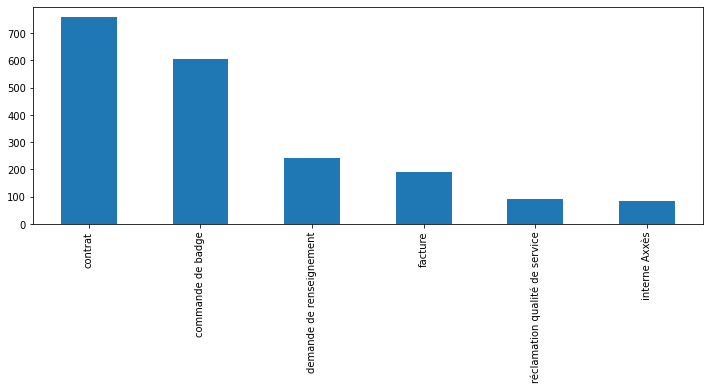

In [12]:
my_tags = msg['catégorie']
plt.figure(figsize=(12,4))
my_tags.value_counts().plot(kind='bar');

In [13]:
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import MaxAbsScaler
from sklearn.naive_bayes import MultinomialNB

In [14]:
my_tags = ['contrat', 'commande de badge', 'réclamation qualité de service',
       'interne Axxès', 'renseignement facture',
       'demande de renseignement', 'remplacement badge',
       'réclamation facture', 'réclamation logistique', 'amende Belgique'
      ]

In [15]:
from imblearn.over_sampling import SMOTE

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(msg['Messages'],
                               msg['catégorie'],stratify=msg['catégorie'], random_state=42
)

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
k=10
seed=12
ss={'contrat':0 ,'demande de renseignement' : 1,'interne Axxès' : 2 ,'renseignement facture' : 3,'commande de badge' : 4,'réclamation qualité de service' : 5,'no message' : 6,'réclamation facture':7,'remplacement badge':8,'réclamation logistique':9,'amende Belgique': 10}
count_class_0 = 11
count_class_1 = 300
textclassifier =Pipeline([
  ('vect', CountVectorizer()),
   ('tfidf', TfidfTransformer()),
  # ('trans' , MaxAbsScaler()),#with_mean=False
   #('under', RandomOverSampler()),#sampling_strategy=ss
   #('smote', SMOTE(random_state=seed,k_neighbors=k, sampling_strategy = 'minority')),
   #('near', NearMiss(sampling_strategy={1: count_class_1})),
   #('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))
     ('clf', LogisticRegression(n_jobs=-1, C=1e5)),
])

In [18]:
textclassifier.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=-1))])

In [19]:
from sklearn.metrics import classification_report
y_pred = textclassifier.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,labels=np.unique(y_pred)))

accuracy 0.6227180527383367
                                precision    recall  f1-score   support

             commande de badge       0.75      0.77      0.76       151
                       contrat       0.65      0.69      0.67       190
      demande de renseignement       0.33      0.34      0.34        61
                       facture       0.58      0.60      0.59        48
                 interne Axxès       0.64      0.33      0.44        21
réclamation qualité de service       0.23      0.14      0.17        22

                      accuracy                           0.62       493
                     macro avg       0.53      0.48      0.49       493
                  weighted avg       0.62      0.62      0.62       493



In [20]:
set(y_test) - set(y_pred)

set()

In [21]:
np.unique(y_pred)

array(['commande de badge', 'contrat', 'demande de renseignement',
       'facture', 'interne Axxès', 'réclamation qualité de service'],
      dtype=object)

In [22]:
np.unique(y_test)

array(['commande de badge', 'contrat', 'demande de renseignement',
       'facture', 'interne Axxès', 'réclamation qualité de service'],
      dtype=object)

In [33]:
textclassifier.predict(['Bonjour, L\'appareil 3156490017550003485 a été attribué au camion 21ZA19, qui n\'a jamais les réseaux l\'Allemagne ou l\'Autriche active, plus tard le 17/06, nous'])

array(['contrat'], dtype=object)

AttributeError: 'list' object has no attribute 'unique'

In [ ]:
import random
random.seed(7)

In [ ]:
msg['Messages'].apply(lambda x: len(x.split(' '))).sum()

In [ ]:
X = msg['Messages']
y = msg['catégorie']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
my_tags = ['contrat', 'commande de badge', 'réclamation qualité de service',
       'interne Axxès', 'renseignement facture',
       'demande de renseignement', 'remplacement badge',
       'réclamation facture', 'réclamation logistique', 'amende Belgique',
       'no message']

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression

In [ ]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

In [ ]:
clf_smote = LinearSVC().fit(X_resampled, y_resampled)

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [ ]:
all_predictions = sgd.predict(X_test)
pred = pd.DataFrame({
                    'Messages':X_test,
                    'Prédiction':all_predictions,
                    'Réel': y_test
                   })
pred.head(30)

In [ ]:
 pred.to_excel("predict_reel_contrat.xlsx", index = True)

In [ ]:
def cleant_text():
    tab=[]
    for i in msg.index:
        msg['Messages'][i]=re.sub('([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)', '', str(msg['Messages'][i]))#email
        #phone
        msg['Messages'][i]=re.sub(r"/\d{10}|\+33\d{9}|\+33\s\d{1}\s\d{2}\s\d{2}\s\d{2}\s\d{2}|\d{2}\s\d{2}\s\d{2}\s\d{2}\s\d{2}/g",' ',str(msg['Messages'][i]))#phone francais
        msg['Messages'][i]=re.sub(r'(^(\+33 |0)[1-6]{1}(([0-9]{2}){4})|((\s[0-9]{2}){4})|((-[0-9]{2}){4})$)','',str(msg['Messages'][i]))
        msg['Messages'][i]=re.sub("((?:\+\d{2}[-\.\s]??|\d{4}[-\.\s]??)?(?:\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4}))",'', str(msg['Messages'][i]))#phone
        msg['Messages'][i]=re.sub('\(?\d{2}\)?[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]?\d{2}','',str(msg['Messages'][i]))
        msg['Messages'][i]=re.sub('\(?\d{2}\)?[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]','',str(msg['Messages'][i]))
        msg['Messages'][i]=re.sub('\(?\d{1}\)?[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]','',str(msg['Messages'][i]))
        msg['Messages'][i]=re.sub('\(?\d{2}\)?[-.\s]?\d{5}[-.\s]?\d{3}','',str(msg['Messages'][i]))
        msg['Messages'][i]=re.sub('\(?\d{1}\)?[-.\s]?\d{2}[-.\s]?\d{2}[-.\s]?\d{3}','',str(msg['Messages'][i]))
        msg['Messages'][i]=re.sub('\(?\d{2}\)?[-.\s]?\d{3}[-.\s]?\d{3}[-.\s]?\d{3}','',str(msg['Messages'][i]))
        #Emoji
        emoji= re.compile(u'['u'\U0001F300-\U0001F64F'u'\U0001F680-\U0001F6FF'u'\u2600-\u26FF\u2700-\u27BF]+', re.UNICODE)
        msg['Messages'][i]=re.sub(emoji,' ',str(msg['Messages'][i]))
        #text
        msg['Messages'][i]= msg['Messages'][i].replace("Avant d\'imprimer cet e-mail, réfléchissez à l\'impact sur l\'environnementBefore you print this mail, think about the impact on the environment",'')
        dele = ["Mail:","Email:","e-mail","Email : ","mail","Tél : +","Fax : +","tél.: + ()","port.: + () ","fax.: + ()"]
        #df['Text'][i]= df['Text'][i].replace(dele,'')
        msg['Messages'][i]= msg['Messages'][i].replace("Mail:",'')
        msg['Messages'][i]= msg['Messages'][i].replace("Email:",'')
        msg['Messages'][i]= msg['Messages'][i].replace("E-mail",'')
        msg['Messages'][i]= msg['Messages'][i].replace("Email : ",'')
        msg['Messages'][i]= msg['Messages'][i].replace("mail",'')
        msg['Messages'][i]=re.sub(r'\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4}','',str(msg['Messages'][i]))
        #df['Text'][i]=re.sub(r'\d+','',str(df['Text'][i]))#Tél : +      Fax : +, tél.: + ()       fax.: + ()      port.: + () 
        msg['Messages'][i]= re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",'',msg['Messages'][i])#url
        msg['Messages'][i]= re.sub('(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})',' ',str(msg['Messages'][i]))#url www
        msg['Messages'][i]= re.sub('Ce message et toutes les Pieces jointes (ci apres : le message) sont etablis a l\'intention exclusive de ses destinataires et sont confidentiels.Toute utilisation de ce message non conforme a sa destination, toute diffusion ou toute publication totale ou partielle est interdite sauf autorisation prealable.Si vous recevez ce message par erreur, merci de le detruire et d\' avertir immediatement l\'expediteur.Les communications sur Internet n\'etant pas securisees, le Groupe APRR decline toute responsabilite quant au contenu de ce message.This message and all attached documents (hereafter "the message") are intended for the exclusive attention of its recipients and are confidential. Any use of this message, for which it was not intended, any distribution or any total or partial publication is prohibited unless previously approved.If you receive this message in error, please destroy it and immediately notify the sender thereof.Since communication by Internet is not secure, Group APRR cannot accept any responsibility regarding the contents of this message.',' ',str(msg['Messages'][i]))
        #df['Text'][i]= re.sub('SCAN <>Cet  a été envoyé par "copieurRICOH" (MP C3004ex).Date de numérisation: 07.08.2020 17:17:25 (+0200)Contacter si besoin :  ','',str(df['Text'][i]))
        msg['Messages'][i]= re.sub('Ce message est généré automatiquement. Merci de ne pas y répondre.',' ',str(msg['Messages'][i]))
        msg['Messages'][i]= re.sub('Ce message et toutes les Pieces jointes (ci apres : le message) sont etablis a l\'intention exclusive de ses destinataires et sont confidentiels.Toute utilisation de ce message non conforme a sa destination, toute diffusion ou toute publication totale ou partielle est interdite sauf autorisation prealable.Si vous recevez ce message par erreur, merci de le detruire et d\' avertir immediatement l\'expediteur.Les communications sur Internet n\'etant pas securisees, le Groupe APRR decline toute responsabilite quant au contenu de ce message.This message and all attached documents (hereafter "the message") are intended for the exclusive attention of its recipients and are confidential. Any use of this message, for which it was not intended, any distribution or any total or partial publication is prohibited unless previously approved.If you receive this message in error, please destroy it and immediately notify the sender thereof.Since communication by Internet is not secure, Group APRR cannot accept any responsibility regarding the contents of this message.',' ',str(msg['Messages'][i]))
        msg['Messages'][i]= re.sub('This message and any attachments are confidential and intended for the named addressee(s) only.If you have received this message in error, please notify immediately the sender, then deletethe message. Any unauthorized modification, edition, use or dissemination is prohibited.The sender shall not be liable for this message if it has been modified, altered, falsified, infectedby a virus or even edited or disseminated without authorization.',' ',str(msg['Messages'][i]))
        msg['Messages'][i]= re.sub('This  transmission (message and any attached files) may contain information that is proprietary, privileged and/or confidential to Veolia Environnement and/or its affiliates and is intended exclusively for the person(s) to whom it is addressed. If you are not the intended recipient, please notify the sender by return  and delete all copies of this , including all attachments. Unless expressly authorized, any use, disclosure, publication, retransmission or dissemination of this  and/or of its attachments is strictly prohibited. Ce message electronique et ses fichiers attaches sont strictement confidentiels et peuvent contenir des elements dont Veolia Environnement et/ou l\'une de ses entites affiliees sont proprietaires. Ils sont donc destines a l\'usage de leurs seuls destinataires. Si vous avez recu ce message par erreur, merci de le retourner a son emetteur et de le detruire ainsi que toutes les pieces attachees. L\'utilisation, la divulgation, la publication, la distribution, ou la reproduction non expressement autorisees de ce message et de ses pieces attachees sont interdites.',' ',str(msg['Messages'][i]))
        msg['Messages'][i]= re.sub('This  transmission (message and any attached files) may contain information that is proprietary, privileged and/or confidential to Veolia Environnement and/or its affiliates and is intended exclusively for the person(s) to whom it is addressed. If you are not the intended recipient, please notify the sender by return  and delete all copies of this , including all attachments. Unless expressly authorized, any use, disclosure, publication, retransmission or dissemination of this  and/or of its attachments is strictly prohibited.  Ce message electronique et ses fichiers attaches sont strictement confidentiels et peuvent contenir des elements dont Veolia Environnement et/ou l\'une de ses entites affiliees sont proprietaires. Ils sont donc destines a l\'usage de leurs seuls destinataires. Si vous avez recu ce message par erreur, merci de le retourner a son emetteur et de le detruire ainsi que toutes les pieces attachees. L\'utilisation, la divulgation, la publication, la distribution, ou la reproduction non expressement autorisees de ce message et de ses pieces attachees sont interdites.',' ',str(msg['Messages'][i]))
        msg['Messages'][i]= re.sub('Le contenu de ce message est strictement réservé à l\'usage exclusif de son destinataire et contient de l\'information privilégiée et confidentielle. Toute lecture, divulgation, distribution ou copie non autorisée de cette communication est formellement interdite. Si vous avez reçu cette communication par erreur, veuillez la détruire immédiatement.','',str(msg['Messages'][i]))
        msg['Messages'][i]= re.sub('Ce message et toutes les Pieces jointes (ci apres : le message) sont etablis a l\'intention exclusive de ses destinataires et sont confidentiels.Toute utilisation de ce message non conforme a sa destination, toute diffusion ou toute publication totale ou partielle est interdite sauf autorisation prealable.Si vous recevez ce message par erreur, merci de le detruire et d\' avertir immediatement l\'expediteur.Les communications sur Internet n\'etant pas securisees, le Groupe APRR decline toute responsabilite quant au contenu de ce message.This message and all attached documents (hereafter "the message") are intended for the exclusive attention of its recipients and are confidential. Any use of this message, for which it was not intended, any distribution or any total or partial publication is prohibited unless previously approved.If you receive this message in error, please destroy it and immediately notify the sender thereof.Since communication by Internet is not secure, Group APRR cannot accept any responsibility regarding the contents of this message.',' ',str(msg['Messages'][i]))
        msg['Messages'][i]= re.sub('Ce message et les pièces jointes sont confidentiels et établis à l\'attention exclusive de ses destinataires. Toute utilisation ou diffusion, même partielle, non autorisée est interdite. Tout message électronique est susceptible d\'altération. Brink\'s décline toute responsabilité au titre de ce message s\'il a été altéré, déformé ou falsifié. Si vous n\'êtes pas le destinataire de ce message, merci de le détruire et d\'avertir l\'expéditeur. This message and any attachments are confidential and intended solely for the addressees. Any unauthorized use or disclosure, either whole or partial is prohibited. E-s are susceptible to alteration. Brink\'s shall not be liable for the message if altered, changed or falsified. If you are not the intended recipient of this message, please delete it and notify the sender.',' ',str(msg['Messages'][i]))
        msg['Messages'][i]= re.sub('Ce message et toutes les Pieces jointes (ci apres : le message) sont etablis a l\'intention exclusive de ses destinataires et sont confidentiels.Toute utilisation de ce message non conforme a sa destination, toute diffusion ou toute publication totale ou partielle est interdite sauf autorisation prealable.Si vous recevez ce message par erreur, merci de le detruire et d\' avertir immediatement l\'expediteur.Les communications sur Internet n\'etant pas securisees, le Groupe APRR decline toute responsabilite quant au contenu de ce message.','',str(msg['Messages'][i]))
